# Importing all the necessary Libs

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img
import pickle


In [9]:
# data_preprocessing.py
"""Module for loading and preprocessing the MNIST dataset."""

class DataPreprocessor:
    """Class to handle loading and preprocessing of the MNIST dataset."""

    def __init__(self, batch_size):
        """
        Initialize the data preprocessor with the desired batch size.

        Parameters:
        - batch_size: int, the size of the batches in which to divide the dataset.
        """
        self.batch_size = batch_size
        self.y_test_callback = None  # Initialize y_test_callback


    def load_and_preprocess_data(self):
        """Load the MNIST dataset and perform preprocessing steps."""
        # Load MNIST dataset
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

        # Preprocess the training data
        x_train, y_train = self._preprocess_data(x_train, y_train)
        
        # Preprocess the test data
        x_test, y_test = self._preprocess_data(x_test, y_test, is_training=False)

        # Prepare the TensorFlow dataset
        dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        dataset = dataset.shuffle(buffer_size=1024).batch(self.batch_size)

        return dataset, (x_train, y_train), (x_test, y_test)

    def _preprocess_data(self, x_data, y_data, is_training=True):
        """
        Preprocess the input data by normalizing and reshaping.

        Parameters:
        - x_data: numpy.ndarray, the image data to preprocess.
        - y_data: numpy.ndarray, the labels to convert to one-hot encoding.
        - is_training: bool, indicates whether the data is for training (default: True).

        Returns:
        - Preprocessed image data and labels.
        """
        if not is_training:
            # For test data, keep the original labels for callbacks or other uses
            self.y_test_callback = y_data
            
        x_data = x_data.astype("float32") / 255.0
        x_data = np.reshape(x_data, (-1, 28, 28, 1))
        y_data = keras.utils.to_categorical(y_data, 10)

        return x_data, y_data


batch_size = 100
data_preprocessor = DataPreprocessor(batch_size=batch_size)
dataset, (x_train, y_train), (x_test, y_test) = data_preprocessor.load_and_preprocess_data()

print(f"Shape of training images: {x_train.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of testing images: {x_test.shape}")
print(f"Shape of testing labels: {y_test.shape}")


Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)
Shape of testing images: (10000, 28, 28, 1)
Shape of testing labels: (10000, 10)


In [10]:
y_test_original = data_preprocessor.y_test_callback
print(f"Original y_test labels: {y_test_original}")

Original y_test labels: [7 2 1 ... 4 5 6]


# Defining Conditional Generative Adversarial Network

In [12]:
class GANModel:
    """
    Represents a Generative Adversarial Network (GAN) model configuration.

    This class is designed to initialize and configure the basic parameters needed for a GAN model,
    including batch size, image dimensions, latent dimension, and the architecture of both the generator
    and discriminator networks. It is structured to support conditional GAN models by including a conditional
    vector size parameter.

    Attributes:
    -----------
    batch_size : int
        The size of each batch of images to be processed during training.
    num_channels : int
        The number of channels in the input images. For grayscale images, this is 1; for RGB, it's 3.
    num_classes : int
        The number of classes for conditional generation. This is used for conditional GANs.
    image_size : int
        The height and width of the images (assumed to be square).
    latent_dim : int
        The dimensionality of the latent space from which random samples are drawn to generate images.
    cond_vector_size : int
        The size of the conditional vector used in conditional GANs to provide additional information to the generator.
    generator_in_channels : int
        The number of input channels to the generator, calculated as the sum of the latent dimension and the conditional vector size.
    discriminator_in_channels : int
        The number of input channels to the discriminator, calculated as the sum of the number of image channels and the number of classes for conditional discrimination.
    """
    
    def __init__(self):
        """
        Initializes the GANModel with predefined configurations.
        """
        self.batch_size = 100  # Set the batch size for training
        self.num_channels = 1  # Set the number of image channels (e.g., 1 for grayscale)
        self.num_classes = 10  # Set the number of classes (for conditional GANs)
        self.image_size = 28  # Set the size of the images (28x28 pixels is common for datasets like MNIST)
        self.latent_dim = 100  # Set the dimension of the latent space
        self.cond_vector_size = 100  # Set the size of the conditional vector (for conditional GANs)
        # Calculate the number of input channels for the generator
        self.generator_in_channels = self.latent_dim + self.cond_vector_size
        # Calculate the number of input channels for the discriminator
        self.discriminator_in_channels = self.num_channels + self.num_classes

    
    def build_discriminator(self):
        """
        Builds the discriminator model for the GAN.

        The discriminator takes an image as input and outputs a single value representing the probability
        that the given image is real (as opposed to fake). This model uses a sequence of convolutional layers
        followed by a global max pooling layer and a dense output layer with a sigmoid activation.

        Returns:
        --------
        model : keras.Sequential
            The discriminator model, compiled and ready for training.
        """
        # Define the input shape based on class configuration
        input_shape = (self.image_size, self.image_size, self.discriminator_in_channels)
        
        # Sequentially define the model
        model = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape),  # Input layer specifying the expected input shape
                layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),  # Convolutional layer with 64 filters
                layers.LeakyReLU(alpha=0.2),  # LeakyReLU activation with alpha set to 0.2
                layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),  # Another convolutional layer with 128 filters
                layers.LeakyReLU(alpha=0.2),  # LeakyReLU activation with alpha set to 0.2
                layers.GlobalMaxPooling2D(),  # Global Max Pooling to reduce the spatial dimensions
                layers.Dense(1, activation="sigmoid"),  # Output layer with a single neuron and sigmoid activation
            ],
            name="discriminator",  # Naming the model for easier identification
        )
        
        return model  # Return the constructed model



    def build_generator(self):
        """
        Builds the generator model for the GAN.

        This function creates a sequential model for the generator part of a GAN, designed to generate images from a latent space.
        The generator architecture starts with a dense layer, reshapes the output to a 3D tensor, and uses a series of
        Conv2DTranspose layers (also known as deconvolution layers) to upscale the tensor to the desired output image size.
        The final layer uses a sigmoid activation function to normalize the output to the range [0, 1], suitable for image data.

        Returns:
        --------
        model : keras.Model
            The Keras sequential model representing the generator. It takes input from the latent space
            (augmented with a conditional vector if applicable) and outputs generated images.
        """
        # Define the input shape based on the generator's input channels (latent dim + conditional vector size)
        input_shape = (self.generator_in_channels,)

        # Create the sequential model
        model = keras.Sequential([
            keras.layers.InputLayer(input_shape),
            layers.Dense(7 * 7 * 110),  # Dense layer to project and reshape the latent vector
            layers.LeakyReLU(alpha=0.2),  # LeakyReLU to add non-linearity
            layers.Reshape((7, 7, 110)),  # Reshape the output into a 3D tensor for convolutional layers
            layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),  # Upsample to larger images
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),  # Further upsample
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),  # Output layer to generate final image
        ], name="generator")

        return model


gan_model = GANModel()



# Defining Custom Training Loop

In [16]:
class ConditionalGAN(keras.Model):
    
    def __init__(self, gan_model, regularizer):

        super().__init__()
        self.discriminator = gan_model.build_discriminator()
        self.generator = gan_model.build_generator()
        self.latent_dim = gan_model.latent_dim
        self.image_size = gan_model.image_size
        self.num_classes = gan_model.num_classes

        self.regularizer = regularizer
        
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.gen_total_loss_tracker = keras.metrics.Mean(name="generator_total_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.real_accuracy_tracker = keras.metrics.Mean(name="real_image_accuracy")
        self.fake_accuracy_tracker = keras.metrics.Mean(name="fake_image_accuracy")


    @property
    def metrics(self):
        """
        Defines a list of metrics to be tracked during the training of the ConditionalGAN model.

        This property is used by the Keras framework to automatically track the progress of
        these metrics across epochs during training and evaluation.

        Returns:
            A list of keras.metrics.Mean objects corresponding to the generator loss, generator total loss,
            discriminator loss, real image accuracy, and fake image accuracy.
        """
        # Return the list of metric trackers for the generator and discriminator
        return [
            self.gen_loss_tracker,  # Tracks the loss of the generator
            self.gen_total_loss_tracker,  # Tracks the total loss of the generator, including regularization
            self.disc_loss_tracker,  # Tracks the loss of the discriminator
            self.real_accuracy_tracker,  # Tracks the accuracy of the discriminator on real images
            self.fake_accuracy_tracker  # Tracks the accuracy of the discriminator on fake images generated by the generator
        ]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        """
        Configures the ConditionalGAN model for training.

        This method sets up the optimizers and loss function for both the generator and discriminator components
        of the ConditionalGAN. It also prepares a separate loss function for calculating mean squared error (MSE),
        which can be useful for certain types of regularization or additional loss components.

        Parameters:
            d_optimizer (tf.keras.optimizers.Optimizer): The optimizer to use for the discriminator.
            g_optimizer (tf.keras.optimizers.Optimizer): The optimizer to use for the generator.
            loss_fn (callable): The loss function to use for training the generator and discriminator.
        """
        # Call the compile method of the base class (keras.Model) to ensure any necessary setup is performed
        super().compile()
        
        # Store the optimizer for the discriminator
        self.d_optimizer = d_optimizer
        # Store the optimizer for the generator
        self.g_optimizer = g_optimizer
        # Store the main loss function for training
        self.loss_fn = loss_fn
        # Initialize a mean squared error loss function for potential use in regularization or other loss components
        self.mse_loss = tf.keras.losses.MeanSquaredError()

    def train_step(self, data):
        """
        Custom training logic for one iteration of ConditionalGAN training.

        This method is called during each batch of data in the training process. It performs the forward pass,
        calculates losses for both the discriminator and generator, performs the backward pass and updates
        the model weights accordingly.

        Parameters:
            data (tuple): A tuple containing two elements; real_images and one_hot_labels. 
                          real_images are the real images from the dataset, and one_hot_labels are
                          the corresponding one-hot encoded labels.

        Returns:
            A dictionary containing the loss and accuracy metrics for monitoring.
        """
        # Unpack the data into real images and their corresponding one-hot encoded labels
        real_images, one_hot_labels = data

        # Prepare data for both discriminator and generator training steps
        image_one_hot_labels, condition_vector_reshaped, generator_inputs = self._prepare_data_for_discriminator_and_generator(real_images, one_hot_labels)

        # Train the discriminator on real and generated images
        d_loss = self._train_discriminator(real_images, image_one_hot_labels, generator_inputs)

        # Train the generator to produce images that fool the discriminator
        g_loss, g_total_loss, fake_image_and_labels = self._train_generator(image_one_hot_labels, condition_vector_reshaped, generator_inputs)

        # Concatenate real images with their labels for discriminator evaluation
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], axis=-1)

        # Evaluate discriminator's performance on fake and real images
        f_predictions = self.discriminator(fake_image_and_labels)
        r_predictions = self.discriminator(real_image_and_labels)

        # Calculate accuracy of discriminator on fake and real images
        f_acc = tf.reduce_mean(f_predictions)
        r_acc =  tf.reduce_mean(r_predictions)

        # Update metrics to track losses and accuracies
        self._update_metrics(g_loss, g_total_loss, d_loss, f_acc, r_acc)

        # Return the current values of the metrics
        return self._get_metric_results()

    def _prepare_data_for_discriminator_and_generator(self, real_images, one_hot_labels):
        """
        Prepares and transforms the real images and labels for discriminator and generator training.

        This method performs several key steps:
        - Expands and repeats the one-hot encoded labels to match the spatial dimensions of the images.
        - Extracts a specific region from the real images to create a condition vector.
        - Generates random latent vectors as part of the generator's input.

        Parameters:
            real_images (tf.Tensor): The batch of real images.
            one_hot_labels (tf.Tensor): The one-hot encoded labels corresponding to the real images.

        Returns:
            tuple: A tuple containing three elements:
                - Expanded and repeated one-hot labels to match image dimensions.
                - Reshaped condition vector extracted from real images.
                - Concatenated input for the generator consisting of random latent vectors and the condition vector.
        """
        # Expand and repeat one-hot labels to match the spatial dimensions of the images
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[self.image_size * self.image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, self.image_size, self.image_size, self.num_classes)
        )

        # Extract and reshape a specific region from the real images to create a condition vector
        condition_vector = real_images[:, 10:20, 10:20, 0]  # Extracting a 10x10 region
        condition_vector_reshaped = tf.reshape(
            condition_vector, (-1, 100)  # Reshaping to match the generator's expected input size
        )

        # Calculate the batch size based on the real images tensor
        batch_size = tf.shape(real_images)[0]
        # Generate random latent vectors sized according to the latent dimension
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Concatenate random latent vectors with the reshaped condition vector for the generator's input
        generator_inputs = tf.concat([random_latent_vectors, condition_vector_reshaped], axis=1)

        return image_one_hot_labels, condition_vector_reshaped, generator_inputs

    def _train_discriminator(self, real_images, image_one_hot_labels, generator_inputs):
        """
        Trains the discriminator to distinguish between real and generated images.

        This method generates images using the generator, combines them with real images,
        and trains the discriminator to classify real images as real and generated images as fake.

        Parameters:
            real_images (tf.Tensor): A batch of real images from the dataset.
            image_one_hot_labels (tf.Tensor): One-hot encoded labels for the real images, expanded to match the image dimensions.
            generator_inputs (tf.Tensor): Inputs for the generator, including latent vectors and possibly condition vectors.

        Returns:
            d_loss (tf.Tensor): The loss value for the discriminator after the training step.
        """
        # Generate images using the provided inputs to the generator
        generated_images = self.generator(generator_inputs, training=False)  # Generator is not trained here

        # Combine the real and generated images to form a mixed dataset
        combined_images = tf.concat([real_images, generated_images], axis=0)
        # Duplicate the one-hot labels for both real and generated images
        image_labels = tf.concat([image_one_hot_labels, image_one_hot_labels], axis=0)
        # Concatenate images with their corresponding labels
        combined_images_and_labels = tf.concat([combined_images, image_labels], axis=-1)
        
        # Create labels for real (1s) and fake (0s) images
        batch_size = tf.shape(real_images)[0]  # Corrected to dynamically compute the batch size
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Use gradient tape for automatic differentiation
        with tf.GradientTape() as tape:
            # Discriminator makes predictions on the combined dataset
            predictions = self.discriminator(combined_images_and_labels, training=True)
            # Calculate the loss based on the discriminator's predictions and the true labels
            d_loss = self.loss_fn(labels, predictions)
        
        # Calculate gradients of loss with respect to discriminator weights
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Apply gradients to update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        return d_loss
    
    def _train_generator(self, image_one_hot_labels, condition_vector_reshaped, generator_inputs):
        """
        Trains the generator to produce images that are classified as real by the discriminator.

        This method generates images using the generator and trains it based on the discriminator's
        ability to classify the generated images as real. It uses a combination of a basic adversarial
        loss and a mean squared error loss to encourage similarity between the generated images and
        a specific condition or feature.

        Parameters:
            image_one_hot_labels (tf.Tensor): The one-hot encoded labels for the images, expanded to match image dimensions.
            condition_vector_reshaped (tf.Tensor): The condition vector reshaped to match the generator's expected input format.
            generator_inputs (tf.Tensor): The inputs for the generator, including latent vectors and possibly condition vectors.

        Returns:
            tuple: A tuple containing the generator loss without regularization (g_loss), the total generator loss
                   including regularization (g_total_loss), and the generated images concatenated with their labels (fake_image_and_labels).
        """
        # Determine the batch size from the shape of the one-hot labels
        batch_size = tf.shape(image_one_hot_labels)[0]

        with tf.GradientTape() as tape:
            # Generate images using the generator with training set to True
            generated_images = self.generator(generator_inputs, training=True)
            
            # Concatenate generated images with their corresponding one-hot labels
            fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], axis=-1)
            
            # Get the discriminator's predictions for the fake images, training flag is False because we don't train the discriminator here
            predictions = self.discriminator(fake_image_and_labels, training=False)
            
            # Calculate the adversarial loss based on the discriminator's predictions
            g_loss = self.loss_fn(tf.ones((batch_size, 1)), predictions)
            
            # Additional loss term to ensure generated images match a specific feature or condition
            fake_images_reshaped = tf.reshape(generated_images[:, 10:20, 10:20, :], (-1, 100))
            g_mse_loss = self.mse_loss(condition_vector_reshaped, fake_images_reshaped)
            
            # Total generator loss includes both adversarial loss and the mean squared error loss, scaled by the regularizer
            g_total_loss = g_loss + (self.regularizer * g_mse_loss)

        # Calculate gradients of the total generator loss with respect to generator weights
        grads = tape.gradient(g_total_loss, self.generator.trainable_weights)
        # Apply the gradients to update the generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return g_loss, g_total_loss, fake_image_and_labels

    def _update_metrics(self, g_loss, g_total_loss, d_loss, f_acc, r_acc):
        """
        Updates the tracking metrics for both generator and discriminator.

        This method updates the state of metrics tracking the performance of the generator and discriminator
        across training iterations. It includes losses and accuracies for real and fake images.

        Parameters:
            g_loss (tf.Tensor): Loss of the generator without considering the regularization term.
            g_total_loss (tf.Tensor): Total loss of the generator, including the regularization term.
            d_loss (tf.Tensor): Loss of the discriminator.
            f_acc (float): Discriminator's accuracy on fake (generated) images.
            r_acc (float): Discriminator's accuracy on real images.
        """
        # Update the generator loss without regularization
        self.gen_loss_tracker.update_state(g_loss)
        # Update the generator total loss including regularization
        self.gen_total_loss_tracker.update_state(g_total_loss)
        # Update the discriminator loss
        self.disc_loss_tracker.update_state(d_loss)
        # Update the discriminator's accuracy on fake images
        self.fake_accuracy_tracker.update_state(f_acc)
        # Update the discriminator's accuracy on real images
        self.real_accuracy_tracker.update_state(r_acc)

    def _get_metric_results(self):
        """
        Retrieves the current results of the tracking metrics.

        This method compiles the current state of each tracked metric into a dictionary,
        making it easy to report or log the performance of the model during training.

        Returns:
            dict: A dictionary containing the current values of generator loss, generator total loss,
                  discriminator loss, fake image accuracy, and real image accuracy.
        """
        # Return the current results of all tracked metrics
        return {
            "g_loss": self.gen_loss_tracker.result(),  # Generator loss
            "g_total_loss": self.gen_total_loss_tracker.result(),  # Generator total loss
            "d_loss": self.disc_loss_tracker.result(),  # Discriminator loss
            "f_acc": self.fake_accuracy_tracker.result(),  # Discriminator accuracy on fake images
            "r_acc": self.real_accuracy_tracker.result()  # Discriminator accuracy on real images
        }


# Defining custom callback class for training visualization

In [17]:
class OptimizedVisualizer(keras.callbacks.Callback):
    """
    A Keras Callback for visualizing the outputs of a GAN during training.

    This callback is designed to periodically generate and visualize images using
    the generator part of a GAN. It allows for monitoring the progress of GAN training
    by comparing generated images against real images from a dataset.
    """
    def __init__(self, generator_test, discriminator_test, real_images, real_labels):
        """
        Initializes the OptimizedVisualizer callback with the necessary components and data.

        Parameters:
            generator_test (tf.keras.Model): The generator model of the GAN used for generating images.
            discriminator_test (tf.keras.Model): The discriminator model of the GAN used for evaluating images.
            real_images (np.array): A batch of real images to compare against the generated images.
            real_labels (np.array): The labels corresponding to the real images, used for conditional generation.
        """
        super().__init__()
        self.generator_test = generator_test  # Generator model for image generation
        self.discriminator_test = discriminator_test  # Discriminator model for image evaluation
        self.latent_dim = 100  # Dimensionality of the latent space for the generator
        self.real_images = real_images  # Batch of real images for comparison
        self.real_labels = real_labels  # Corresponding labels for the real images
        self.one_hot_labels = tf.one_hot(tf.range(10), 10)  # One-hot encoded labels for the digit classes (0-9)  

    def on_epoch_end(self, epoch, logs=None):
        """
        Callback to be called at the end of an epoch during model training.

        This method generates images using the GAN's generator and compares them with real images.
        It visualizes both real and generated images along with the discriminator's output for each,
        allowing for monitoring the progress of GAN training.

        Parameters:
            epoch (int): The index of the epoch that just ended.
            logs (dict, optional): A dictionary of logs from the training process, including metrics.
        """
        # Obtain a batch of real images and their labels for plotting
        real_images_and_labels, real_images_plotting = self.get_real_image_and_labels()
        
        # Prepare conditioning vectors from a subset of real images
        conditioning_vector = real_images_plotting[:, 10:20, 10:20].reshape(-1, 100)
        
        # Generate random latent vectors
        random_latent_vectors = tf.random.normal(shape=(10, self.latent_dim))
        
        # Concatenate random latent vectors with the conditioning vectors
        random_vector_labels = tf.concat([random_latent_vectors, conditioning_vector], axis=-1)
        
        # Generate images using the conditioned latent vectors
        generated_images = self.generator_test(random_vector_labels)
        
        # Prepare generated images and their labels for discriminator evaluation
        fake_images_and_labels = self.get_fake_images_and_labels(generated_images)
        
        # Evaluate real and generated images using the discriminator
        discriminator_output_real_images = self.discriminator_test(real_images_and_labels)
        discriminator_output_fake_images = self.discriminator_test(fake_images_and_labels)
        
        # Visualize real images with the discriminator's output
        self.plot_images_with_disoutput(real_images_plotting, discriminator_output_real_images, title='Real Images')
        
        # Visualize generated (fake) images with the discriminator's output
        self.plot_images_with_disoutput(generated_images, discriminator_output_fake_images, title='Fake Images', fake=True)


    def get_fake_images_and_labels(self, generated_images):
        """
        Prepares fake images with one-hot encoded labels for discriminator evaluation.

        This method takes generated images and concatenates them with expanded and reshaped
        one-hot encoded labels. This step is necessary for evaluating the discriminator's
        performance on fake images with associated labels.

        Parameters:
            generated_images (tf.Tensor): The batch of images generated by the GAN's generator.

        Returns:
            tf.Tensor: A tensor containing the generated images concatenated with their one-hot encoded labels,
                       reshaped to match the discriminator's input requirements.
        """
        # Repeat the one-hot encoded labels to match the number of pixels in each generated image
        image_one_hot_labels = tf.repeat(self.one_hot_labels, repeats=[28 * 28], axis=0)
        
        # Reshape the repeated labels to match the spatial dimensions of the generated images
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, 28, 28, 10))
        
        # Concatenate the generated images with their corresponding one-hot encoded labels
        fake_images_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)

        return fake_images_and_labels

    
    def get_real_image_and_labels(self):
        """
        Selects a single image for each class label from the real images dataset and prepares them for visualization.

        This method randomly selects one image per class from the dataset of real images. It then prepares these images
        along with their one-hot encoded labels for visualization, matching the format expected by the discriminator.

        Returns:
            tuple: A tuple containing two elements:
                - A tensor of real images concatenated with their one-hot encoded labels, ready for discriminator evaluation.
                - A numpy array of the selected real images reshaped for visualization (without labels).
        """
        # Randomly select one image per class label
        selected_indices = [np.random.choice(np.where(self.real_labels == class_label)[0], size=1, replace=False) for class_label in range(10)]
        # Extract the selected images from the dataset
        selected_images = self.real_images[np.concatenate(selected_indices)].reshape(10, 28, 28, 1)
        
        # Use pre-defined one-hot labels for the selected images
        selected_labels = self.one_hot_labels
        # Repeat and reshape the one-hot labels to match the spatial dimensions of the images
        image_one_hot_labels = tf.repeat(selected_labels, repeats=[28 * 28], axis=0)
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, 28, 28, 10))
        
        # Concatenate the selected images with their corresponding one-hot encoded labels
        real_images_and_labels = tf.concat([selected_images, image_one_hot_labels], -1)

        return real_images_and_labels, selected_images.reshape(10, 28, 28)

    def plot_images_with_disoutput(self, images, discriminator_outputs, title, fake=False):
        """
        Visualizes images alongside the discriminator's output for each image.

        This method plots a row of images (either real or generated) and annotates each image with the discriminator's
        confidence score that the image is real. The images are displayed in grayscale, and the confidence score is
        shown as a title above each image.

        Parameters:
            images (List[np.array]): A list of images to be plotted.
            discriminator_outputs (List[float]): The discriminator's confidence scores for each image, indicating how
                                                 likely it is that the image is real.
            title (str): The title for the whole plot, displayed above the row of images.
            fake (bool, optional): A flag indicating whether the images are generated (fake) or not. This affects
                                   how the images are processed before plotting. Defaults to False.
        """
        # Create a figure and a set of subplots
        fig, axs = plt.subplots(1, 10, figsize=(18, 2))
        for i, (image, output) in enumerate(zip(images, discriminator_outputs)):
            # Display the image in grayscale, adjust for fake images if necessary
            axs[i].imshow(image[:, :, 0] if fake else image, cmap='gray')
            axs[i].axis('off')  # Hide the axis
            # Extract the scalar value from the discriminator output for annotation
            scalar_output = output.numpy().flatten()[0]
            # Set the title of each subplot to the discriminator's confidence score
            axs[i].set_title(f"{scalar_output:.2f}")
        # Set the overall title for the plot
        fig.suptitle(title)
        # Display the plot
        plt.show()


In [32]:
cond_gan = ConditionalGAN(
    gan_model=gan_model,  # The GAN model consisting of both generator and discriminator models.
    regularizer=1  # Regularization factor applied to the generator's loss.
)

# Print summaries of the generator and discriminator to verify their architectures.
# This is useful for debugging and ensuring the models are correctly configured.
cond_gan.generator.summary()
cond_gan.discriminator.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5390)              1083390   
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 5390)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 110)         0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 14, 14, 256)       450816    
 Transpose)                                                      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 256)       0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 28, 28, 128)       524416    
 Transpose)                                              


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 5390)              1083390   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 5390)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 110)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 256)       450816    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       524416    
 Transpose)                                             

c:\Users\anant\.conda\envs\gpu-env\lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


600/600 [==============================] - ETA: 0s - g_loss: 0.7137 - g_total_loss: 0.8115 - d_loss: 0.6821 - f_acc: 0.4902 - r_acc: 0.5046

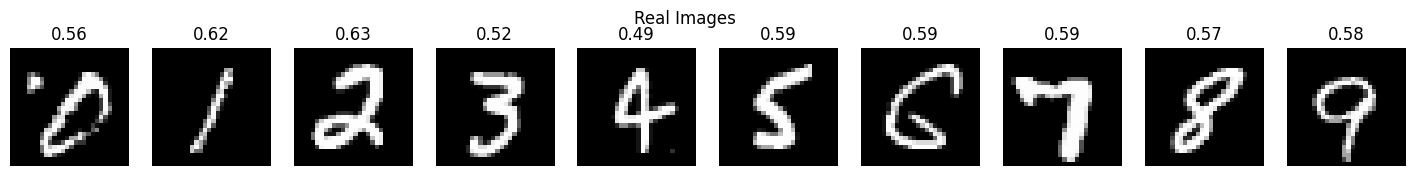

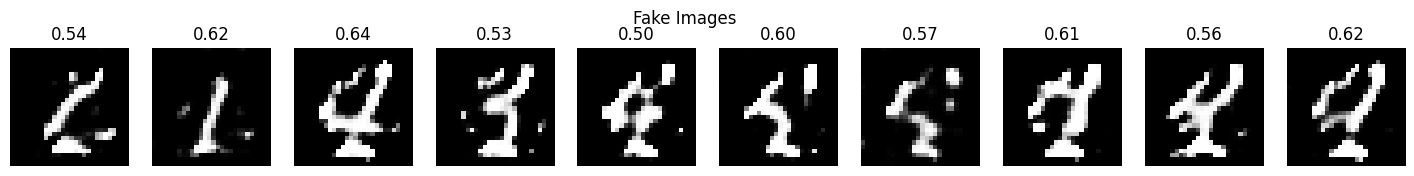

600/600 [==============================] - 110s 180ms/step - g_loss: 0.7137 - g_total_loss: 0.8114 - d_loss: 0.6821 - f_acc: 0.4902 - r_acc: 0.5046
Epoch 2/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7085 - g_total_loss: 0.7393 - d_loss: 0.6858 - f_acc: 0.4930 - r_acc: 0.5040

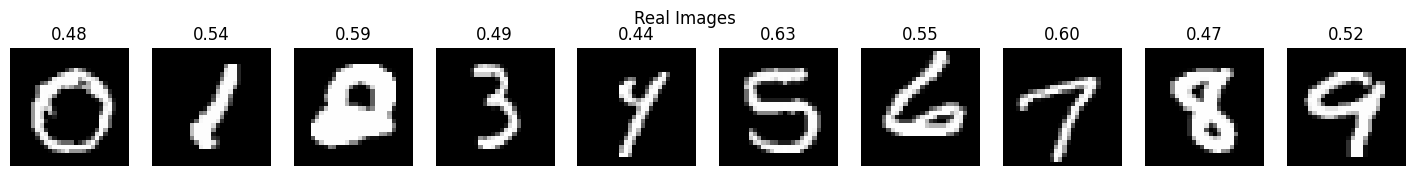

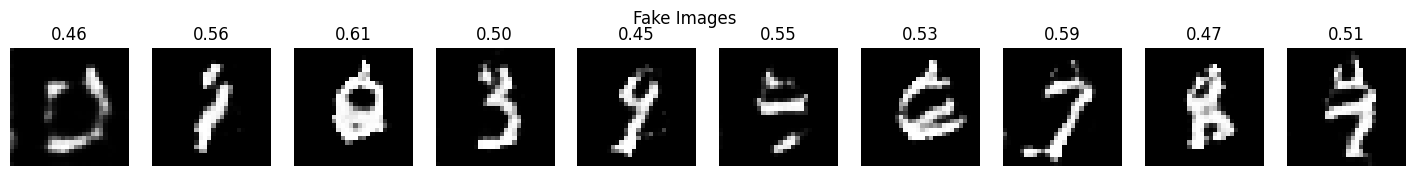

600/600 [==============================] - 108s 180ms/step - g_loss: 0.7085 - g_total_loss: 0.7393 - d_loss: 0.6858 - f_acc: 0.4930 - r_acc: 0.5040
Epoch 3/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7068 - g_total_loss: 0.7294 - d_loss: 0.6857 - f_acc: 0.4939 - r_acc: 0.5043

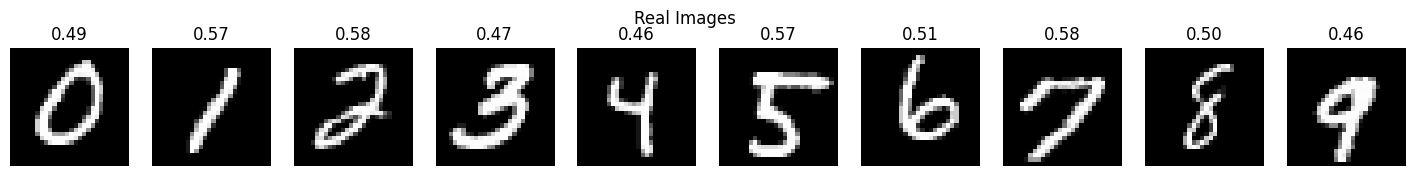

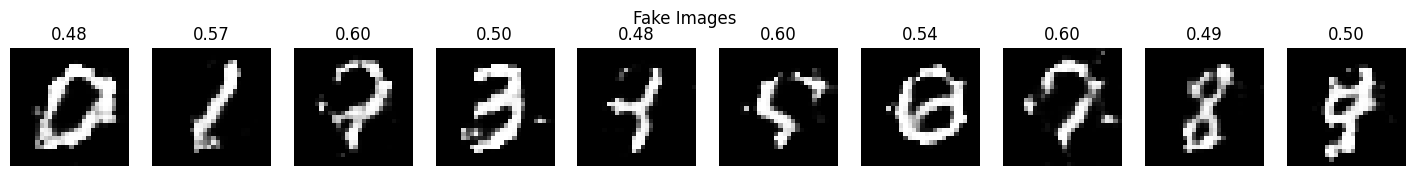

600/600 [==============================] - 110s 183ms/step - g_loss: 0.7068 - g_total_loss: 0.7294 - d_loss: 0.6858 - f_acc: 0.4939 - r_acc: 0.5043
Epoch 4/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7030 - g_total_loss: 0.7233 - d_loss: 0.6891 - f_acc: 0.4958 - r_acc: 0.5027

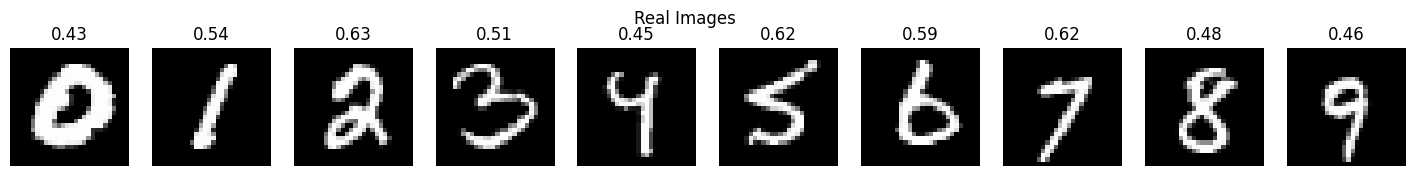

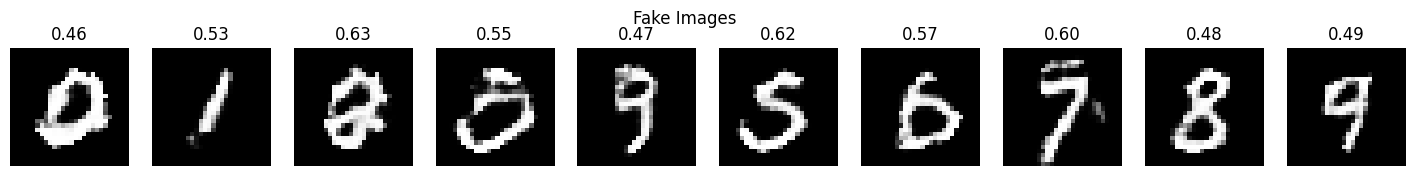

600/600 [==============================] - 110s 183ms/step - g_loss: 0.7030 - g_total_loss: 0.7233 - d_loss: 0.6891 - f_acc: 0.4958 - r_acc: 0.5027
Epoch 5/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7022 - g_total_loss: 0.7198 - d_loss: 0.6892 - f_acc: 0.4962 - r_acc: 0.5028

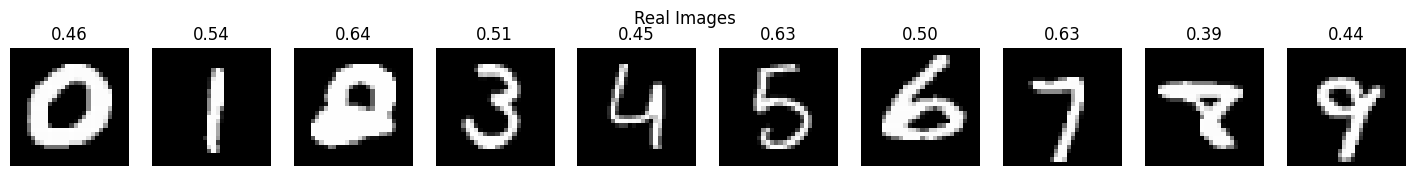

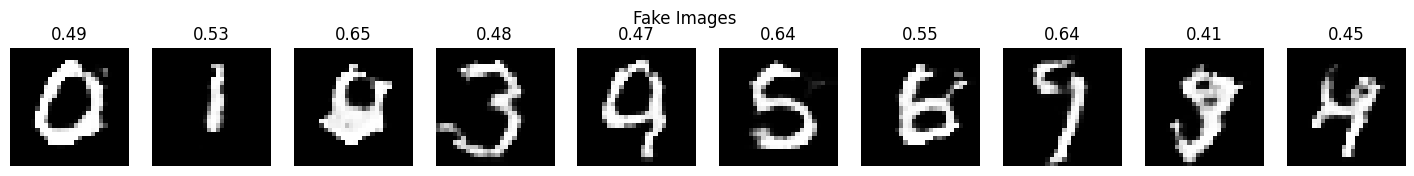

600/600 [==============================] - 109s 181ms/step - g_loss: 0.7022 - g_total_loss: 0.7198 - d_loss: 0.6892 - f_acc: 0.4962 - r_acc: 0.5028
Epoch 6/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6995 - g_total_loss: 0.7158 - d_loss: 0.6919 - f_acc: 0.4975 - r_acc: 0.5013

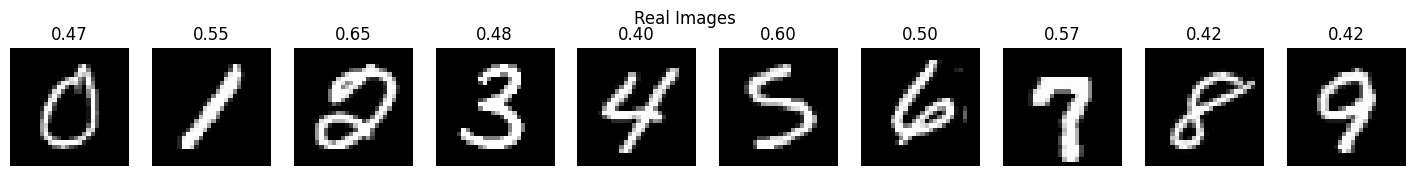

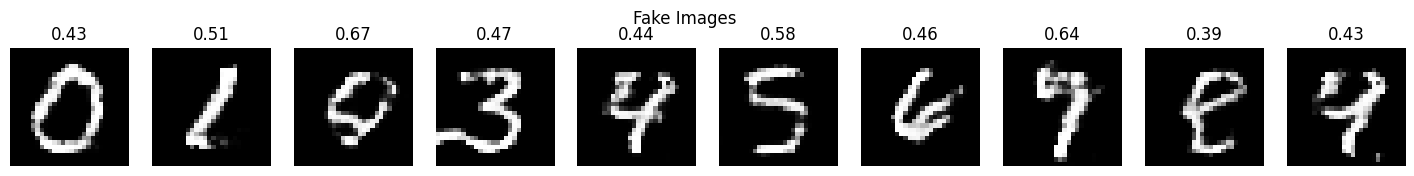

600/600 [==============================] - 113s 188ms/step - g_loss: 0.6995 - g_total_loss: 0.7158 - d_loss: 0.6919 - f_acc: 0.4975 - r_acc: 0.5013
Epoch 7/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6992 - g_total_loss: 0.7146 - d_loss: 0.6914 - f_acc: 0.4977 - r_acc: 0.5018

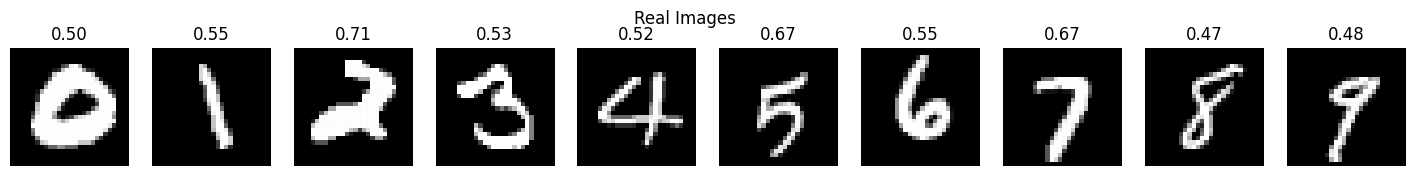

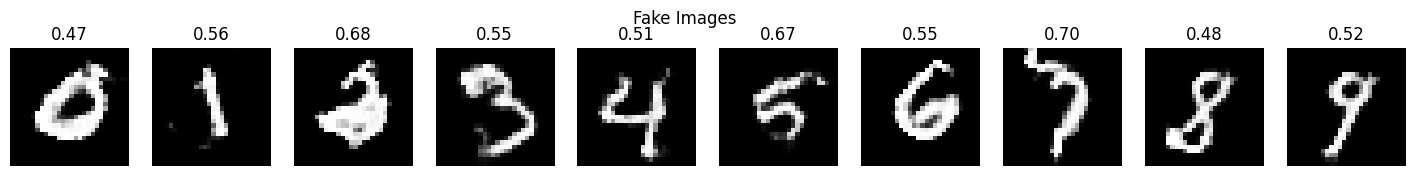

600/600 [==============================] - 113s 189ms/step - g_loss: 0.6992 - g_total_loss: 0.7146 - d_loss: 0.6914 - f_acc: 0.4977 - r_acc: 0.5018
Epoch 8/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6985 - g_total_loss: 0.7122 - d_loss: 0.6918 - f_acc: 0.4979 - r_acc: 0.5012

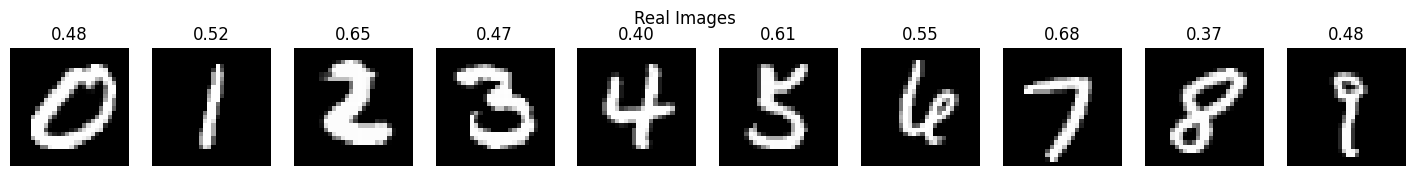

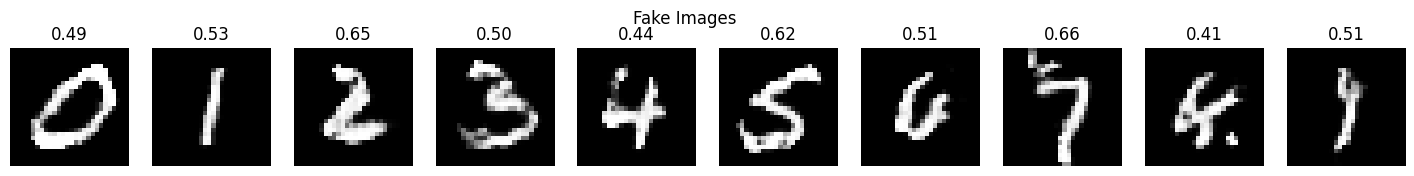

600/600 [==============================] - 113s 188ms/step - g_loss: 0.6985 - g_total_loss: 0.7122 - d_loss: 0.6918 - f_acc: 0.4979 - r_acc: 0.5012
Epoch 9/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6970 - g_total_loss: 0.7089 - d_loss: 0.6926 - f_acc: 0.4986 - r_acc: 0.5009

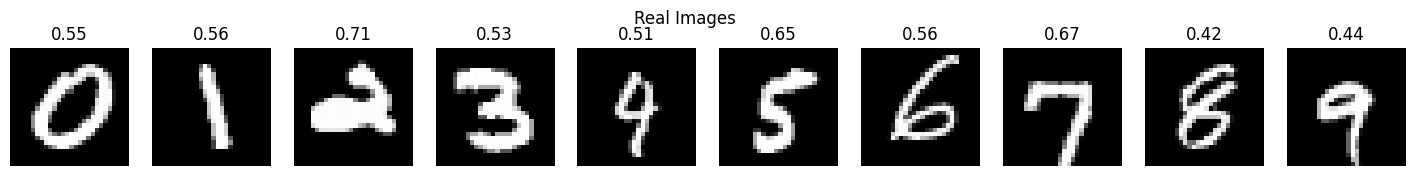

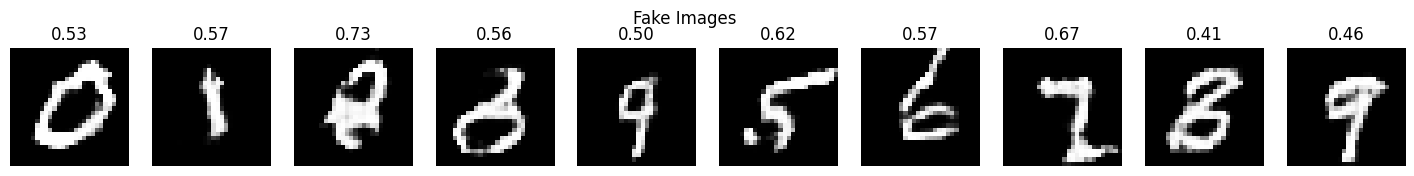

600/600 [==============================] - 112s 187ms/step - g_loss: 0.6970 - g_total_loss: 0.7089 - d_loss: 0.6926 - f_acc: 0.4986 - r_acc: 0.5009
Epoch 10/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6967 - g_total_loss: 0.7080 - d_loss: 0.6927 - f_acc: 0.4987 - r_acc: 0.5008

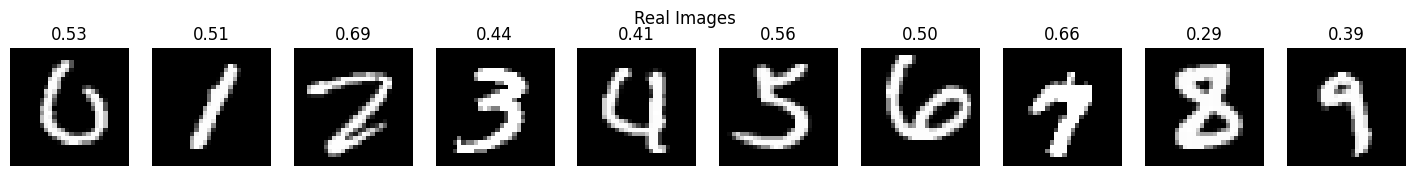

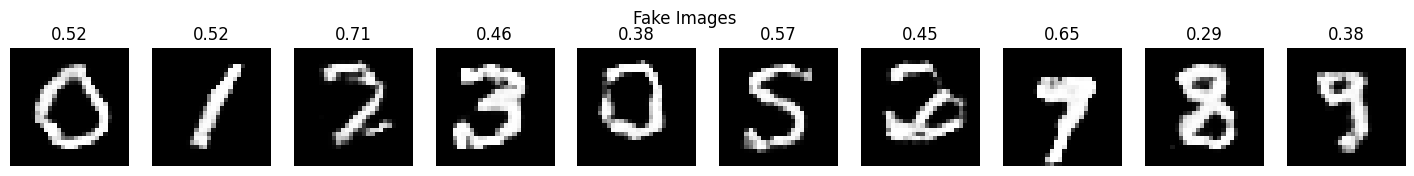

600/600 [==============================] - 113s 189ms/step - g_loss: 0.6967 - g_total_loss: 0.7080 - d_loss: 0.6927 - f_acc: 0.4987 - r_acc: 0.5008
Epoch 11/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6972 - g_total_loss: 0.7072 - d_loss: 0.6921 - f_acc: 0.4985 - r_acc: 0.5011

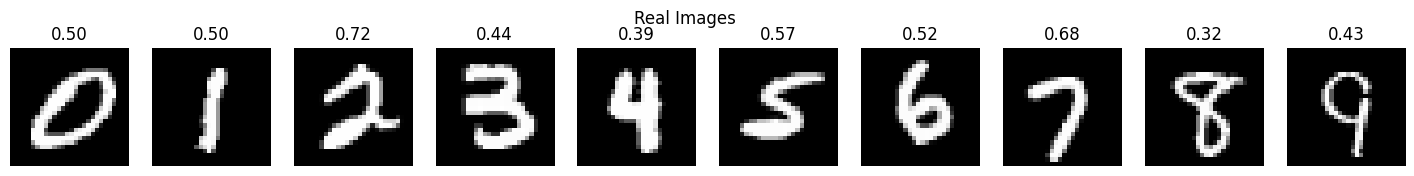

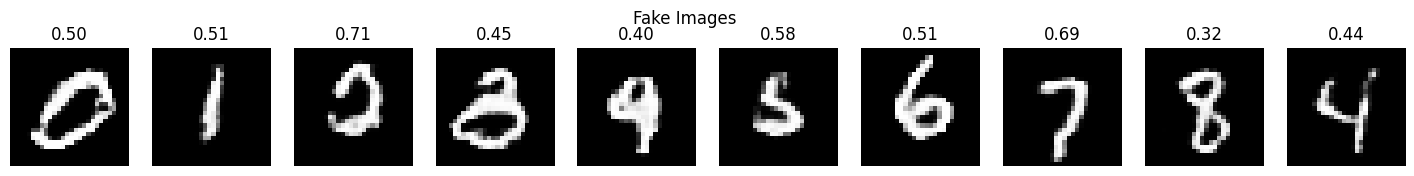

600/600 [==============================] - 119s 198ms/step - g_loss: 0.6972 - g_total_loss: 0.7072 - d_loss: 0.6921 - f_acc: 0.4985 - r_acc: 0.5011
Epoch 12/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6977 - g_total_loss: 0.7079 - d_loss: 0.6914 - f_acc: 0.4982 - r_acc: 0.5014

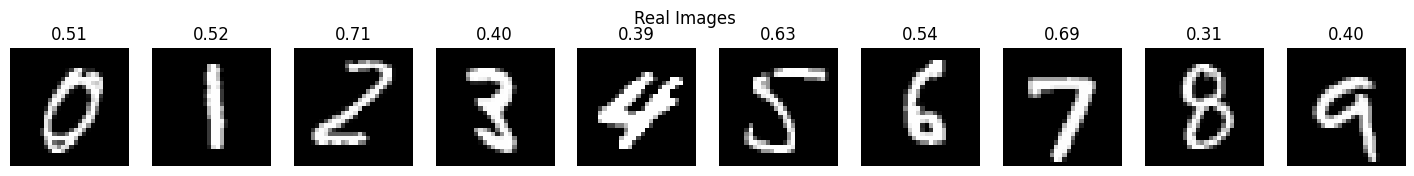

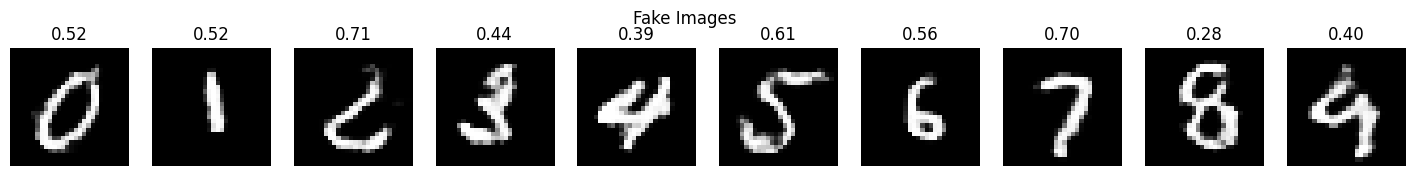

600/600 [==============================] - 113s 189ms/step - g_loss: 0.6977 - g_total_loss: 0.7079 - d_loss: 0.6914 - f_acc: 0.4982 - r_acc: 0.5014
Epoch 13/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6977 - g_total_loss: 0.7070 - d_loss: 0.6912 - f_acc: 0.4982 - r_acc: 0.5015

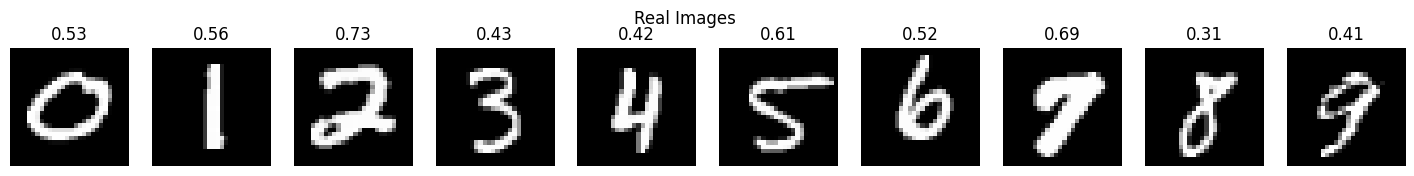

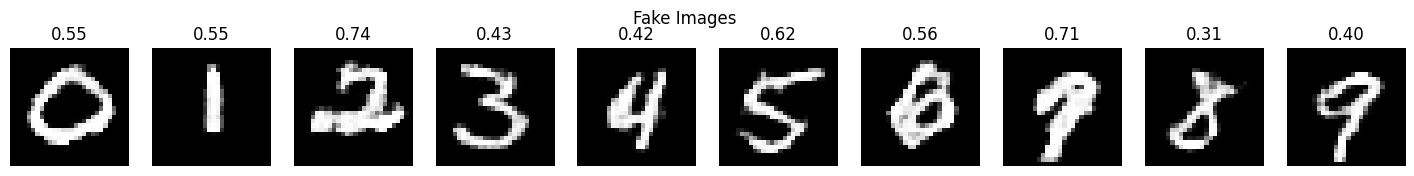

600/600 [==============================] - 112s 187ms/step - g_loss: 0.6977 - g_total_loss: 0.7070 - d_loss: 0.6912 - f_acc: 0.4982 - r_acc: 0.5015
Epoch 14/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6975 - g_total_loss: 0.7077 - d_loss: 0.6921 - f_acc: 0.4983 - r_acc: 0.5010

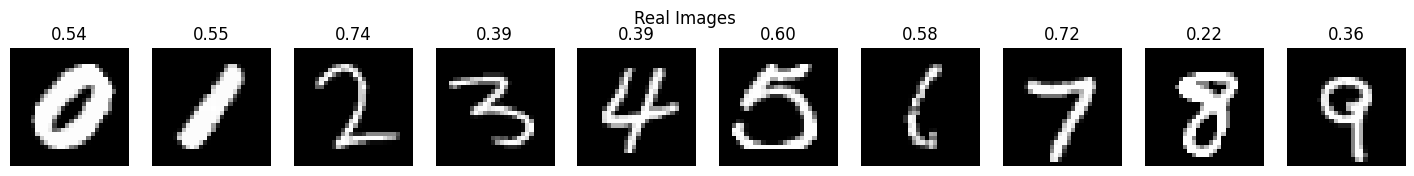

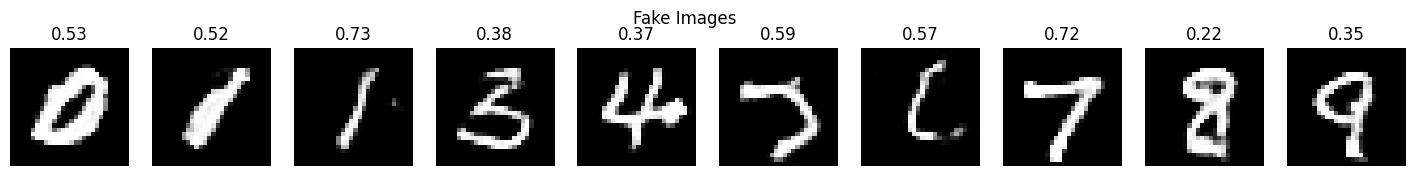

600/600 [==============================] - 113s 189ms/step - g_loss: 0.6975 - g_total_loss: 0.7077 - d_loss: 0.6921 - f_acc: 0.4983 - r_acc: 0.5010
Epoch 15/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6979 - g_total_loss: 0.7069 - d_loss: 0.6912 - f_acc: 0.4981 - r_acc: 0.5015

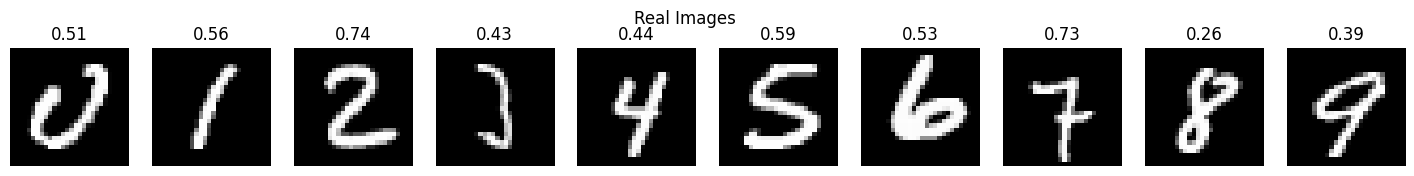

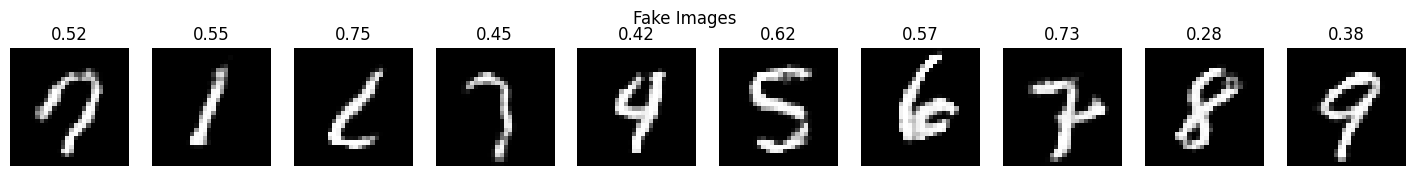

600/600 [==============================] - 113s 188ms/step - g_loss: 0.6979 - g_total_loss: 0.7069 - d_loss: 0.6912 - f_acc: 0.4981 - r_acc: 0.5015
Epoch 16/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6984 - g_total_loss: 0.7072 - d_loss: 0.6909 - f_acc: 0.4979 - r_acc: 0.5017

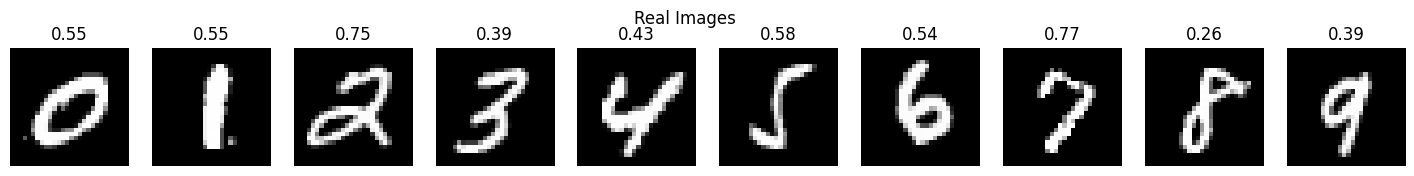

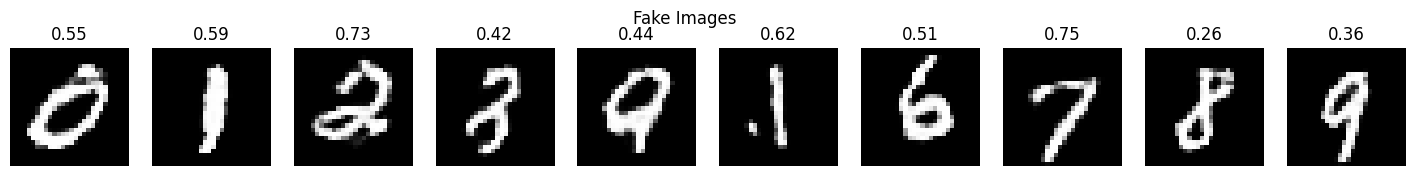

600/600 [==============================] - 113s 188ms/step - g_loss: 0.6984 - g_total_loss: 0.7072 - d_loss: 0.6909 - f_acc: 0.4979 - r_acc: 0.5017
Epoch 17/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6978 - g_total_loss: 0.7071 - d_loss: 0.6920 - f_acc: 0.4982 - r_acc: 0.5011

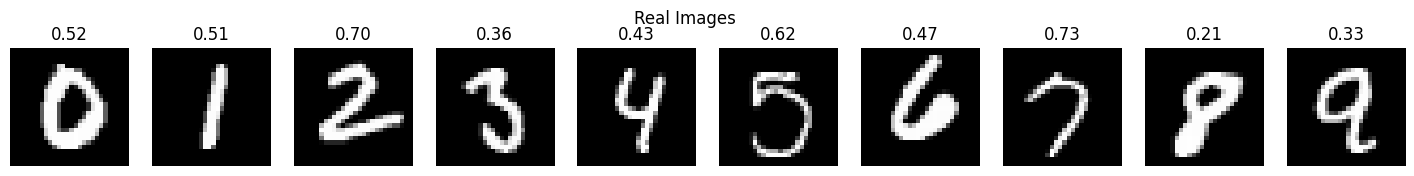

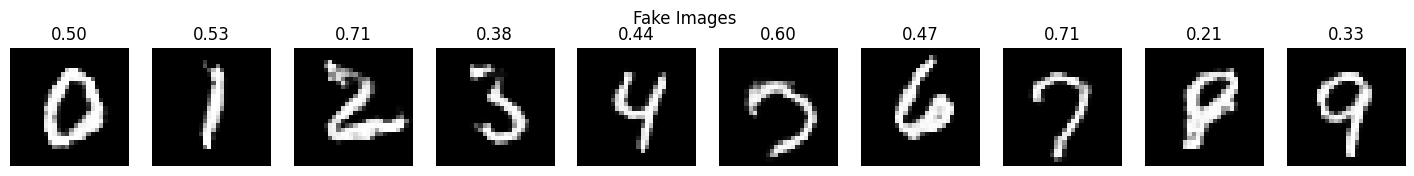

600/600 [==============================] - 116s 194ms/step - g_loss: 0.6978 - g_total_loss: 0.7071 - d_loss: 0.6920 - f_acc: 0.4982 - r_acc: 0.5011
Epoch 18/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6988 - g_total_loss: 0.7075 - d_loss: 0.6906 - f_acc: 0.4978 - r_acc: 0.5019

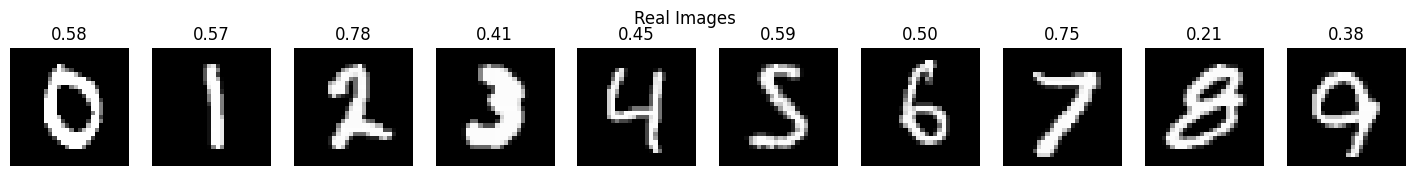

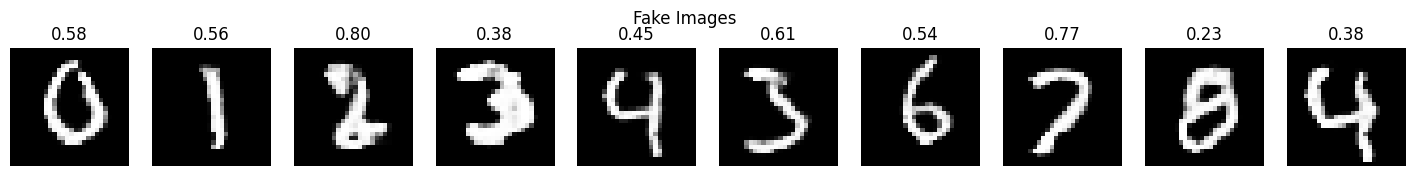

600/600 [==============================] - 111s 186ms/step - g_loss: 0.6988 - g_total_loss: 0.7075 - d_loss: 0.6906 - f_acc: 0.4978 - r_acc: 0.5019
Epoch 19/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6989 - g_total_loss: 0.7074 - d_loss: 0.6906 - f_acc: 0.4977 - r_acc: 0.5018

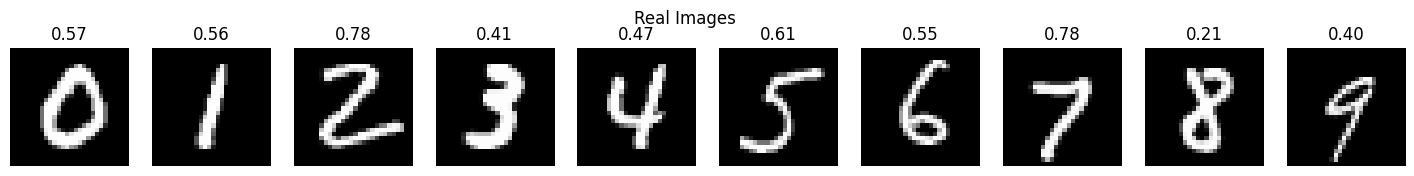

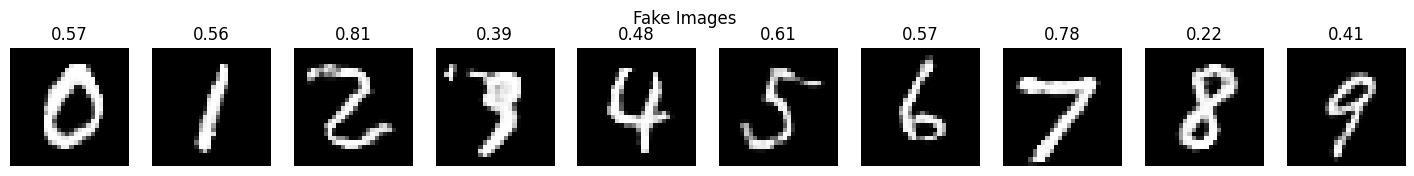

600/600 [==============================] - 111s 185ms/step - g_loss: 0.6989 - g_total_loss: 0.7074 - d_loss: 0.6906 - f_acc: 0.4977 - r_acc: 0.5018
Epoch 20/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6994 - g_total_loss: 0.7073 - d_loss: 0.6902 - f_acc: 0.4975 - r_acc: 0.5018

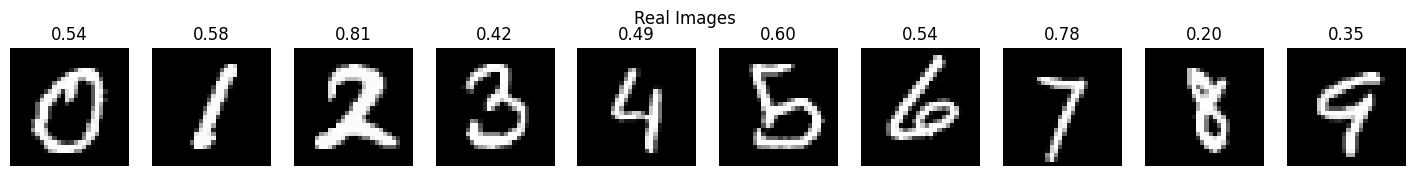

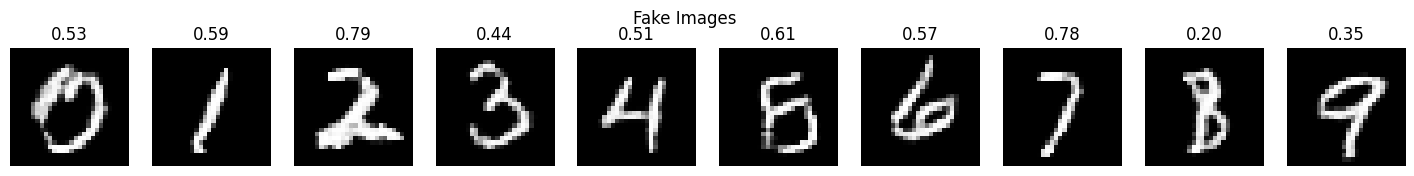

600/600 [==============================] - 112s 186ms/step - g_loss: 0.6994 - g_total_loss: 0.7073 - d_loss: 0.6902 - f_acc: 0.4975 - r_acc: 0.5018
Epoch 21/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6995 - g_total_loss: 0.7077 - d_loss: 0.6903 - f_acc: 0.4975 - r_acc: 0.5020

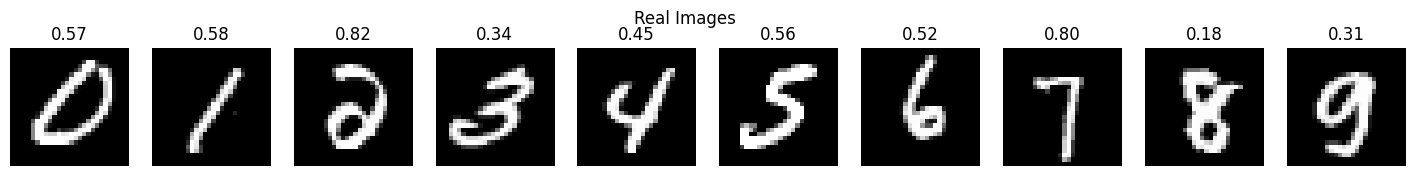

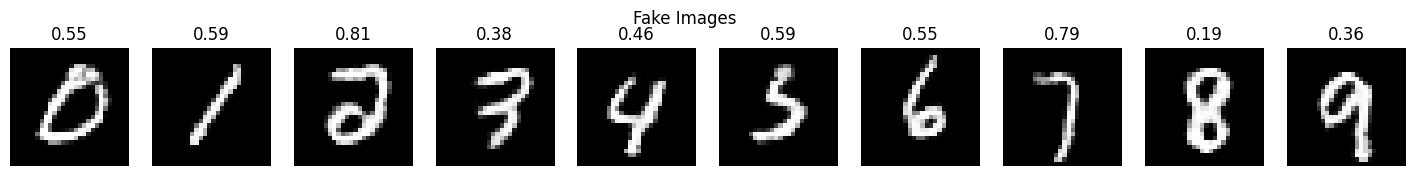

600/600 [==============================] - 113s 189ms/step - g_loss: 0.6995 - g_total_loss: 0.7077 - d_loss: 0.6903 - f_acc: 0.4975 - r_acc: 0.5020
Epoch 22/150
600/600 [==============================] - ETA: 0s - g_loss: 0.6996 - g_total_loss: 0.7074 - d_loss: 0.6900 - f_acc: 0.4974 - r_acc: 0.5021

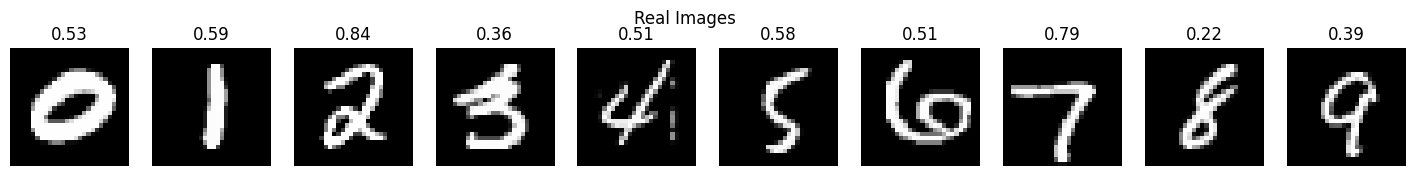

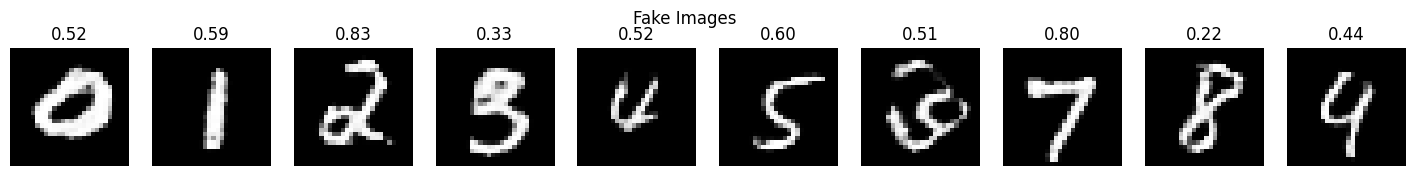

600/600 [==============================] - 110s 184ms/step - g_loss: 0.6996 - g_total_loss: 0.7074 - d_loss: 0.6900 - f_acc: 0.4974 - r_acc: 0.5021
Epoch 23/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7003 - g_total_loss: 0.7085 - d_loss: 0.6896 - f_acc: 0.4971 - r_acc: 0.5025

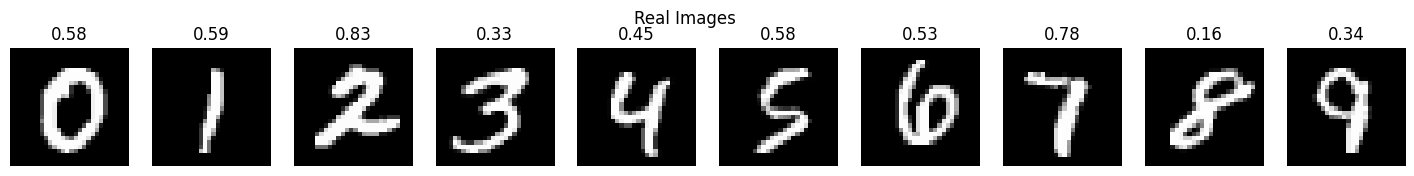

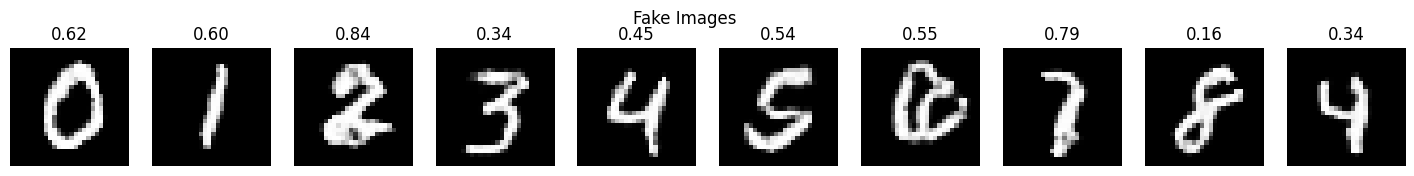

600/600 [==============================] - 113s 189ms/step - g_loss: 0.7003 - g_total_loss: 0.7084 - d_loss: 0.6896 - f_acc: 0.4971 - r_acc: 0.5025
Epoch 24/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7009 - g_total_loss: 0.7090 - d_loss: 0.6893 - f_acc: 0.4969 - r_acc: 0.5026

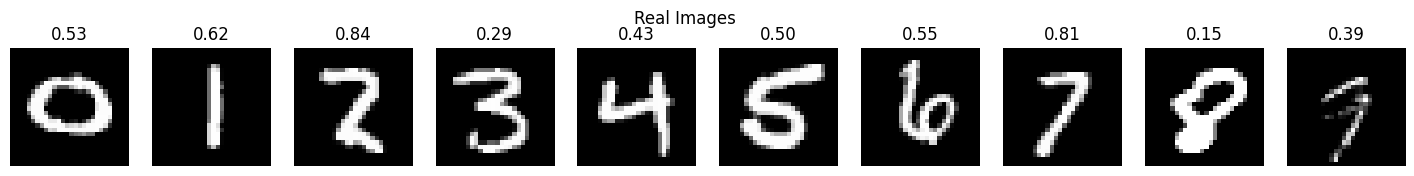

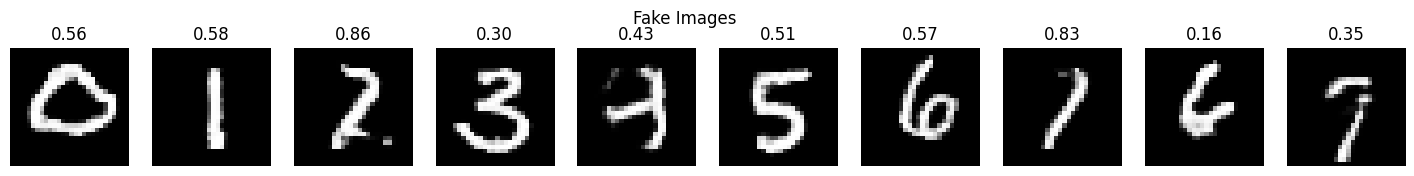

600/600 [==============================] - 115s 192ms/step - g_loss: 0.7009 - g_total_loss: 0.7090 - d_loss: 0.6893 - f_acc: 0.4969 - r_acc: 0.5026
Epoch 25/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7013 - g_total_loss: 0.7096 - d_loss: 0.6891 - f_acc: 0.4967 - r_acc: 0.5027

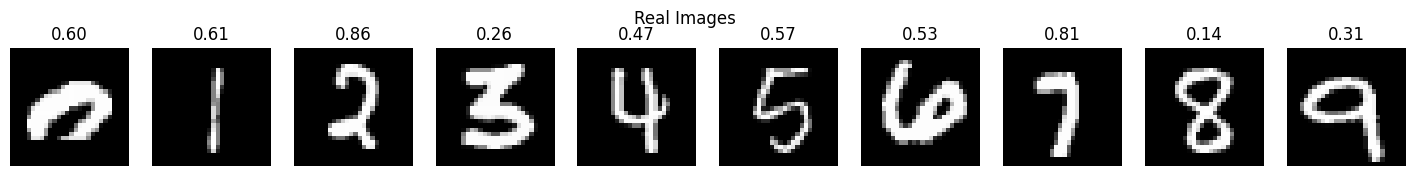

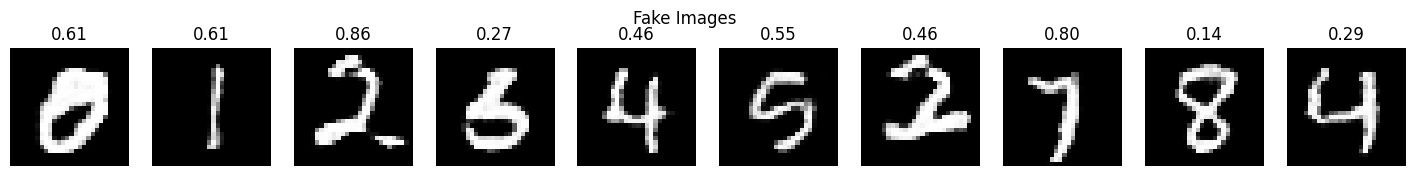

600/600 [==============================] - 117s 194ms/step - g_loss: 0.7013 - g_total_loss: 0.7096 - d_loss: 0.6891 - f_acc: 0.4967 - r_acc: 0.5027
Epoch 26/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7018 - g_total_loss: 0.7102 - d_loss: 0.6890 - f_acc: 0.4964 - r_acc: 0.5027

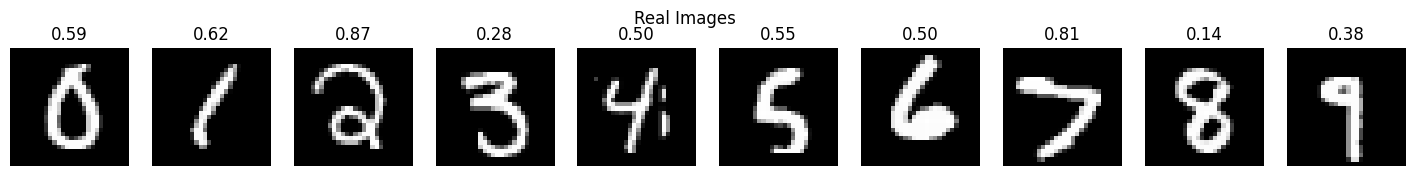

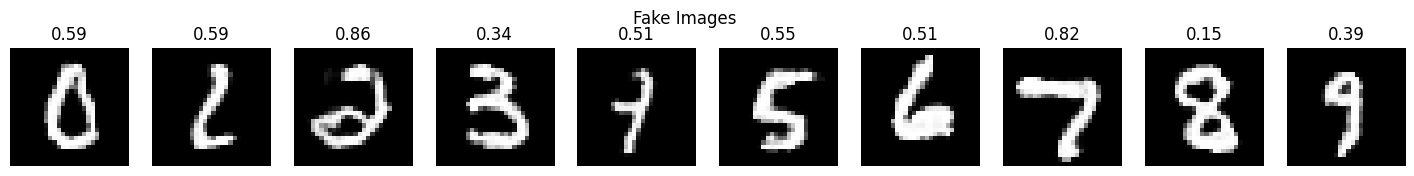

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7018 - g_total_loss: 0.7102 - d_loss: 0.6890 - f_acc: 0.4964 - r_acc: 0.5027
Epoch 27/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7018 - g_total_loss: 0.7102 - d_loss: 0.6884 - f_acc: 0.4965 - r_acc: 0.5033

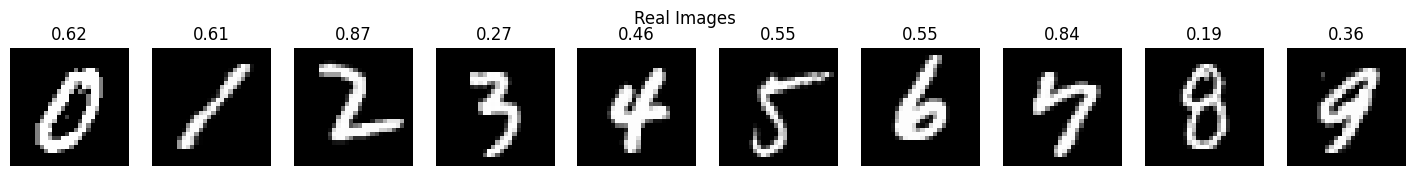

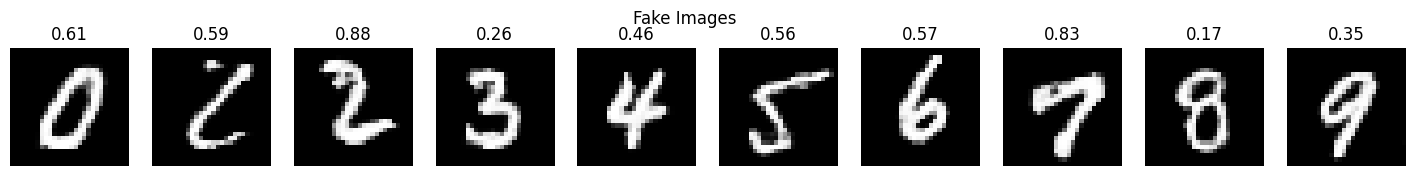

600/600 [==============================] - 115s 192ms/step - g_loss: 0.7018 - g_total_loss: 0.7102 - d_loss: 0.6884 - f_acc: 0.4965 - r_acc: 0.5033
Epoch 28/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7025 - g_total_loss: 0.7105 - d_loss: 0.6881 - f_acc: 0.4962 - r_acc: 0.5032

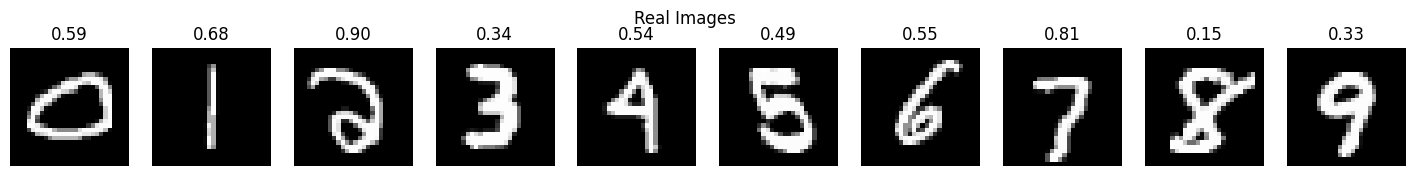

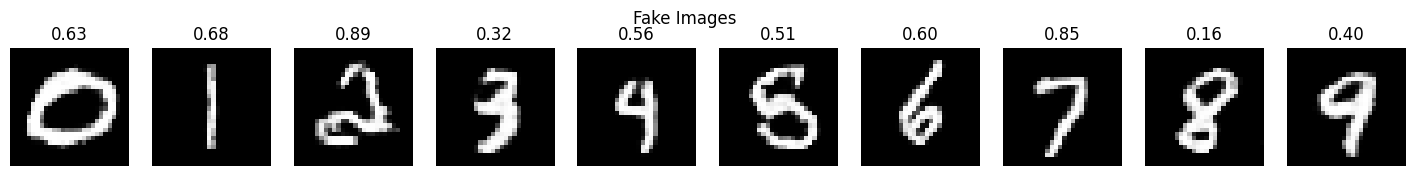

600/600 [==============================] - 118s 196ms/step - g_loss: 0.7025 - g_total_loss: 0.7105 - d_loss: 0.6881 - f_acc: 0.4962 - r_acc: 0.5032
Epoch 29/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7020 - g_total_loss: 0.7104 - d_loss: 0.6886 - f_acc: 0.4965 - r_acc: 0.5031

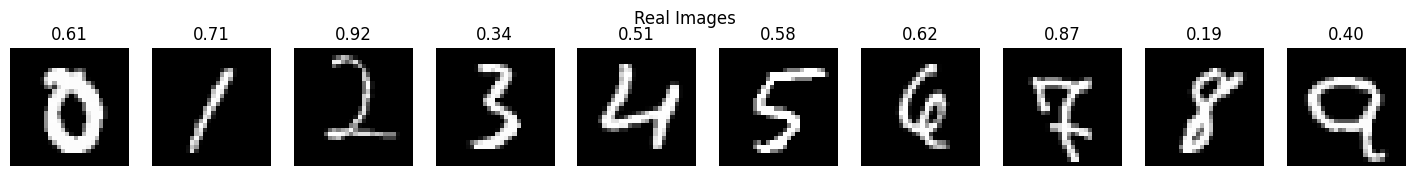

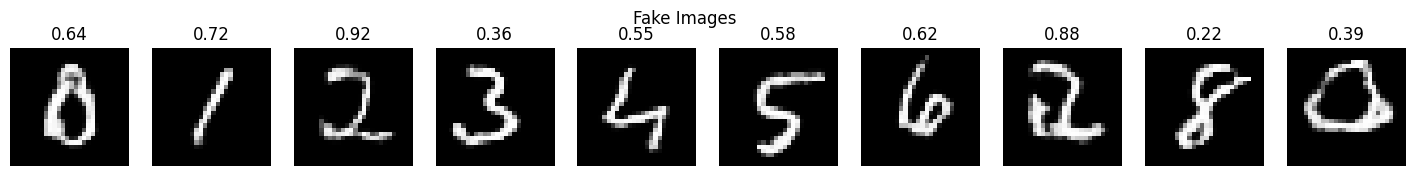

600/600 [==============================] - 117s 196ms/step - g_loss: 0.7020 - g_total_loss: 0.7104 - d_loss: 0.6886 - f_acc: 0.4965 - r_acc: 0.5031
Epoch 30/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7021 - g_total_loss: 0.7105 - d_loss: 0.6883 - f_acc: 0.4965 - r_acc: 0.5033

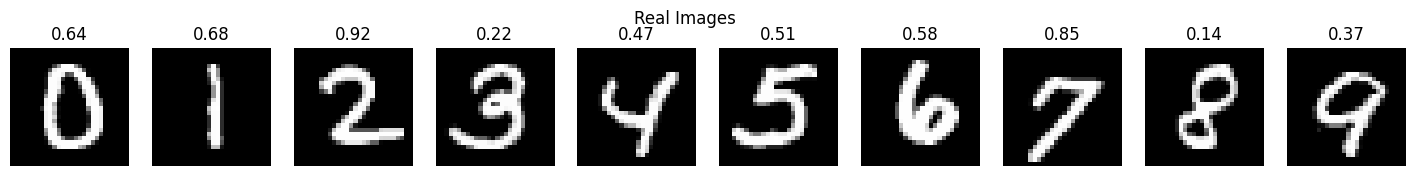

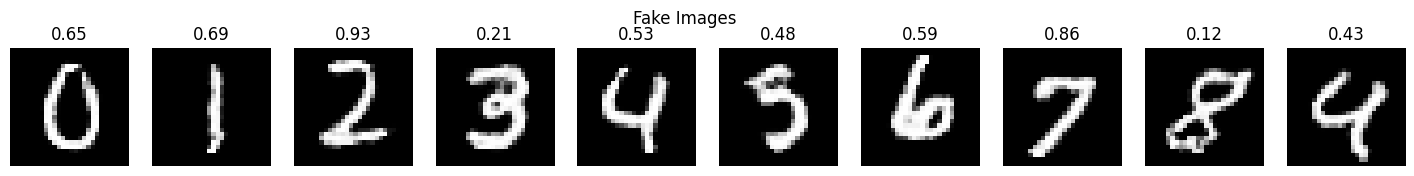

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7021 - g_total_loss: 0.7105 - d_loss: 0.6883 - f_acc: 0.4965 - r_acc: 0.5033
Epoch 31/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7029 - g_total_loss: 0.7106 - d_loss: 0.6876 - f_acc: 0.4961 - r_acc: 0.5036

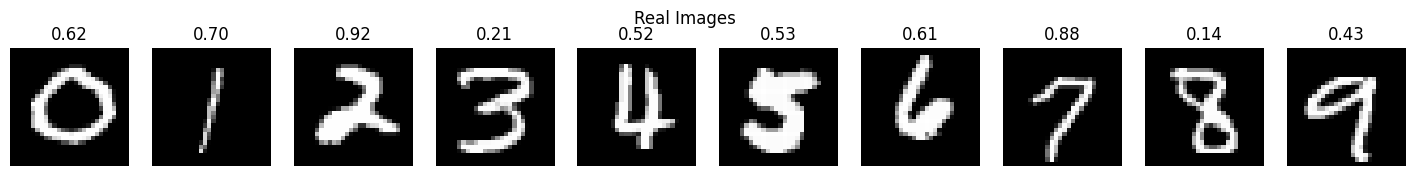

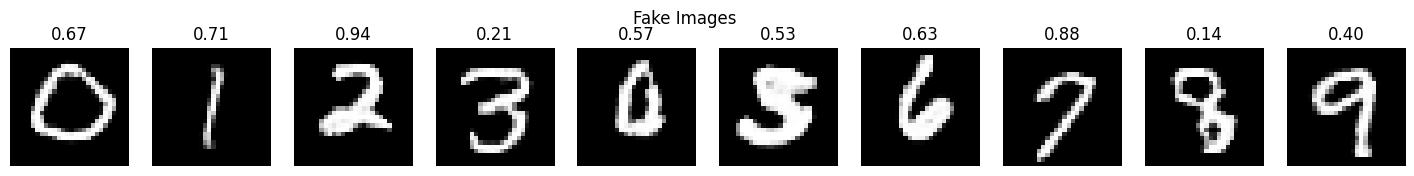

600/600 [==============================] - 116s 193ms/step - g_loss: 0.7029 - g_total_loss: 0.7106 - d_loss: 0.6876 - f_acc: 0.4961 - r_acc: 0.5036
Epoch 32/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7033 - g_total_loss: 0.7116 - d_loss: 0.6879 - f_acc: 0.4960 - r_acc: 0.5036

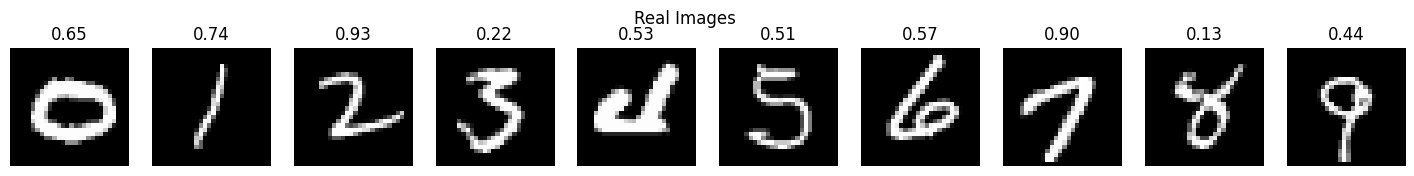

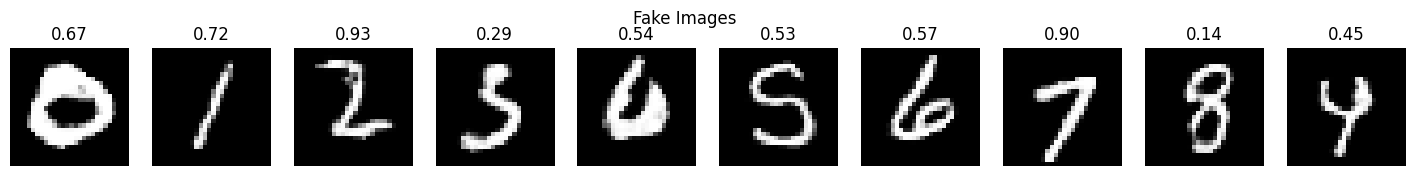

600/600 [==============================] - 119s 199ms/step - g_loss: 0.7033 - g_total_loss: 0.7116 - d_loss: 0.6879 - f_acc: 0.4960 - r_acc: 0.5036
Epoch 33/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7037 - g_total_loss: 0.7118 - d_loss: 0.6877 - f_acc: 0.4958 - r_acc: 0.5036

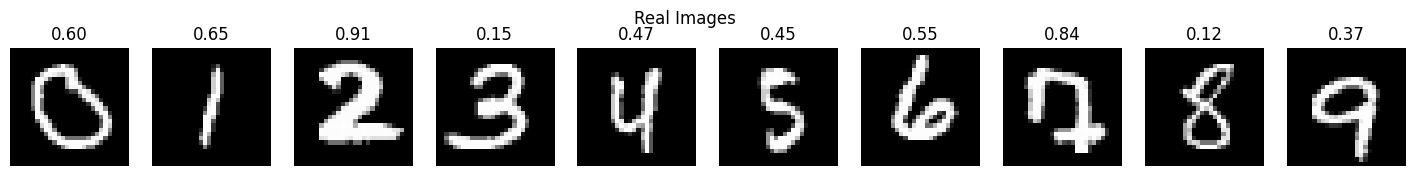

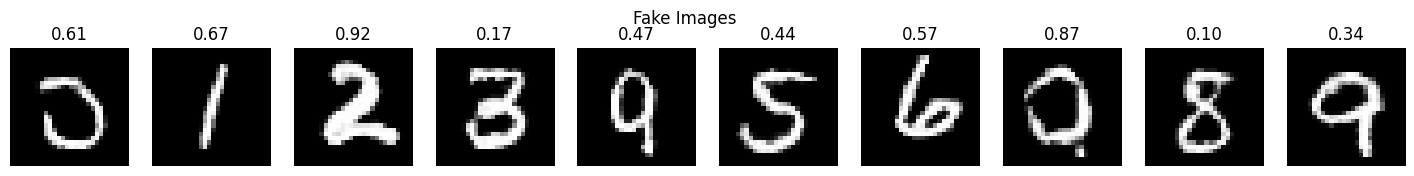

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7037 - g_total_loss: 0.7118 - d_loss: 0.6877 - f_acc: 0.4958 - r_acc: 0.5036
Epoch 34/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7038 - g_total_loss: 0.7124 - d_loss: 0.6876 - f_acc: 0.4959 - r_acc: 0.5039

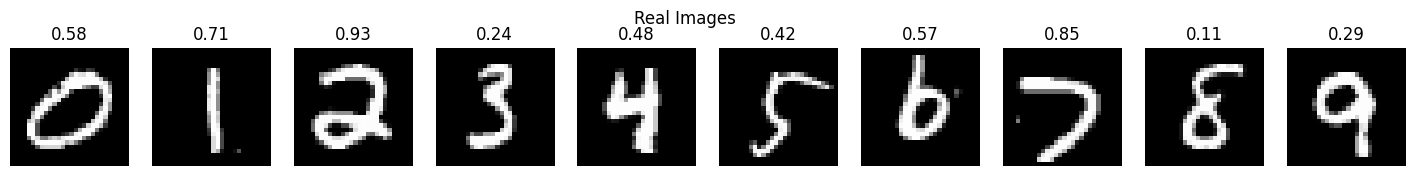

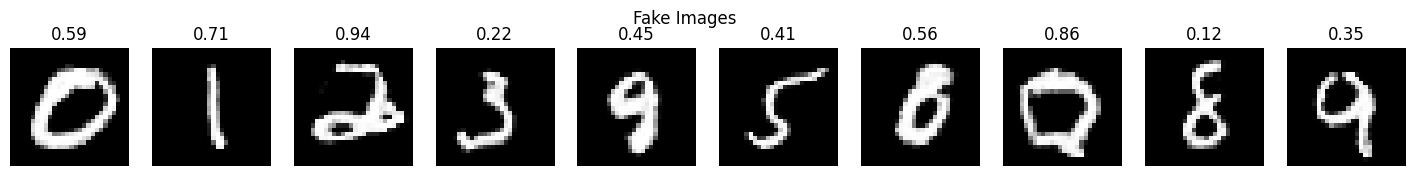

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7038 - g_total_loss: 0.7124 - d_loss: 0.6876 - f_acc: 0.4959 - r_acc: 0.5039
Epoch 35/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7033 - g_total_loss: 0.7115 - d_loss: 0.6876 - f_acc: 0.4960 - r_acc: 0.5039

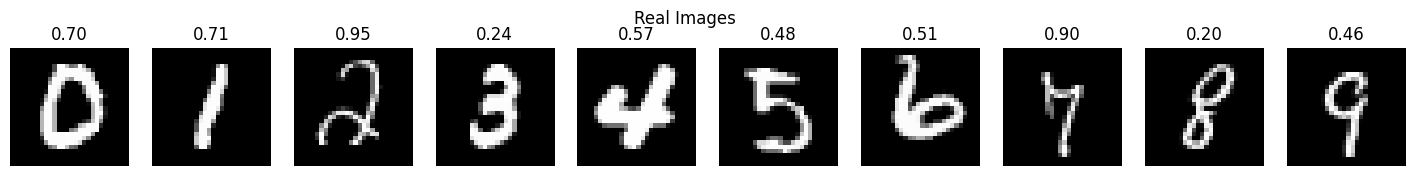

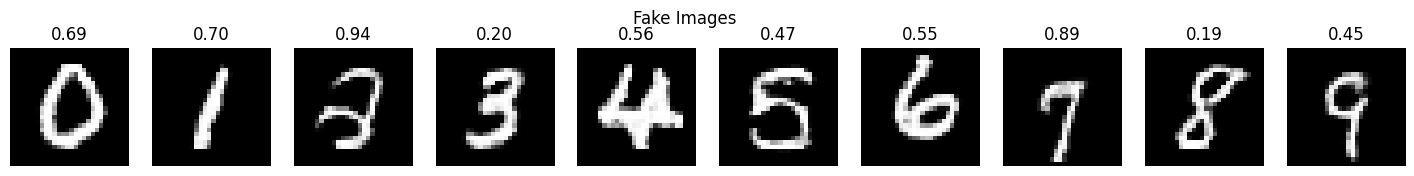

600/600 [==============================] - 118s 197ms/step - g_loss: 0.7033 - g_total_loss: 0.7115 - d_loss: 0.6876 - f_acc: 0.4960 - r_acc: 0.5039
Epoch 36/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7038 - g_total_loss: 0.7119 - d_loss: 0.6874 - f_acc: 0.4958 - r_acc: 0.5039

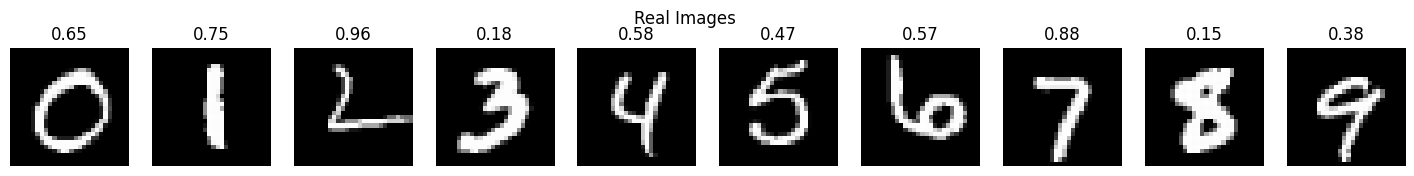

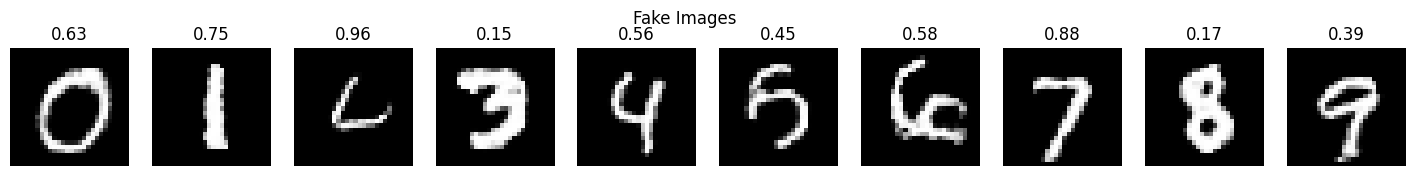

600/600 [==============================] - 116s 193ms/step - g_loss: 0.7038 - g_total_loss: 0.7119 - d_loss: 0.6874 - f_acc: 0.4958 - r_acc: 0.5039
Epoch 37/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7039 - g_total_loss: 0.7119 - d_loss: 0.6873 - f_acc: 0.4958 - r_acc: 0.5040

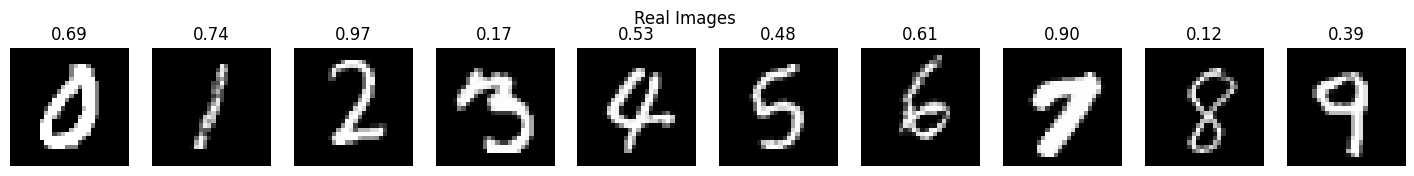

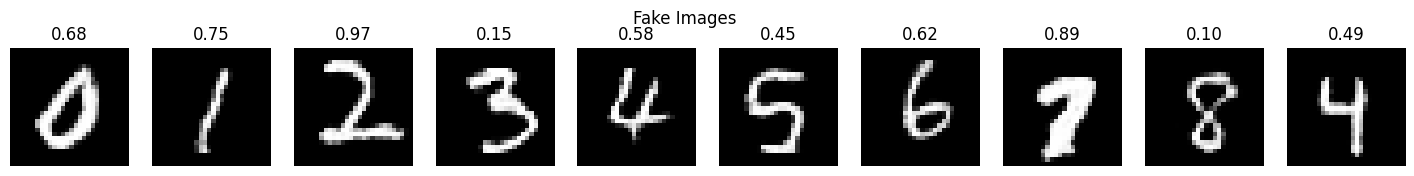

600/600 [==============================] - 119s 198ms/step - g_loss: 0.7039 - g_total_loss: 0.7119 - d_loss: 0.6873 - f_acc: 0.4958 - r_acc: 0.5040
Epoch 38/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7043 - g_total_loss: 0.7125 - d_loss: 0.6874 - f_acc: 0.4957 - r_acc: 0.5040

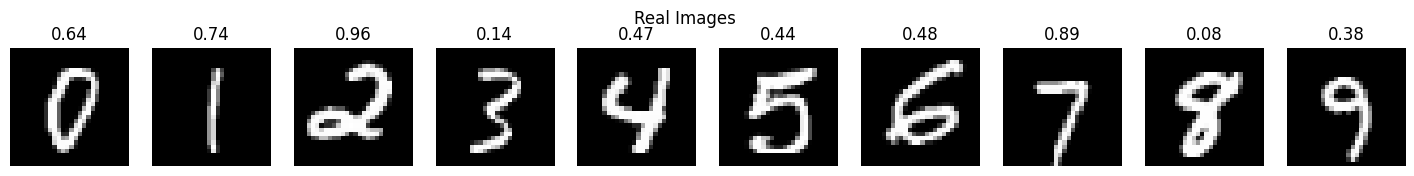

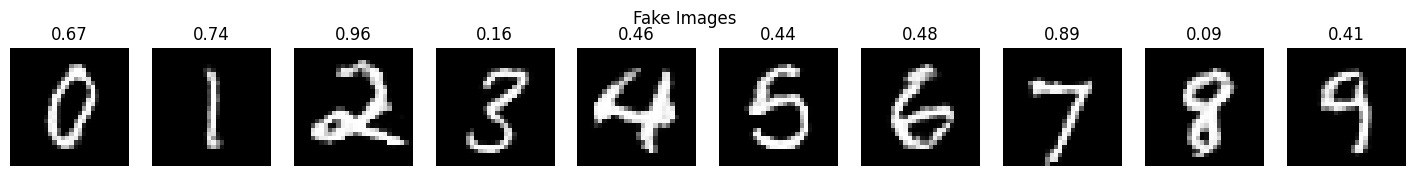

600/600 [==============================] - 119s 198ms/step - g_loss: 0.7043 - g_total_loss: 0.7125 - d_loss: 0.6874 - f_acc: 0.4957 - r_acc: 0.5040
Epoch 39/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7039 - g_total_loss: 0.7118 - d_loss: 0.6872 - f_acc: 0.4958 - r_acc: 0.5041

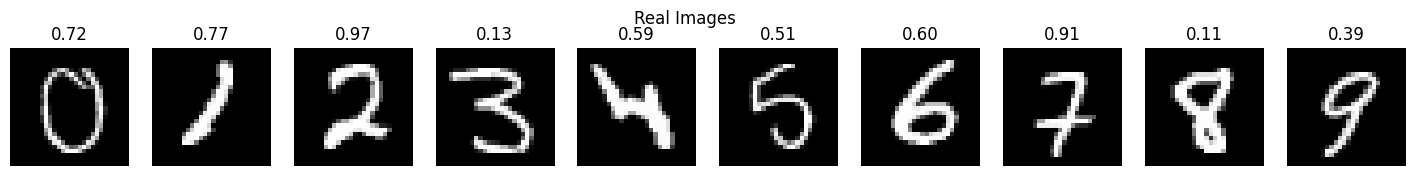

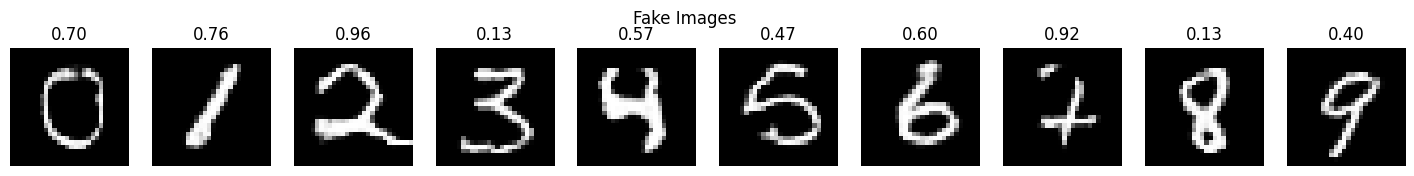

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7039 - g_total_loss: 0.7118 - d_loss: 0.6872 - f_acc: 0.4958 - r_acc: 0.5041
Epoch 40/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7048 - g_total_loss: 0.7127 - d_loss: 0.6866 - f_acc: 0.4954 - r_acc: 0.5043

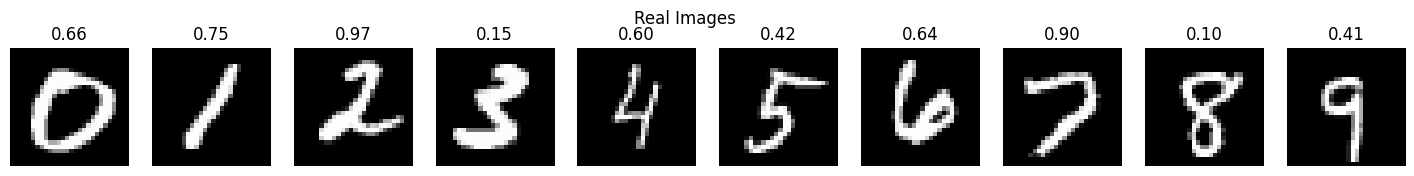

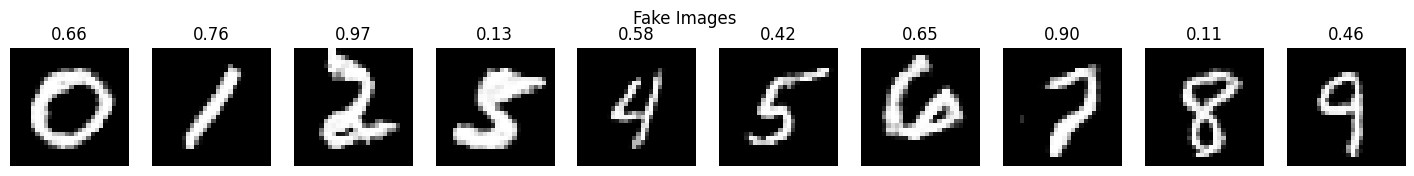

600/600 [==============================] - 117s 196ms/step - g_loss: 0.7048 - g_total_loss: 0.7127 - d_loss: 0.6866 - f_acc: 0.4954 - r_acc: 0.5043
Epoch 41/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7052 - g_total_loss: 0.7137 - d_loss: 0.6871 - f_acc: 0.4954 - r_acc: 0.5042

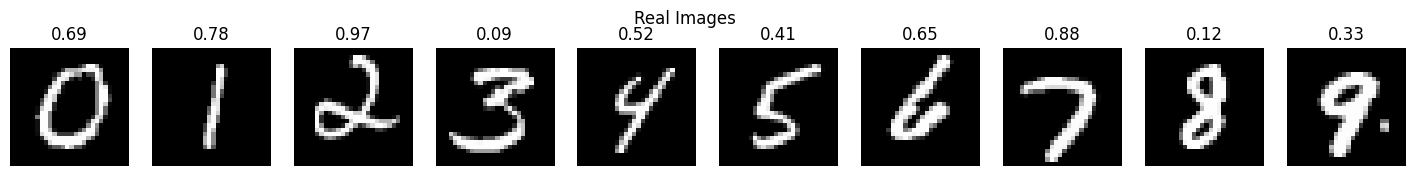

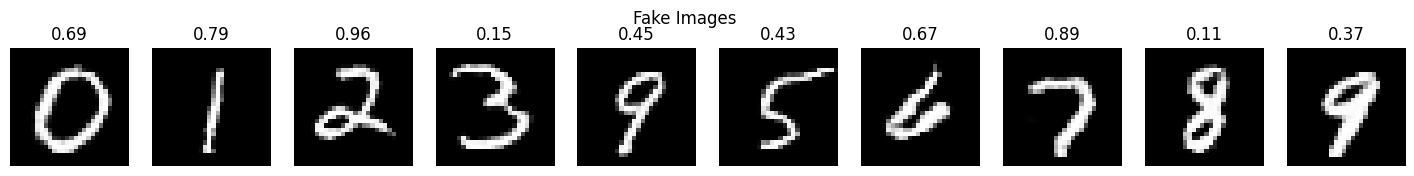

600/600 [==============================] - 118s 197ms/step - g_loss: 0.7052 - g_total_loss: 0.7137 - d_loss: 0.6871 - f_acc: 0.4954 - r_acc: 0.5042
Epoch 42/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7048 - g_total_loss: 0.7129 - d_loss: 0.6870 - f_acc: 0.4955 - r_acc: 0.5042

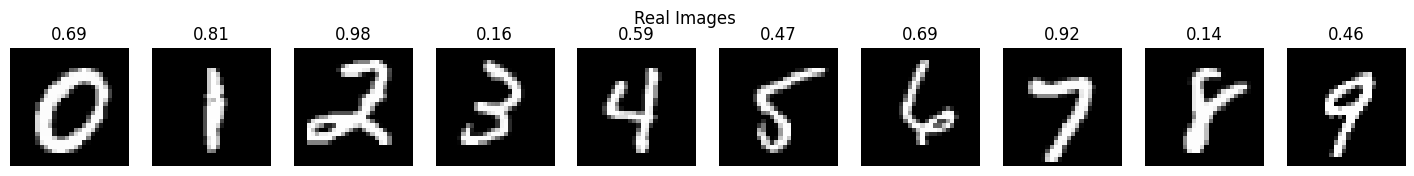

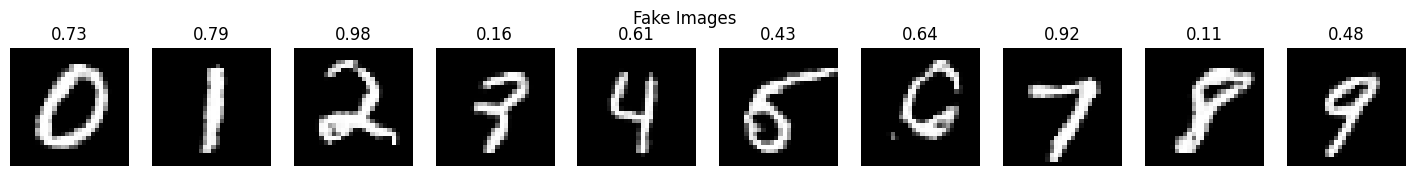

600/600 [==============================] - 119s 198ms/step - g_loss: 0.7048 - g_total_loss: 0.7129 - d_loss: 0.6870 - f_acc: 0.4955 - r_acc: 0.5042
Epoch 43/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7050 - g_total_loss: 0.7131 - d_loss: 0.6871 - f_acc: 0.4955 - r_acc: 0.5041

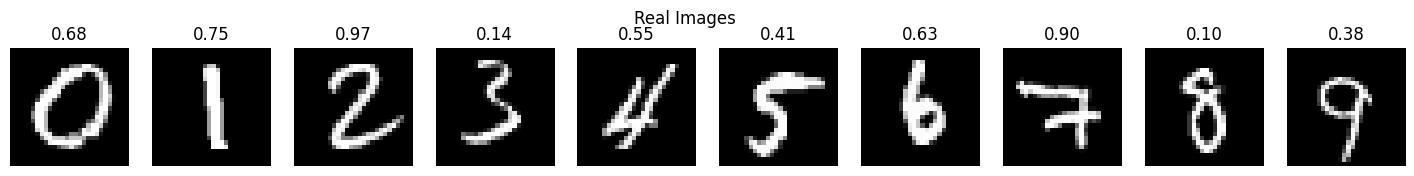

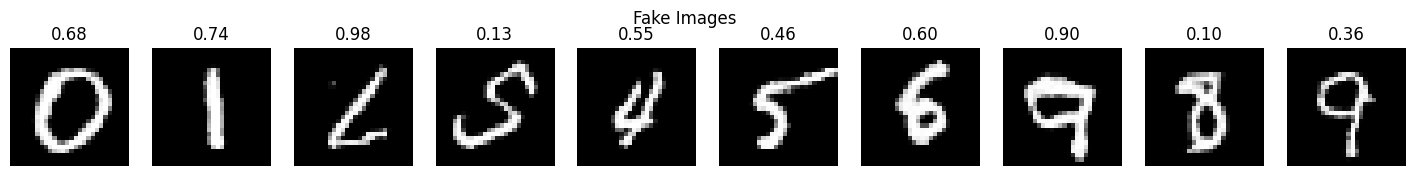

600/600 [==============================] - 119s 198ms/step - g_loss: 0.7050 - g_total_loss: 0.7131 - d_loss: 0.6871 - f_acc: 0.4955 - r_acc: 0.5041
Epoch 44/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7059 - g_total_loss: 0.7145 - d_loss: 0.6866 - f_acc: 0.4951 - r_acc: 0.5045

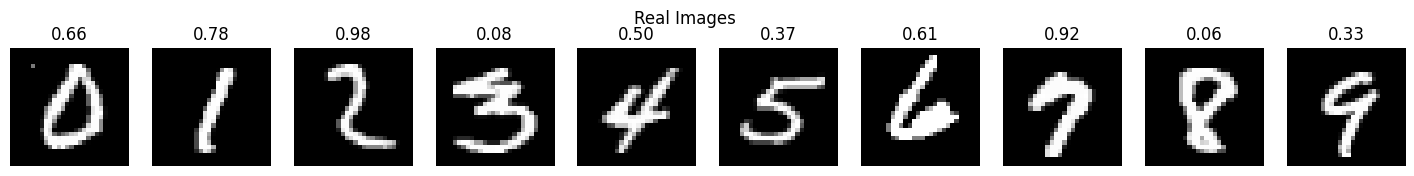

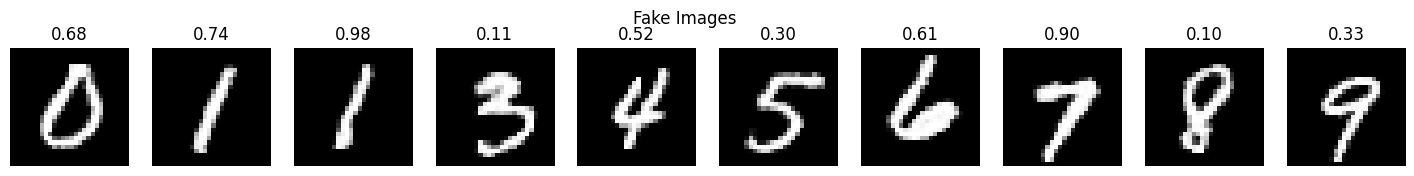

600/600 [==============================] - 120s 200ms/step - g_loss: 0.7059 - g_total_loss: 0.7145 - d_loss: 0.6866 - f_acc: 0.4951 - r_acc: 0.5045
Epoch 45/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7054 - g_total_loss: 0.7135 - d_loss: 0.6866 - f_acc: 0.4953 - r_acc: 0.5045

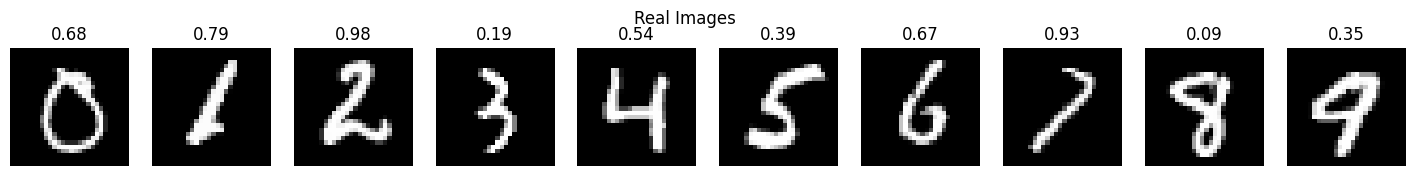

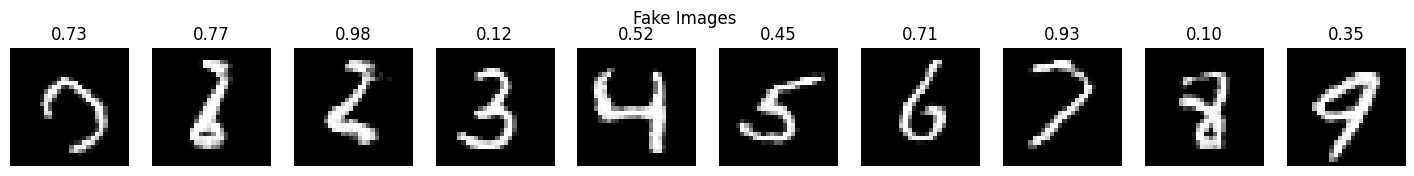

600/600 [==============================] - 118s 196ms/step - g_loss: 0.7054 - g_total_loss: 0.7135 - d_loss: 0.6866 - f_acc: 0.4953 - r_acc: 0.5045
Epoch 46/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7055 - g_total_loss: 0.7138 - d_loss: 0.6869 - f_acc: 0.4953 - r_acc: 0.5044

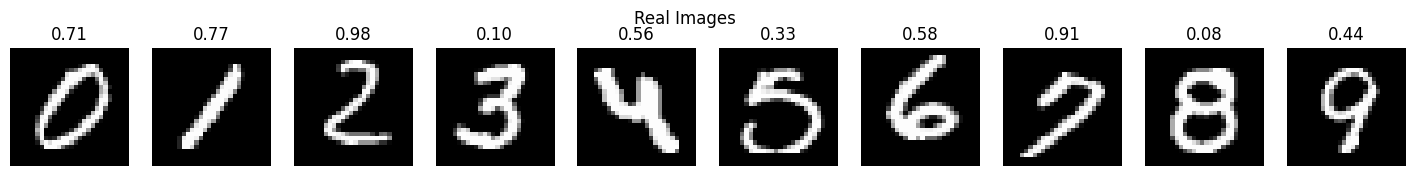

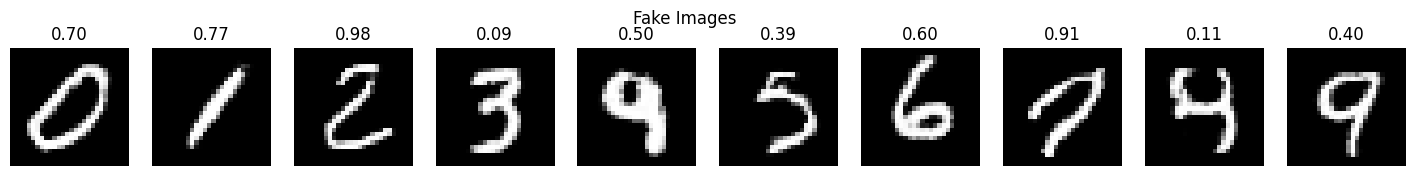

600/600 [==============================] - 119s 198ms/step - g_loss: 0.7055 - g_total_loss: 0.7138 - d_loss: 0.6869 - f_acc: 0.4953 - r_acc: 0.5044
Epoch 47/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7049 - g_total_loss: 0.7132 - d_loss: 0.6874 - f_acc: 0.4957 - r_acc: 0.5042

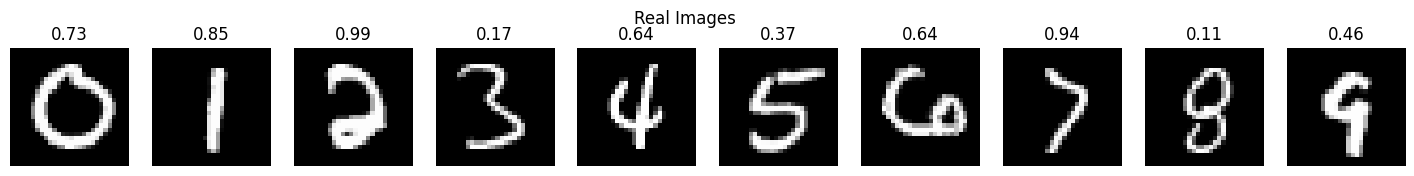

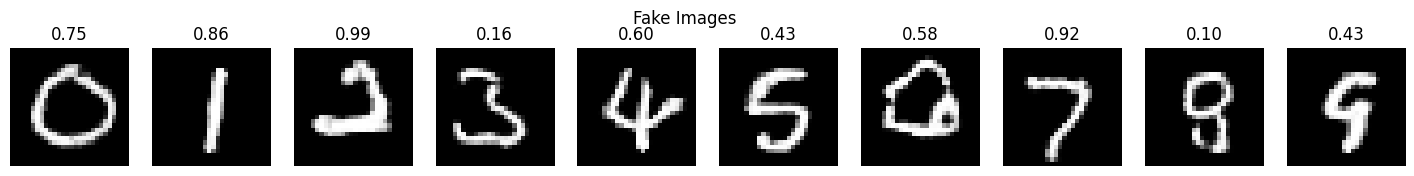

600/600 [==============================] - 116s 194ms/step - g_loss: 0.7049 - g_total_loss: 0.7132 - d_loss: 0.6874 - f_acc: 0.4957 - r_acc: 0.5042
Epoch 48/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7050 - g_total_loss: 0.7129 - d_loss: 0.6871 - f_acc: 0.4955 - r_acc: 0.5042

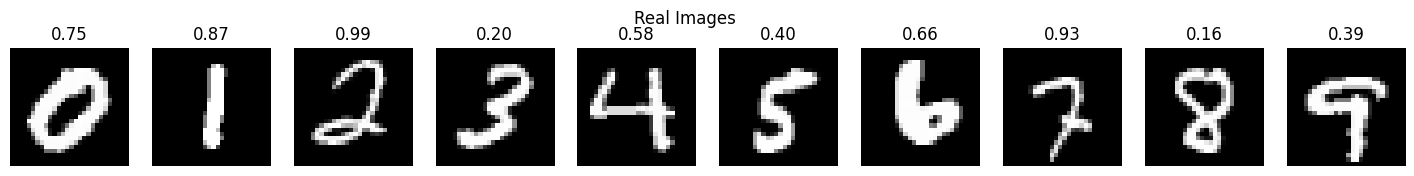

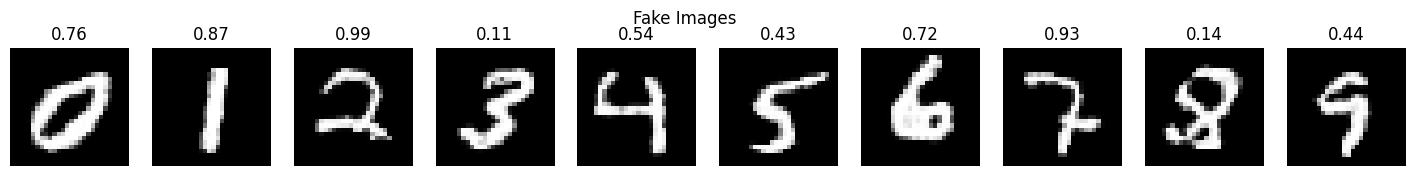

600/600 [==============================] - 118s 197ms/step - g_loss: 0.7050 - g_total_loss: 0.7129 - d_loss: 0.6871 - f_acc: 0.4955 - r_acc: 0.5042
Epoch 49/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7047 - g_total_loss: 0.7128 - d_loss: 0.6876 - f_acc: 0.4957 - r_acc: 0.5040

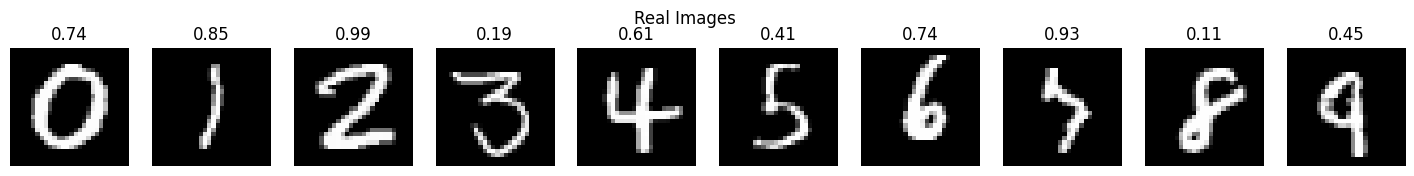

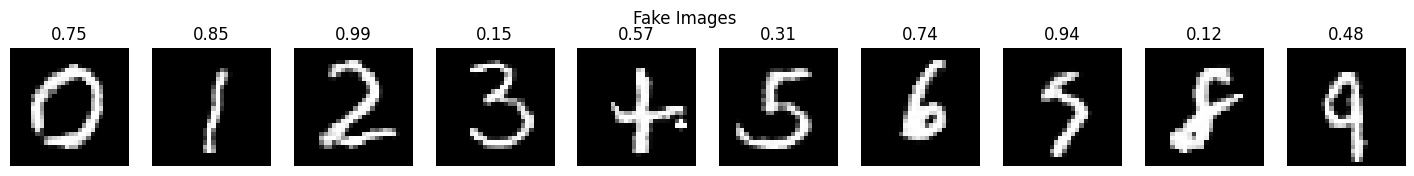

600/600 [==============================] - 115s 192ms/step - g_loss: 0.7047 - g_total_loss: 0.7128 - d_loss: 0.6876 - f_acc: 0.4957 - r_acc: 0.5040
Epoch 50/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7057 - g_total_loss: 0.7139 - d_loss: 0.6870 - f_acc: 0.4953 - r_acc: 0.5043

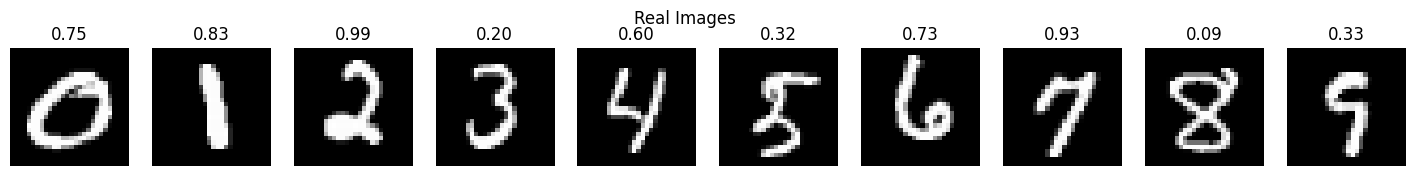

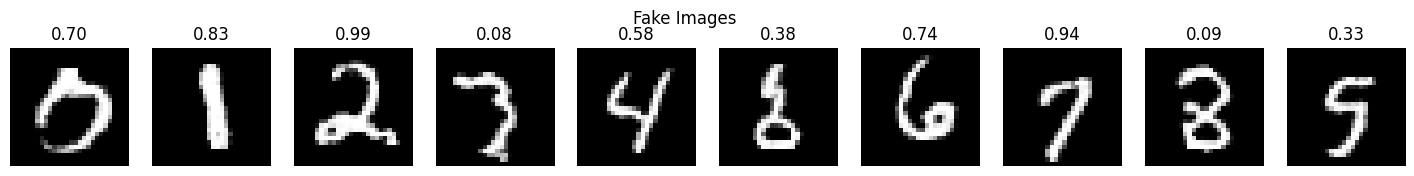

600/600 [==============================] - 115s 191ms/step - g_loss: 0.7057 - g_total_loss: 0.7139 - d_loss: 0.6870 - f_acc: 0.4953 - r_acc: 0.5043
Epoch 51/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7059 - g_total_loss: 0.7142 - d_loss: 0.6872 - f_acc: 0.4953 - r_acc: 0.5043

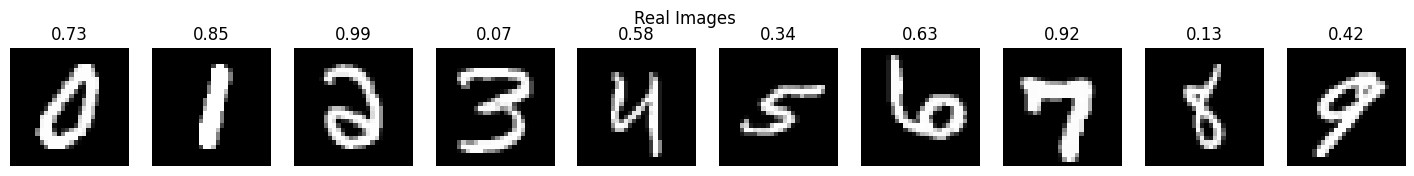

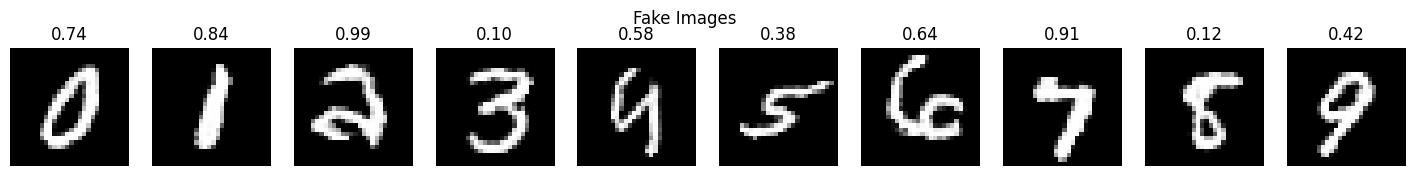

600/600 [==============================] - 115s 191ms/step - g_loss: 0.7059 - g_total_loss: 0.7142 - d_loss: 0.6872 - f_acc: 0.4953 - r_acc: 0.5043
Epoch 52/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7061 - g_total_loss: 0.7147 - d_loss: 0.6872 - f_acc: 0.4952 - r_acc: 0.5044

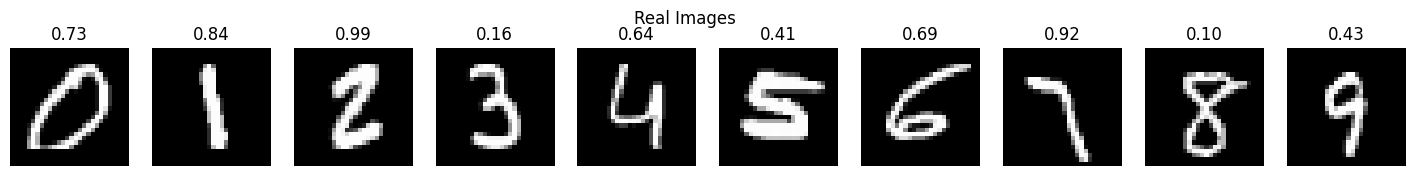

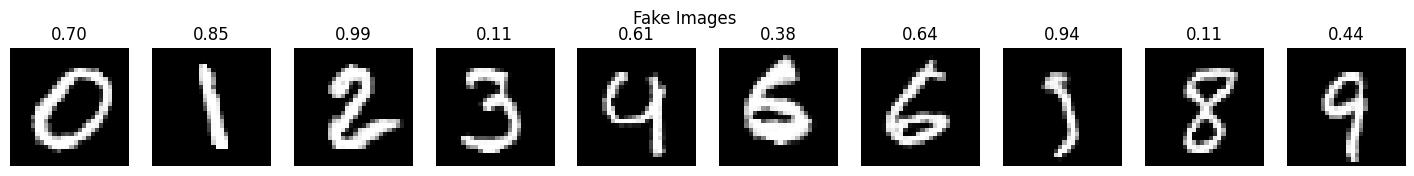

600/600 [==============================] - 114s 191ms/step - g_loss: 0.7061 - g_total_loss: 0.7147 - d_loss: 0.6872 - f_acc: 0.4952 - r_acc: 0.5044
Epoch 53/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7061 - g_total_loss: 0.7144 - d_loss: 0.6867 - f_acc: 0.4951 - r_acc: 0.5045

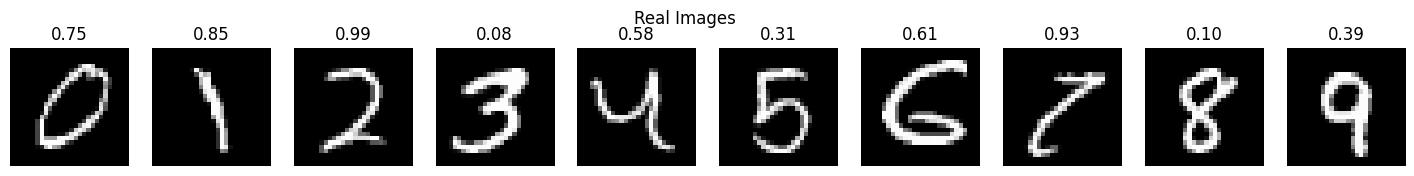

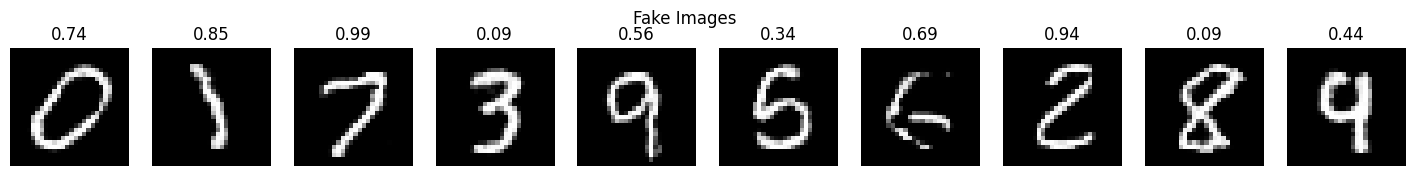

600/600 [==============================] - 114s 190ms/step - g_loss: 0.7061 - g_total_loss: 0.7144 - d_loss: 0.6867 - f_acc: 0.4951 - r_acc: 0.5045
Epoch 54/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7057 - g_total_loss: 0.7145 - d_loss: 0.6874 - f_acc: 0.4954 - r_acc: 0.5042

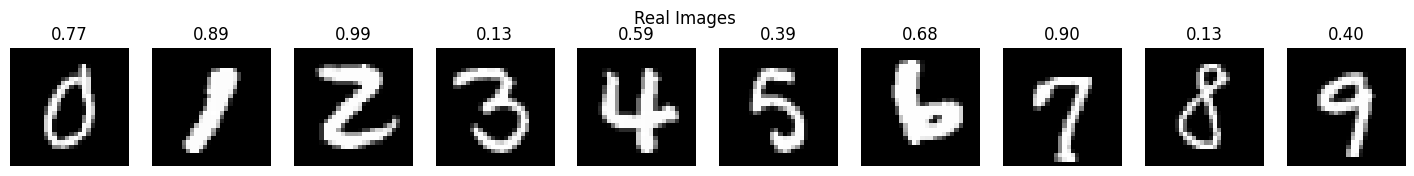

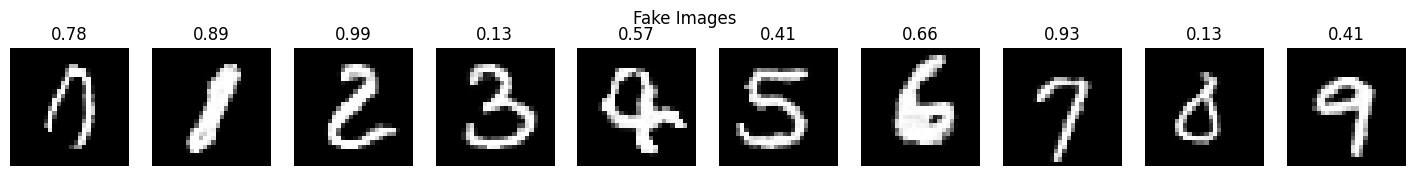

600/600 [==============================] - 115s 191ms/step - g_loss: 0.7057 - g_total_loss: 0.7145 - d_loss: 0.6874 - f_acc: 0.4954 - r_acc: 0.5042
Epoch 55/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7056 - g_total_loss: 0.7137 - d_loss: 0.6869 - f_acc: 0.4954 - r_acc: 0.5045

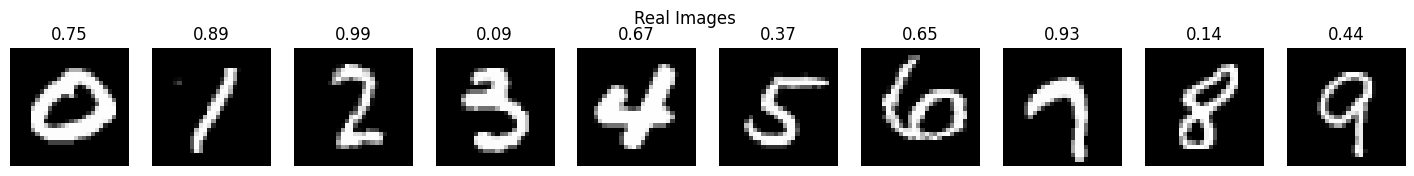

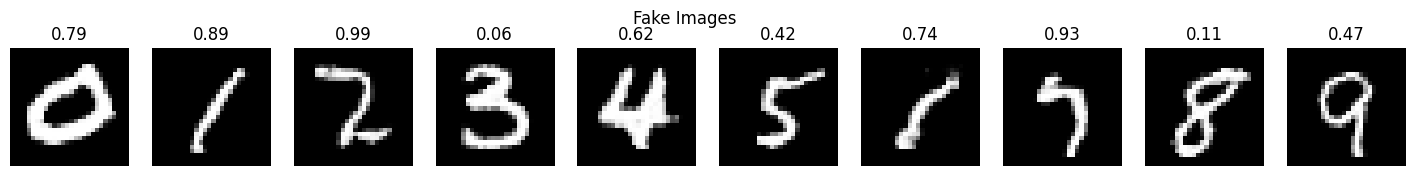

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7056 - g_total_loss: 0.7137 - d_loss: 0.6869 - f_acc: 0.4954 - r_acc: 0.5045
Epoch 56/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7059 - g_total_loss: 0.7141 - d_loss: 0.6868 - f_acc: 0.4953 - r_acc: 0.5046

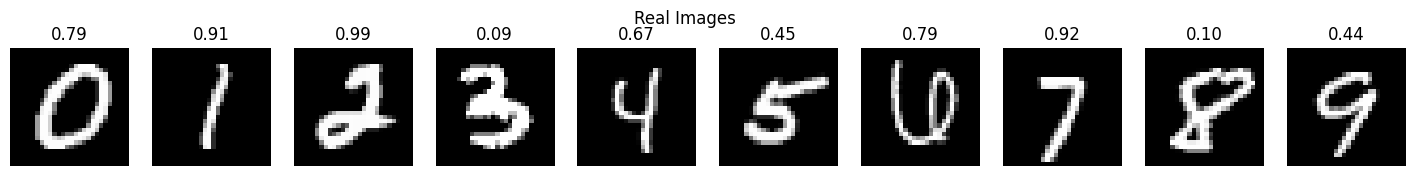

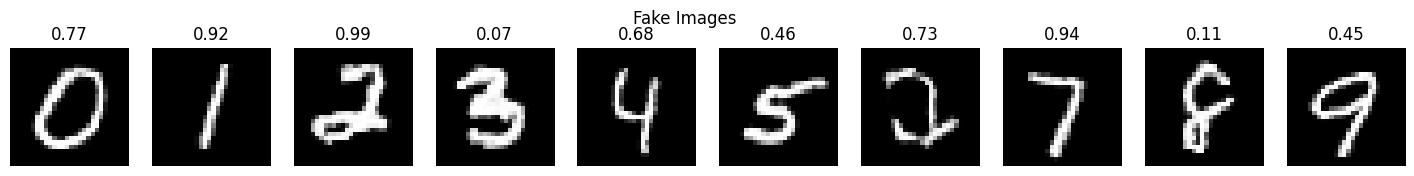

600/600 [==============================] - 115s 192ms/step - g_loss: 0.7059 - g_total_loss: 0.7141 - d_loss: 0.6868 - f_acc: 0.4953 - r_acc: 0.5046
Epoch 57/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7055 - g_total_loss: 0.7139 - d_loss: 0.6872 - f_acc: 0.4955 - r_acc: 0.5044

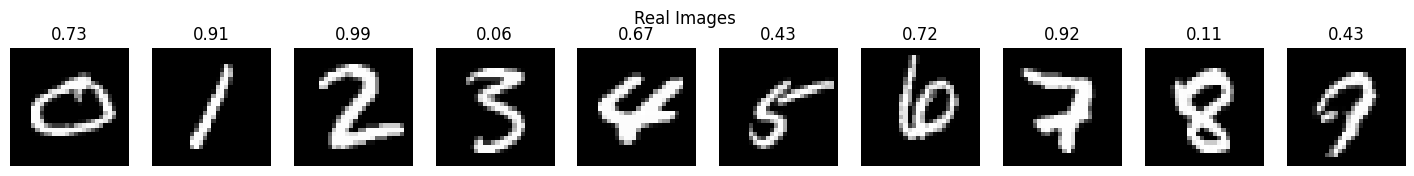

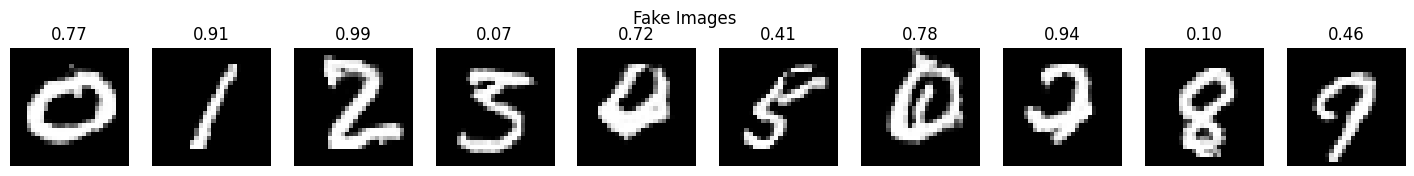

600/600 [==============================] - 114s 190ms/step - g_loss: 0.7055 - g_total_loss: 0.7139 - d_loss: 0.6872 - f_acc: 0.4955 - r_acc: 0.5044
Epoch 58/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7062 - g_total_loss: 0.7147 - d_loss: 0.6873 - f_acc: 0.4953 - r_acc: 0.5044

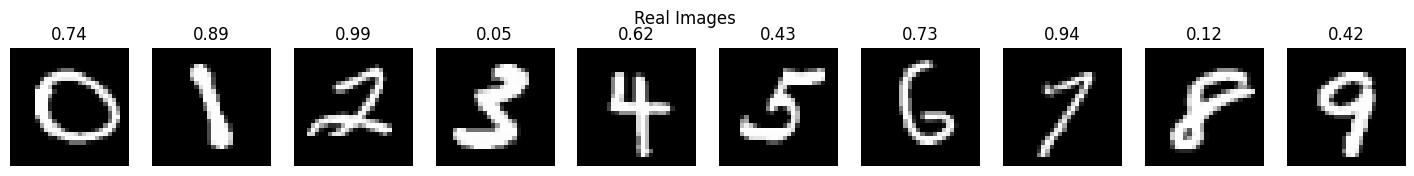

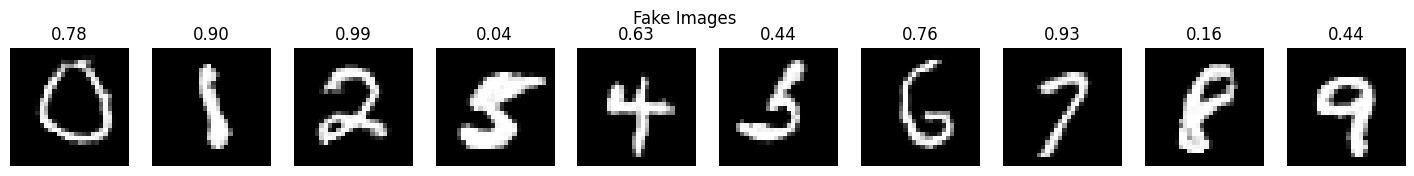

600/600 [==============================] - 114s 189ms/step - g_loss: 0.7062 - g_total_loss: 0.7147 - d_loss: 0.6873 - f_acc: 0.4953 - r_acc: 0.5044
Epoch 59/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7059 - g_total_loss: 0.7142 - d_loss: 0.6873 - f_acc: 0.4954 - r_acc: 0.5043

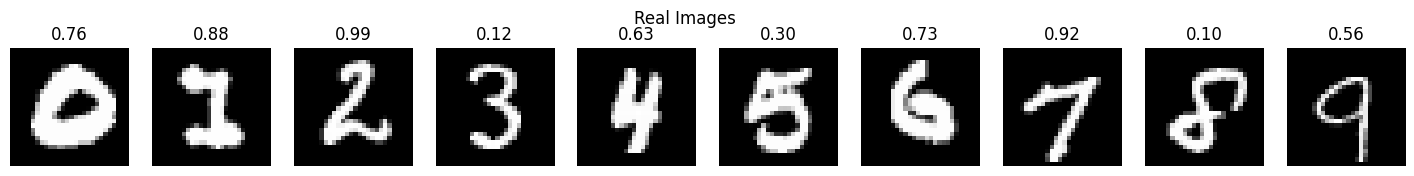

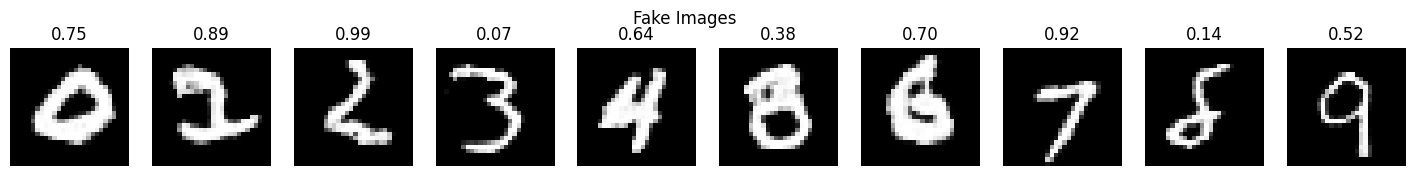

600/600 [==============================] - 114s 190ms/step - g_loss: 0.7059 - g_total_loss: 0.7142 - d_loss: 0.6873 - f_acc: 0.4954 - r_acc: 0.5043
Epoch 60/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7062 - g_total_loss: 0.7145 - d_loss: 0.6872 - f_acc: 0.4953 - r_acc: 0.5045

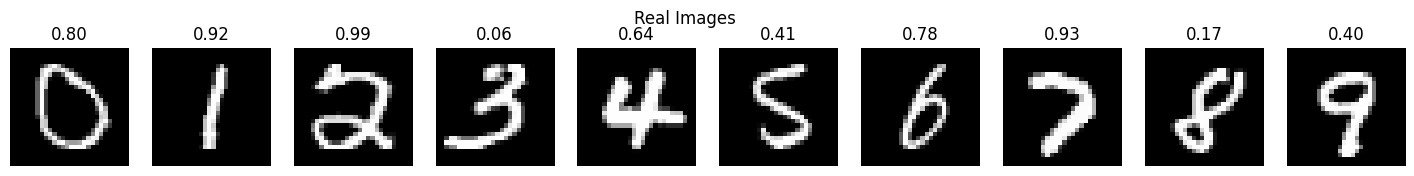

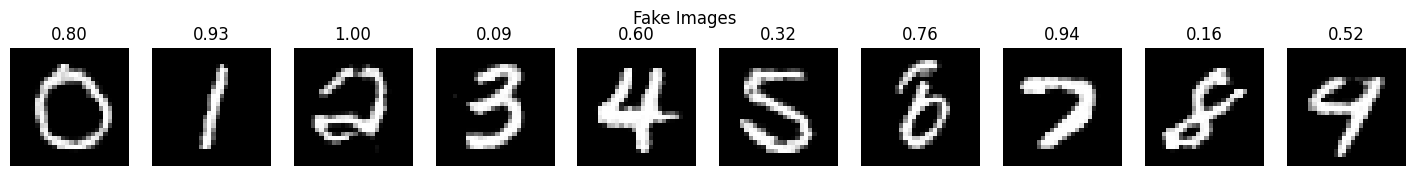

600/600 [==============================] - 113s 189ms/step - g_loss: 0.7062 - g_total_loss: 0.7145 - d_loss: 0.6872 - f_acc: 0.4953 - r_acc: 0.5045
Epoch 61/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7061 - g_total_loss: 0.7145 - d_loss: 0.6875 - f_acc: 0.4953 - r_acc: 0.5041

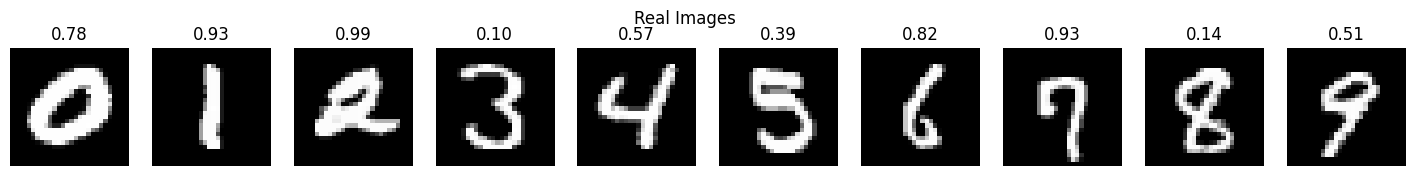

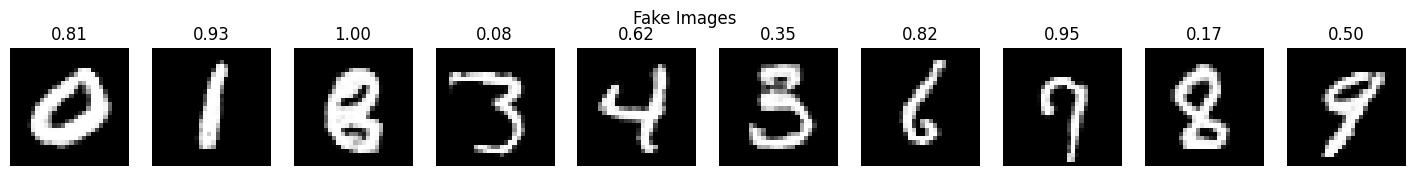

600/600 [==============================] - 113s 189ms/step - g_loss: 0.7061 - g_total_loss: 0.7145 - d_loss: 0.6875 - f_acc: 0.4953 - r_acc: 0.5041
Epoch 62/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7063 - g_total_loss: 0.7148 - d_loss: 0.6875 - f_acc: 0.4953 - r_acc: 0.5044

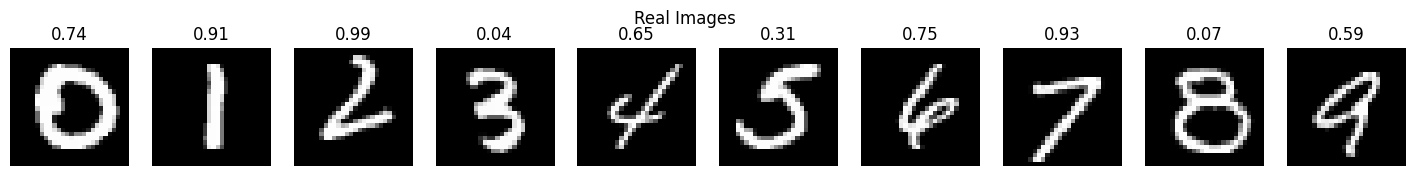

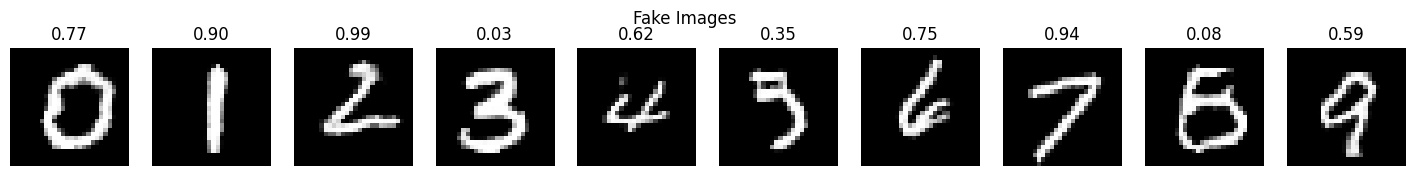

600/600 [==============================] - 116s 194ms/step - g_loss: 0.7063 - g_total_loss: 0.7148 - d_loss: 0.6875 - f_acc: 0.4953 - r_acc: 0.5044
Epoch 63/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7062 - g_total_loss: 0.7147 - d_loss: 0.6872 - f_acc: 0.4953 - r_acc: 0.5045

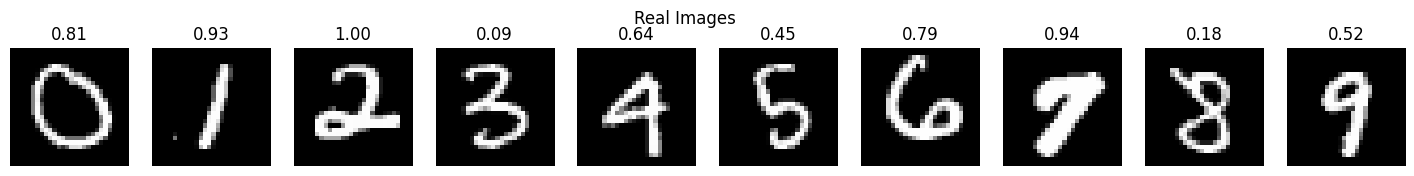

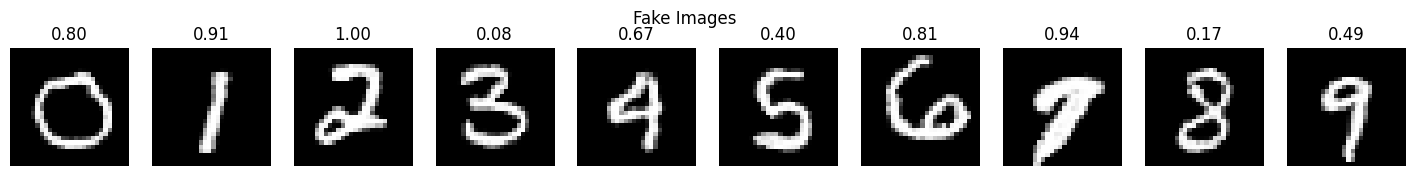

600/600 [==============================] - 114s 190ms/step - g_loss: 0.7062 - g_total_loss: 0.7147 - d_loss: 0.6872 - f_acc: 0.4953 - r_acc: 0.5045
Epoch 64/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7059 - g_total_loss: 0.7143 - d_loss: 0.6877 - f_acc: 0.4955 - r_acc: 0.5042

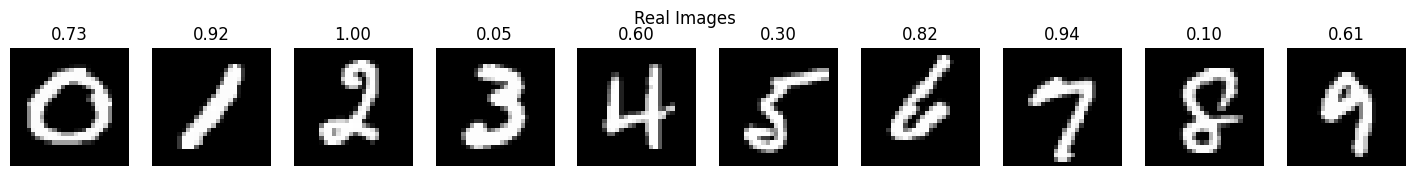

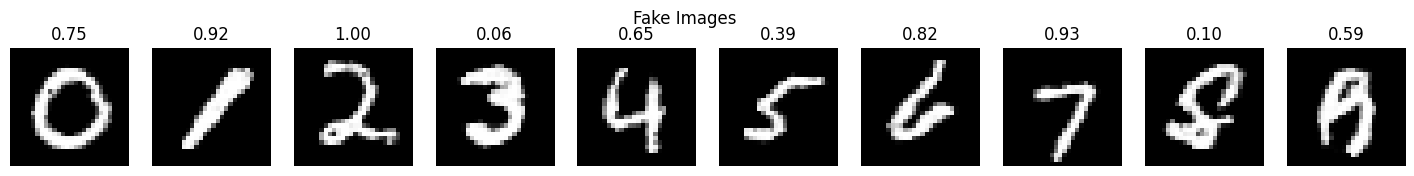

600/600 [==============================] - 113s 189ms/step - g_loss: 0.7059 - g_total_loss: 0.7143 - d_loss: 0.6877 - f_acc: 0.4955 - r_acc: 0.5042
Epoch 65/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7061 - g_total_loss: 0.7147 - d_loss: 0.6876 - f_acc: 0.4954 - r_acc: 0.5043

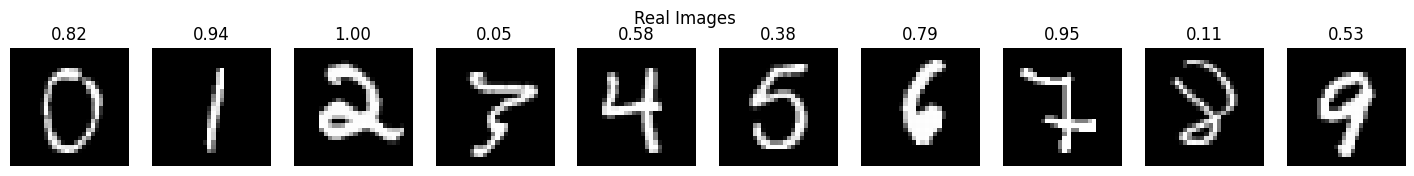

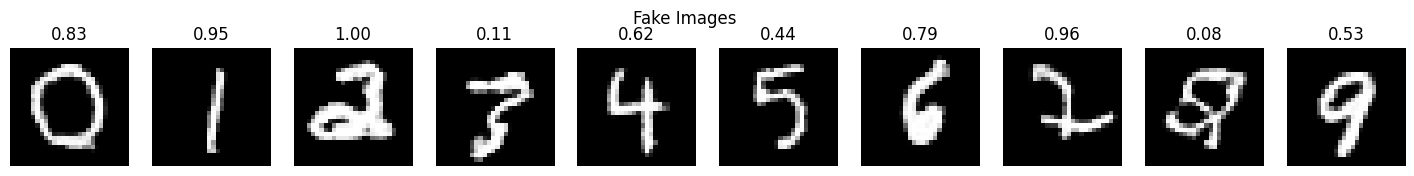

600/600 [==============================] - 113s 189ms/step - g_loss: 0.7061 - g_total_loss: 0.7147 - d_loss: 0.6876 - f_acc: 0.4954 - r_acc: 0.5043
Epoch 66/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7058 - g_total_loss: 0.7142 - d_loss: 0.6877 - f_acc: 0.4956 - r_acc: 0.5042

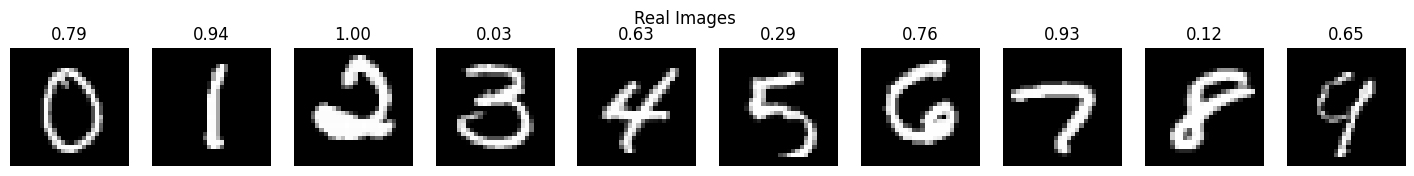

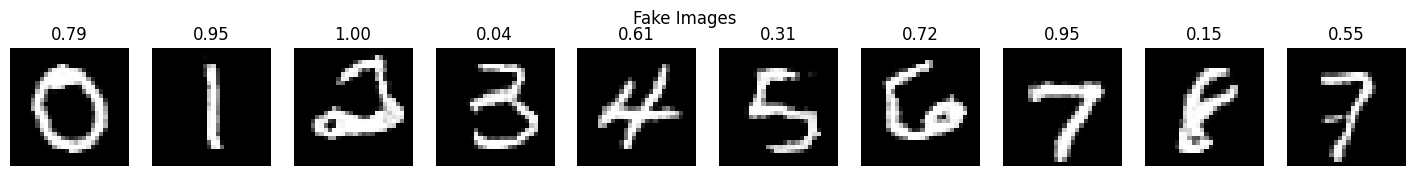

600/600 [==============================] - 116s 194ms/step - g_loss: 0.7058 - g_total_loss: 0.7142 - d_loss: 0.6877 - f_acc: 0.4956 - r_acc: 0.5042
Epoch 67/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7058 - g_total_loss: 0.7143 - d_loss: 0.6878 - f_acc: 0.4955 - r_acc: 0.5041

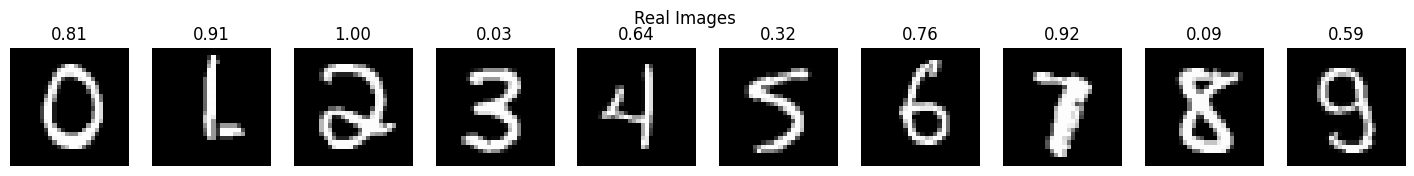

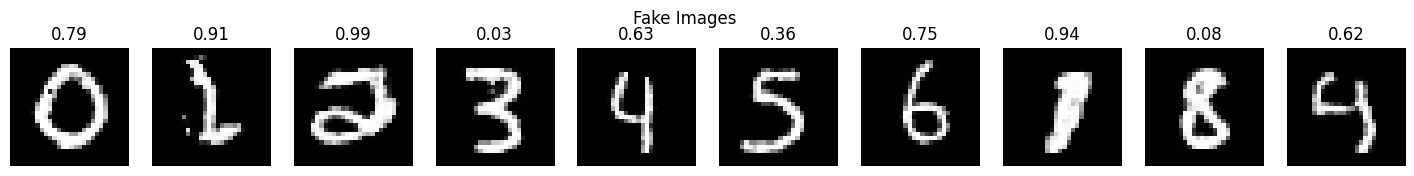

600/600 [==============================] - 114s 190ms/step - g_loss: 0.7058 - g_total_loss: 0.7143 - d_loss: 0.6878 - f_acc: 0.4955 - r_acc: 0.5041
Epoch 68/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7057 - g_total_loss: 0.7141 - d_loss: 0.6874 - f_acc: 0.4955 - r_acc: 0.5043

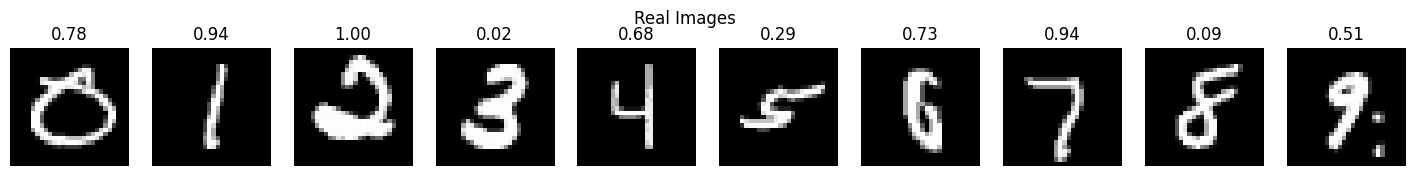

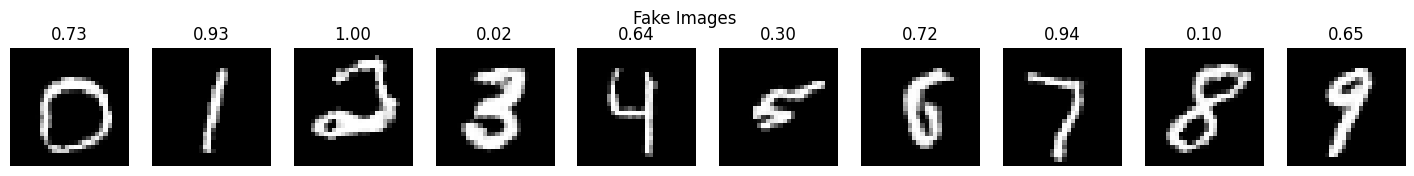

600/600 [==============================] - 114s 190ms/step - g_loss: 0.7057 - g_total_loss: 0.7141 - d_loss: 0.6874 - f_acc: 0.4955 - r_acc: 0.5043
Epoch 69/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7058 - g_total_loss: 0.7143 - d_loss: 0.6878 - f_acc: 0.4956 - r_acc: 0.5042

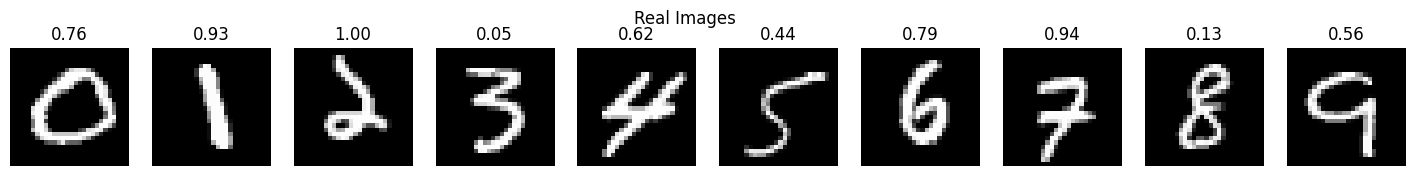

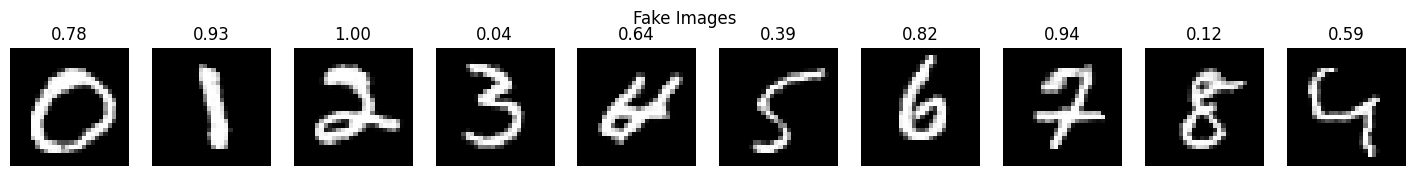

600/600 [==============================] - 113s 188ms/step - g_loss: 0.7058 - g_total_loss: 0.7143 - d_loss: 0.6878 - f_acc: 0.4956 - r_acc: 0.5042
Epoch 70/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7064 - g_total_loss: 0.7149 - d_loss: 0.6874 - f_acc: 0.4953 - r_acc: 0.5043

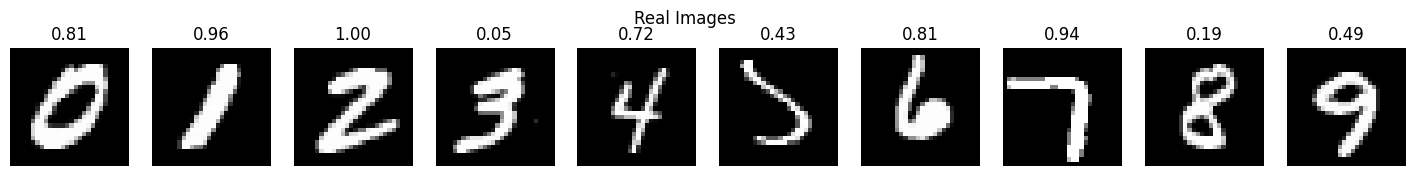

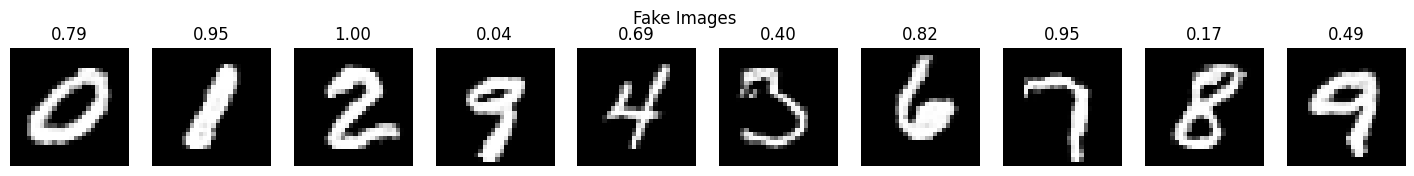

600/600 [==============================] - 113s 189ms/step - g_loss: 0.7064 - g_total_loss: 0.7149 - d_loss: 0.6874 - f_acc: 0.4953 - r_acc: 0.5043
Epoch 71/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7061 - g_total_loss: 0.7147 - d_loss: 0.6878 - f_acc: 0.4954 - r_acc: 0.5041

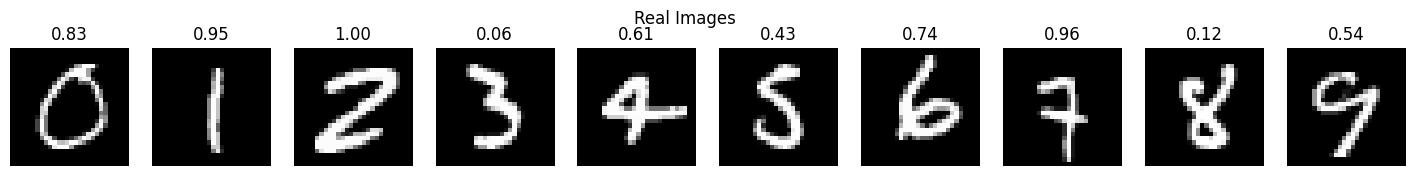

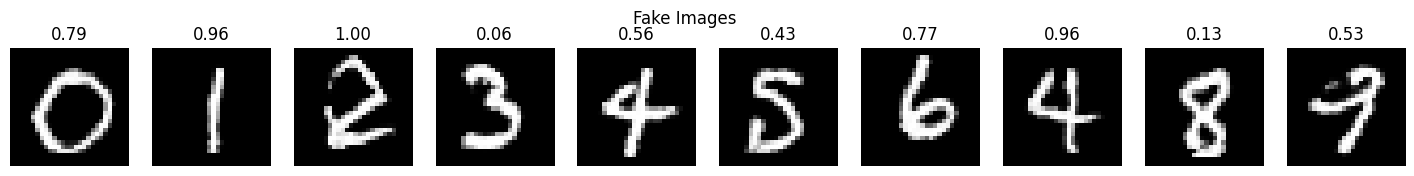

600/600 [==============================] - 113s 188ms/step - g_loss: 0.7061 - g_total_loss: 0.7147 - d_loss: 0.6878 - f_acc: 0.4954 - r_acc: 0.5041
Epoch 72/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7059 - g_total_loss: 0.7145 - d_loss: 0.6879 - f_acc: 0.4955 - r_acc: 0.5042

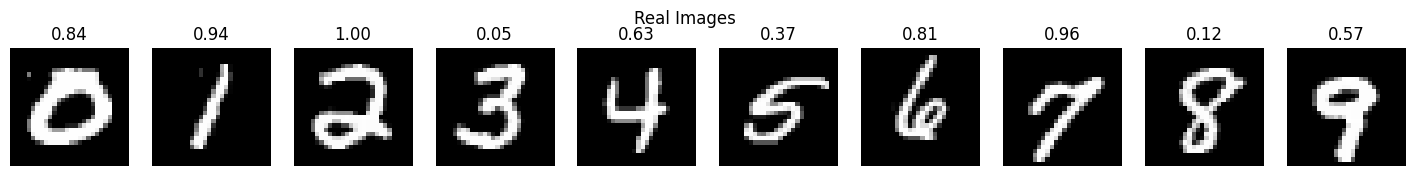

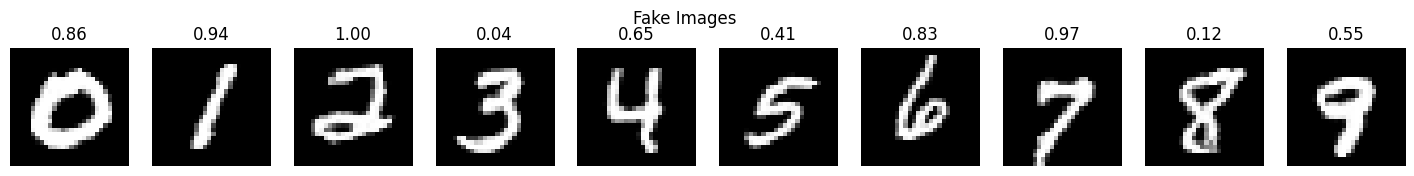

600/600 [==============================] - 115s 192ms/step - g_loss: 0.7059 - g_total_loss: 0.7145 - d_loss: 0.6879 - f_acc: 0.4955 - r_acc: 0.5042
Epoch 73/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7054 - g_total_loss: 0.7137 - d_loss: 0.6879 - f_acc: 0.4957 - r_acc: 0.5041

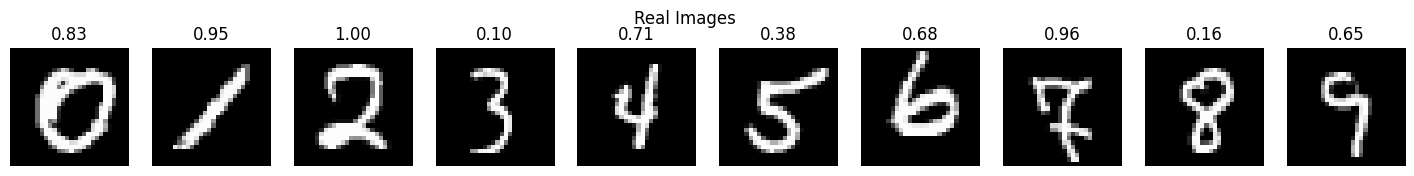

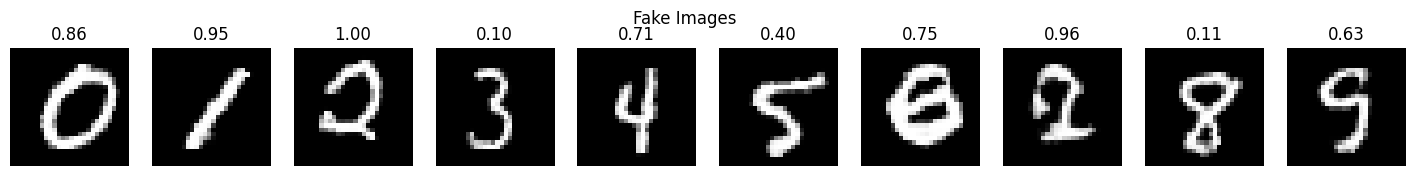

600/600 [==============================] - 116s 193ms/step - g_loss: 0.7054 - g_total_loss: 0.7137 - d_loss: 0.6879 - f_acc: 0.4957 - r_acc: 0.5041
Epoch 74/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7058 - g_total_loss: 0.7143 - d_loss: 0.6881 - f_acc: 0.4956 - r_acc: 0.5040

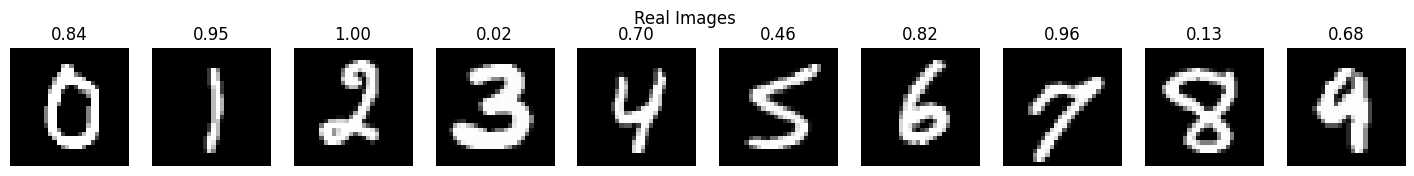

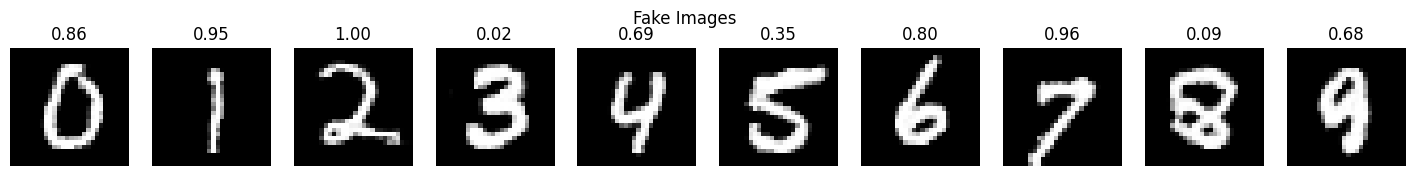

600/600 [==============================] - 114s 190ms/step - g_loss: 0.7058 - g_total_loss: 0.7143 - d_loss: 0.6881 - f_acc: 0.4956 - r_acc: 0.5040
Epoch 75/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7058 - g_total_loss: 0.7141 - d_loss: 0.6877 - f_acc: 0.4955 - r_acc: 0.5041

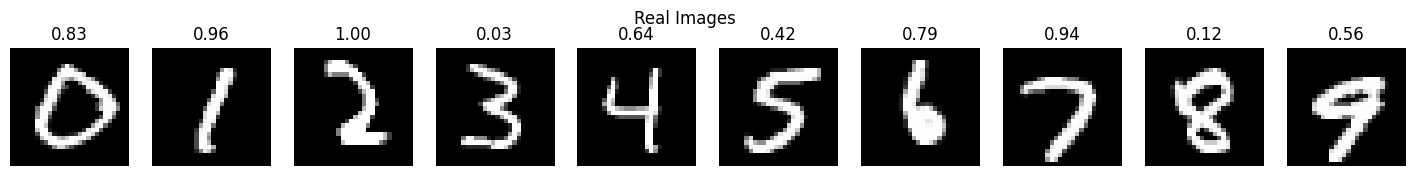

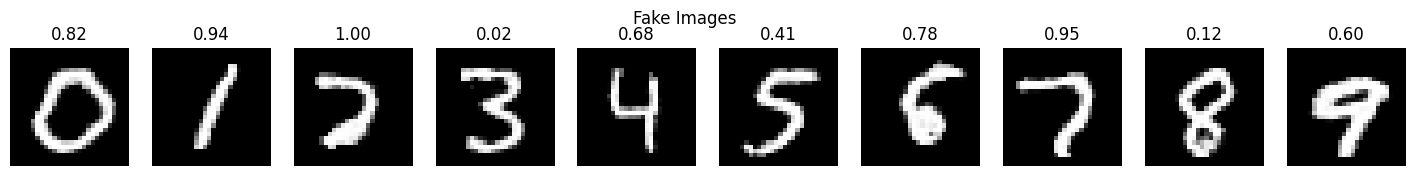

600/600 [==============================] - 115s 191ms/step - g_loss: 0.7058 - g_total_loss: 0.7141 - d_loss: 0.6877 - f_acc: 0.4955 - r_acc: 0.5041
Epoch 76/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7055 - g_total_loss: 0.7137 - d_loss: 0.6876 - f_acc: 0.4957 - r_acc: 0.5043

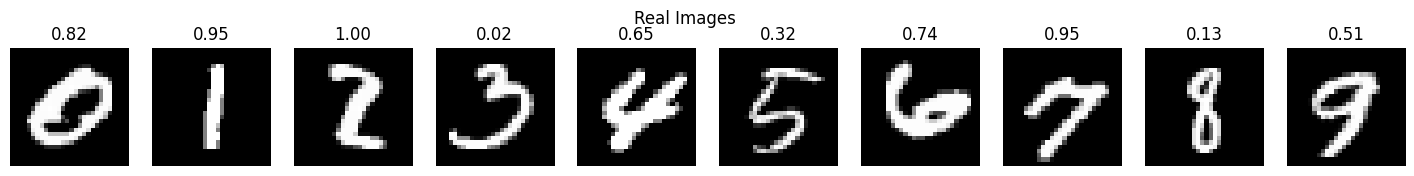

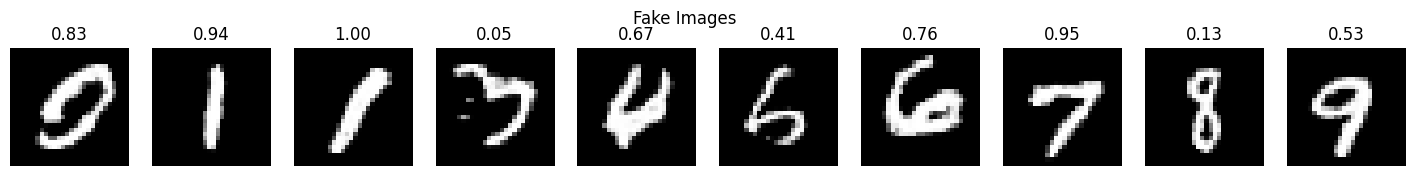

600/600 [==============================] - 117s 196ms/step - g_loss: 0.7055 - g_total_loss: 0.7137 - d_loss: 0.6876 - f_acc: 0.4957 - r_acc: 0.5043
Epoch 77/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7056 - g_total_loss: 0.7141 - d_loss: 0.6879 - f_acc: 0.4956 - r_acc: 0.5040

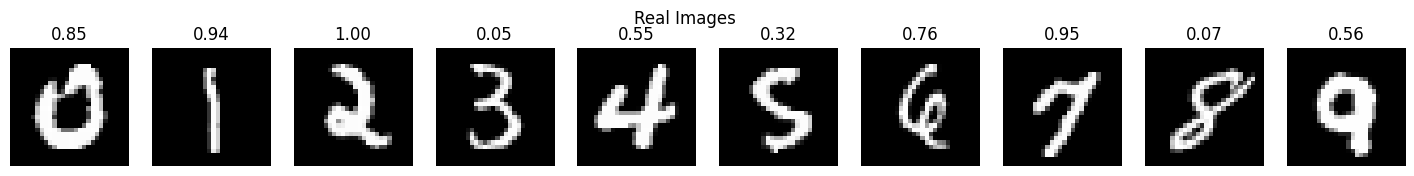

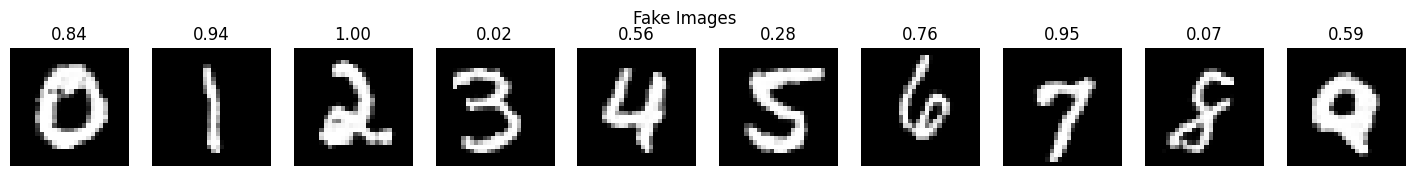

600/600 [==============================] - 114s 190ms/step - g_loss: 0.7056 - g_total_loss: 0.7141 - d_loss: 0.6879 - f_acc: 0.4956 - r_acc: 0.5040
Epoch 78/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7054 - g_total_loss: 0.7139 - d_loss: 0.6878 - f_acc: 0.4957 - r_acc: 0.5043

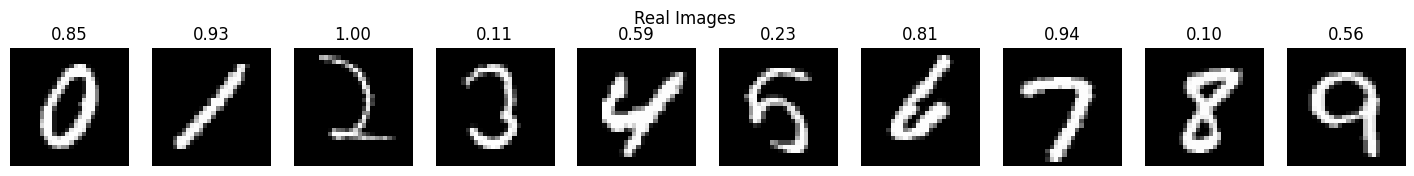

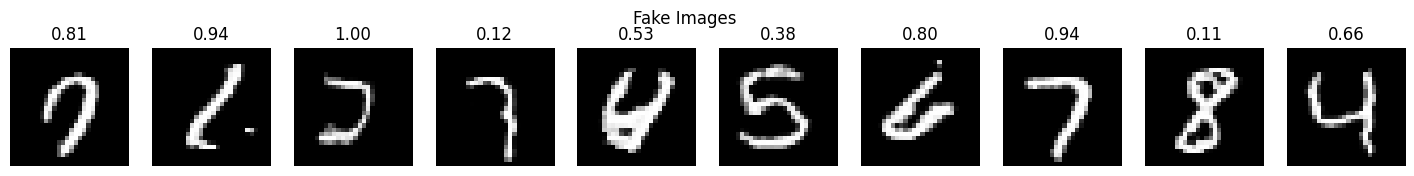

600/600 [==============================] - 116s 193ms/step - g_loss: 0.7054 - g_total_loss: 0.7139 - d_loss: 0.6878 - f_acc: 0.4957 - r_acc: 0.5043
Epoch 79/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7058 - g_total_loss: 0.7141 - d_loss: 0.6876 - f_acc: 0.4955 - r_acc: 0.5044

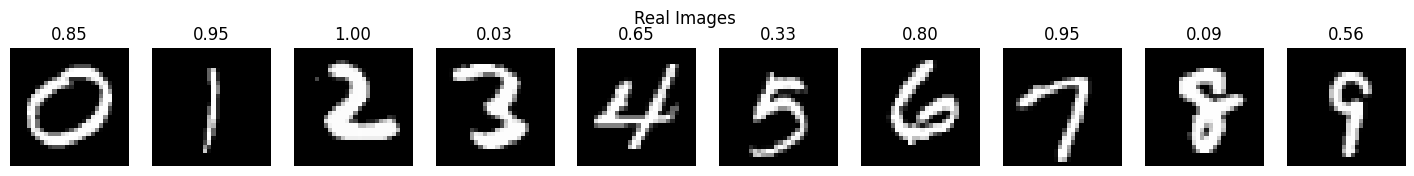

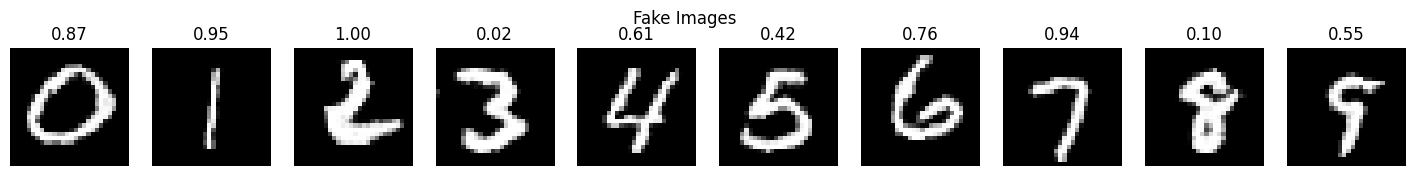

600/600 [==============================] - 114s 190ms/step - g_loss: 0.7058 - g_total_loss: 0.7141 - d_loss: 0.6876 - f_acc: 0.4955 - r_acc: 0.5044
Epoch 80/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7054 - g_total_loss: 0.7135 - d_loss: 0.6878 - f_acc: 0.4957 - r_acc: 0.5043

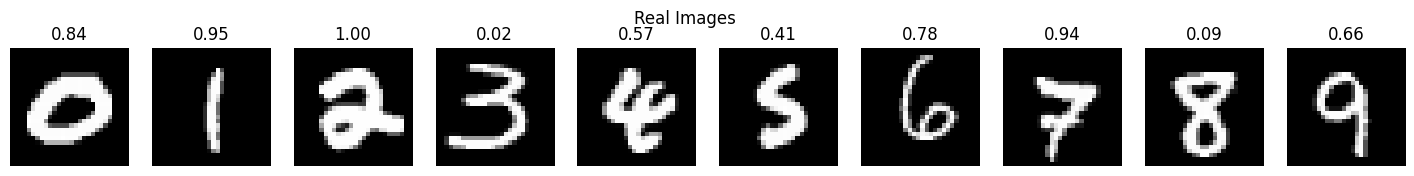

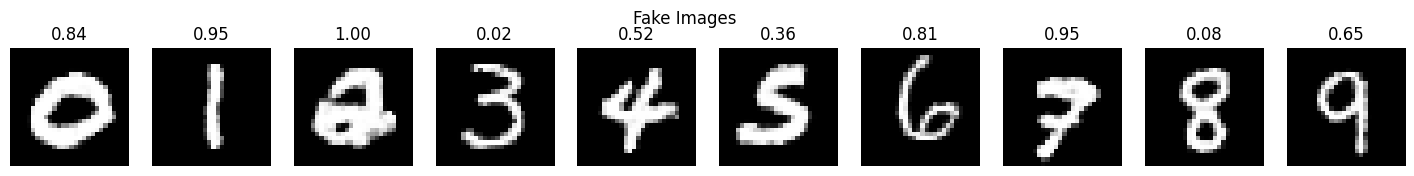

600/600 [==============================] - 113s 189ms/step - g_loss: 0.7054 - g_total_loss: 0.7135 - d_loss: 0.6878 - f_acc: 0.4957 - r_acc: 0.5043
Epoch 81/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7058 - g_total_loss: 0.7142 - d_loss: 0.6879 - f_acc: 0.4956 - r_acc: 0.5042

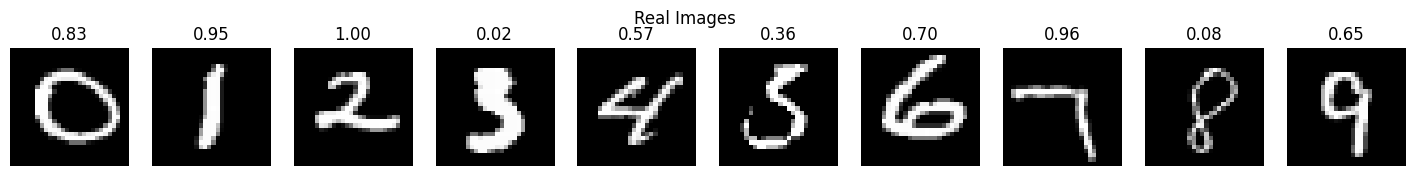

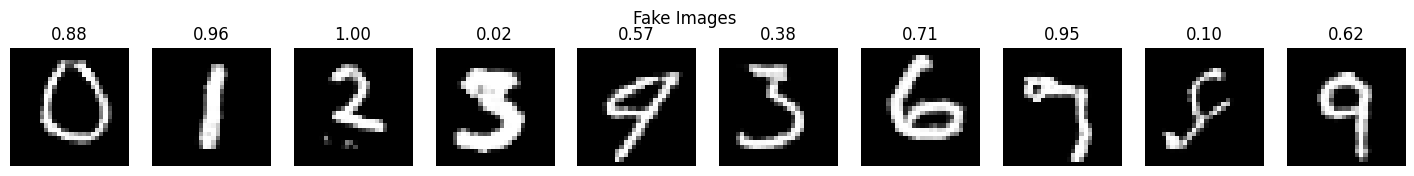

600/600 [==============================] - 483s 806ms/step - g_loss: 0.7058 - g_total_loss: 0.7142 - d_loss: 0.6879 - f_acc: 0.4956 - r_acc: 0.5042
Epoch 82/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7060 - g_total_loss: 0.7146 - d_loss: 0.6880 - f_acc: 0.4955 - r_acc: 0.5041

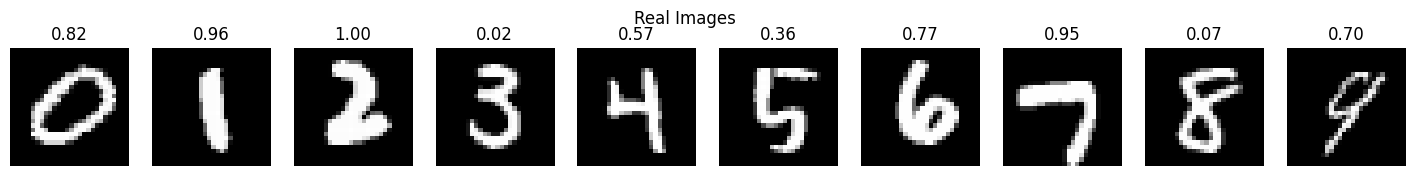

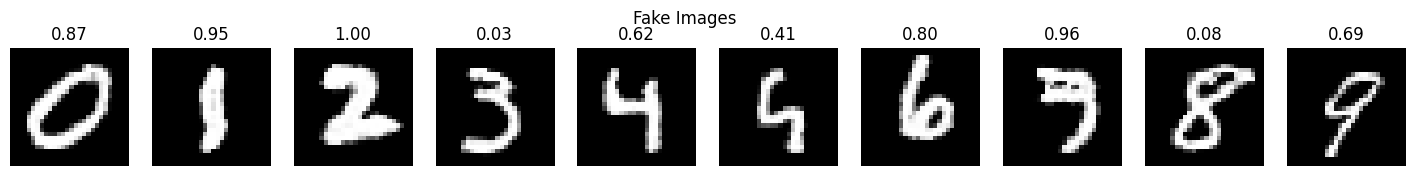

600/600 [==============================] - 113s 189ms/step - g_loss: 0.7060 - g_total_loss: 0.7146 - d_loss: 0.6880 - f_acc: 0.4955 - r_acc: 0.5041
Epoch 83/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7055 - g_total_loss: 0.7138 - d_loss: 0.6880 - f_acc: 0.4957 - r_acc: 0.5040

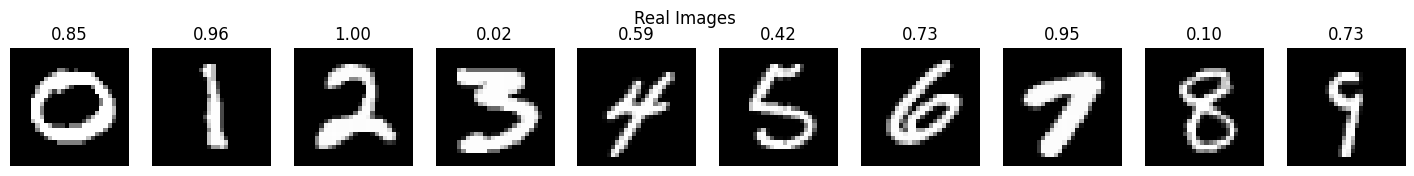

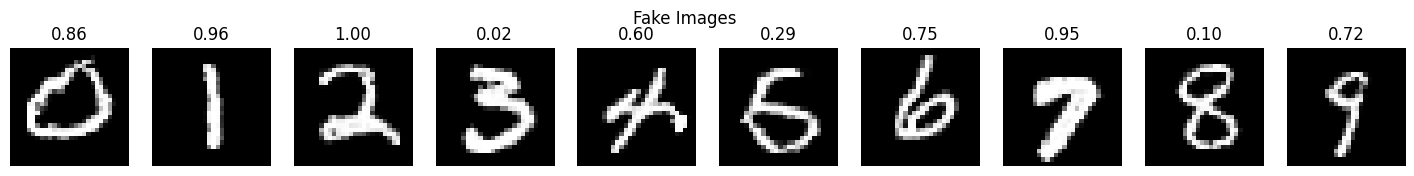

600/600 [==============================] - 116s 193ms/step - g_loss: 0.7055 - g_total_loss: 0.7138 - d_loss: 0.6880 - f_acc: 0.4957 - r_acc: 0.5040
Epoch 84/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7051 - g_total_loss: 0.7136 - d_loss: 0.6882 - f_acc: 0.4959 - r_acc: 0.5041

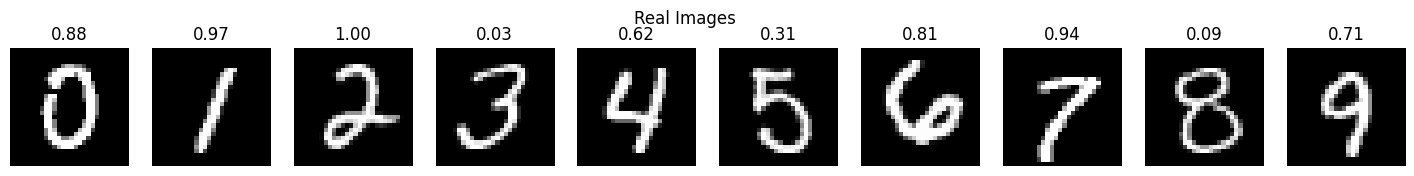

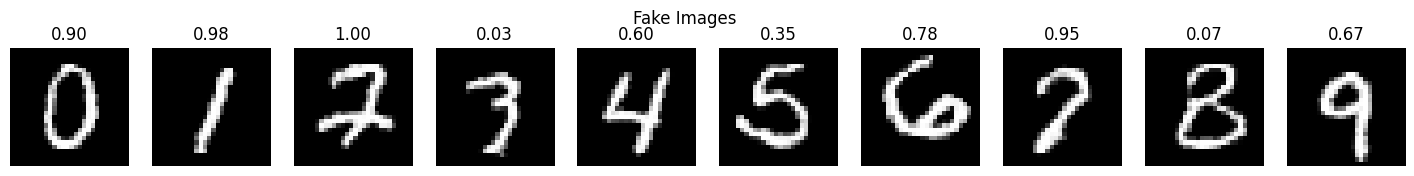

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7051 - g_total_loss: 0.7136 - d_loss: 0.6882 - f_acc: 0.4959 - r_acc: 0.5041
Epoch 85/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7054 - g_total_loss: 0.7138 - d_loss: 0.6881 - f_acc: 0.4957 - r_acc: 0.5041

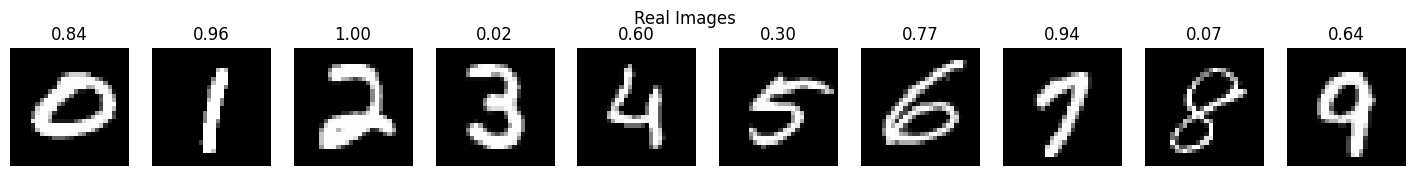

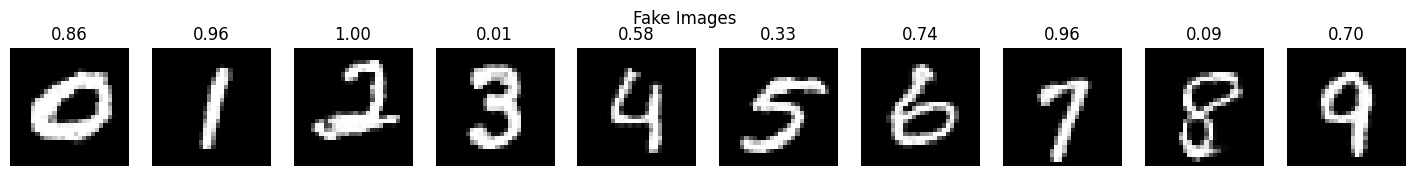

600/600 [==============================] - 118s 197ms/step - g_loss: 0.7054 - g_total_loss: 0.7138 - d_loss: 0.6881 - f_acc: 0.4957 - r_acc: 0.5041
Epoch 86/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7051 - g_total_loss: 0.7133 - d_loss: 0.6882 - f_acc: 0.4959 - r_acc: 0.5041

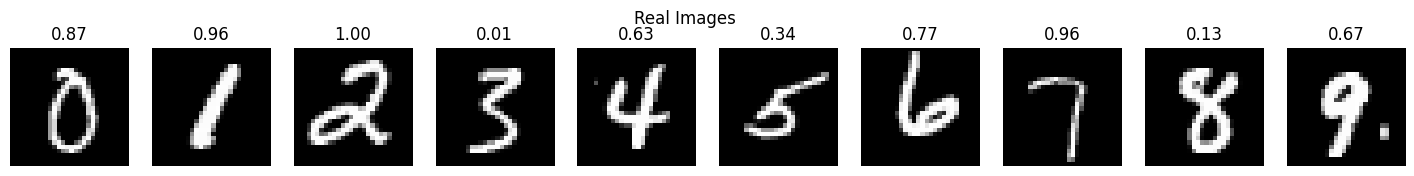

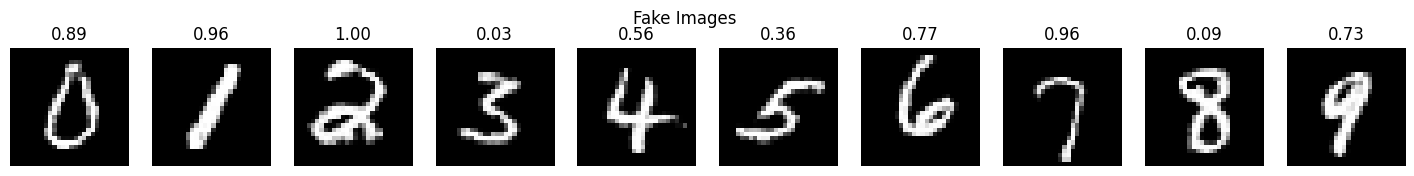

600/600 [==============================] - 118s 196ms/step - g_loss: 0.7051 - g_total_loss: 0.7133 - d_loss: 0.6882 - f_acc: 0.4959 - r_acc: 0.5041
Epoch 87/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7057 - g_total_loss: 0.7143 - d_loss: 0.6881 - f_acc: 0.4956 - r_acc: 0.5040

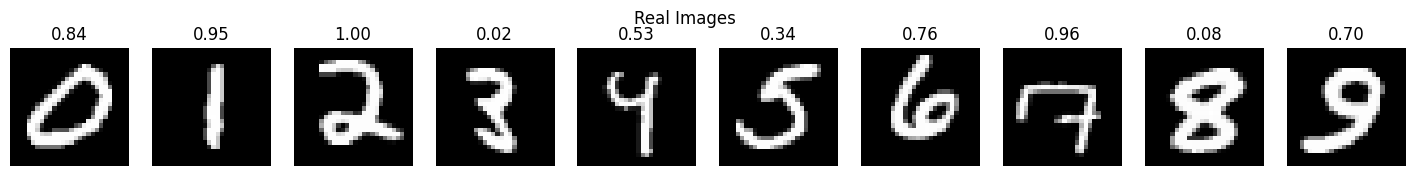

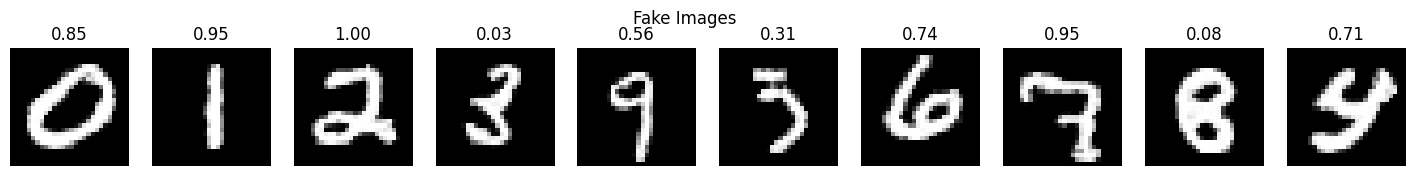

600/600 [==============================] - 118s 197ms/step - g_loss: 0.7057 - g_total_loss: 0.7143 - d_loss: 0.6881 - f_acc: 0.4956 - r_acc: 0.5040
Epoch 88/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7055 - g_total_loss: 0.7140 - d_loss: 0.6882 - f_acc: 0.4958 - r_acc: 0.5041

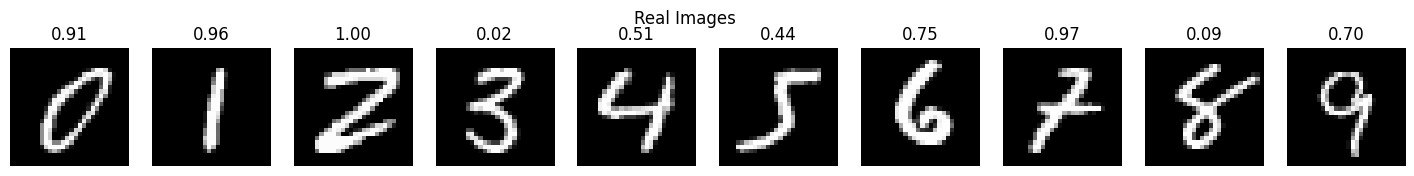

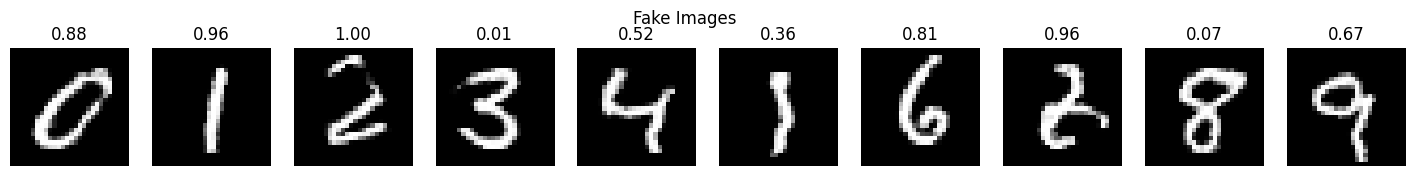

600/600 [==============================] - 118s 196ms/step - g_loss: 0.7055 - g_total_loss: 0.7140 - d_loss: 0.6882 - f_acc: 0.4958 - r_acc: 0.5041
Epoch 89/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7055 - g_total_loss: 0.7140 - d_loss: 0.6884 - f_acc: 0.4958 - r_acc: 0.5040

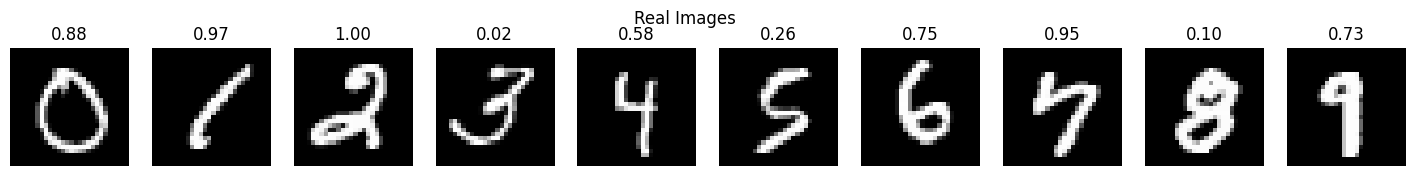

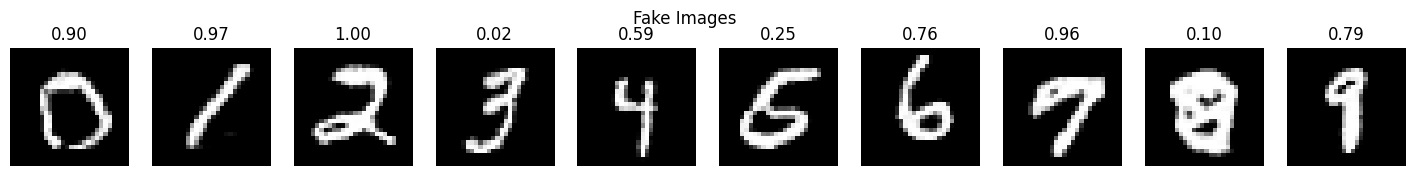

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7055 - g_total_loss: 0.7140 - d_loss: 0.6884 - f_acc: 0.4958 - r_acc: 0.5040
Epoch 90/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7055 - g_total_loss: 0.7138 - d_loss: 0.6883 - f_acc: 0.4957 - r_acc: 0.5039

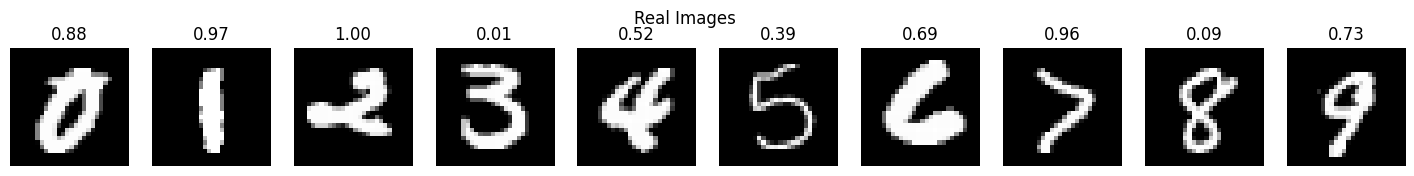

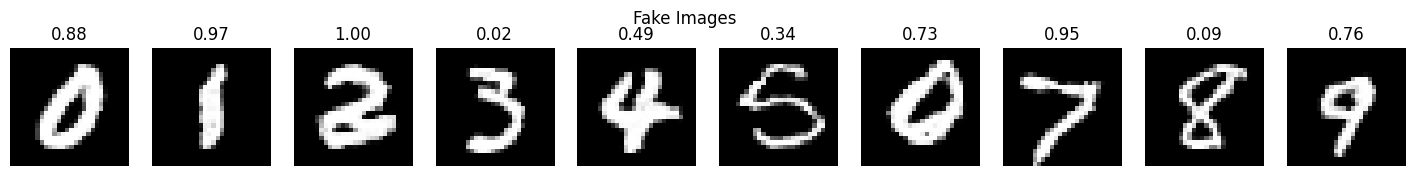

600/600 [==============================] - 119s 198ms/step - g_loss: 0.7055 - g_total_loss: 0.7138 - d_loss: 0.6883 - f_acc: 0.4957 - r_acc: 0.5039
Epoch 91/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7052 - g_total_loss: 0.7137 - d_loss: 0.6886 - f_acc: 0.4959 - r_acc: 0.5037

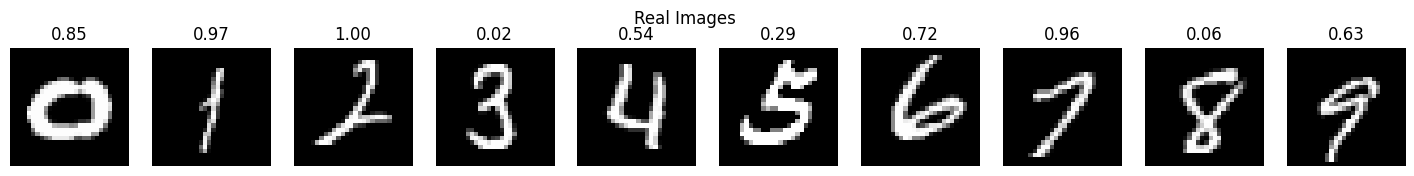

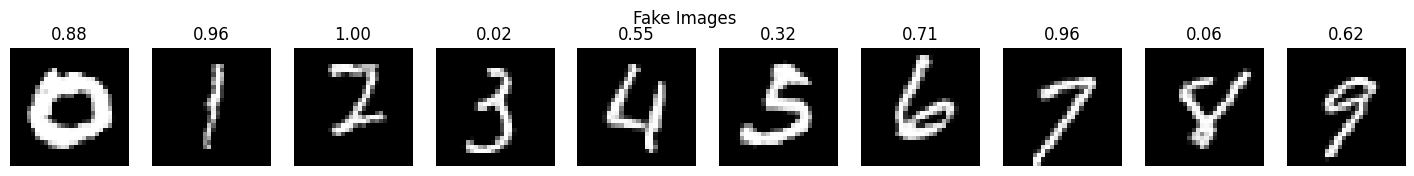

600/600 [==============================] - 118s 196ms/step - g_loss: 0.7052 - g_total_loss: 0.7137 - d_loss: 0.6886 - f_acc: 0.4959 - r_acc: 0.5037
Epoch 92/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7049 - g_total_loss: 0.7133 - d_loss: 0.6887 - f_acc: 0.4960 - r_acc: 0.5038

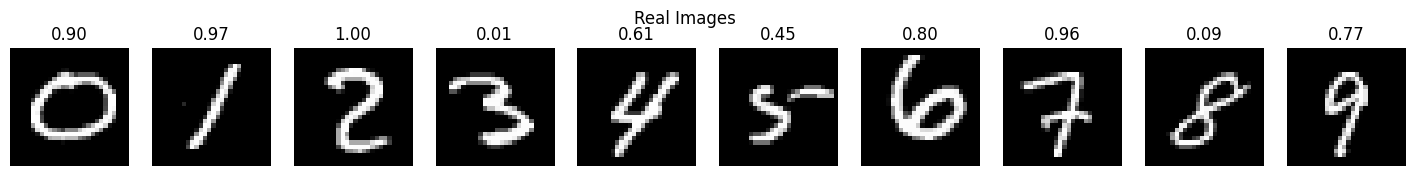

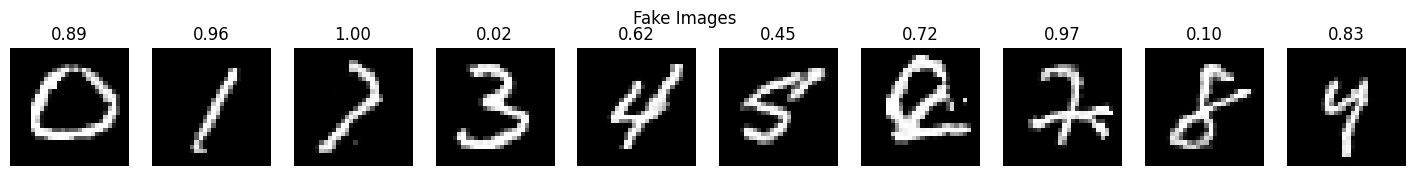

600/600 [==============================] - 119s 198ms/step - g_loss: 0.7049 - g_total_loss: 0.7133 - d_loss: 0.6887 - f_acc: 0.4960 - r_acc: 0.5038
Epoch 93/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7057 - g_total_loss: 0.7141 - d_loss: 0.6883 - f_acc: 0.4957 - r_acc: 0.5039

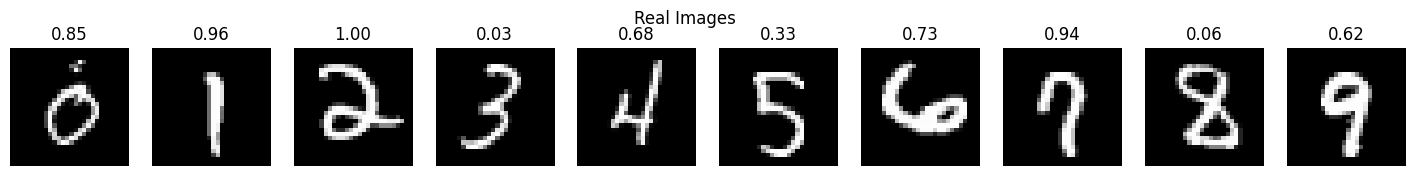

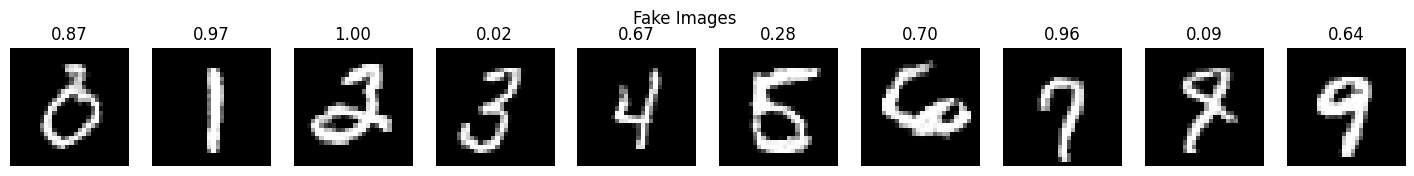

600/600 [==============================] - 116s 194ms/step - g_loss: 0.7057 - g_total_loss: 0.7141 - d_loss: 0.6883 - f_acc: 0.4957 - r_acc: 0.5039
Epoch 94/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7049 - g_total_loss: 0.7133 - d_loss: 0.6886 - f_acc: 0.4960 - r_acc: 0.5038

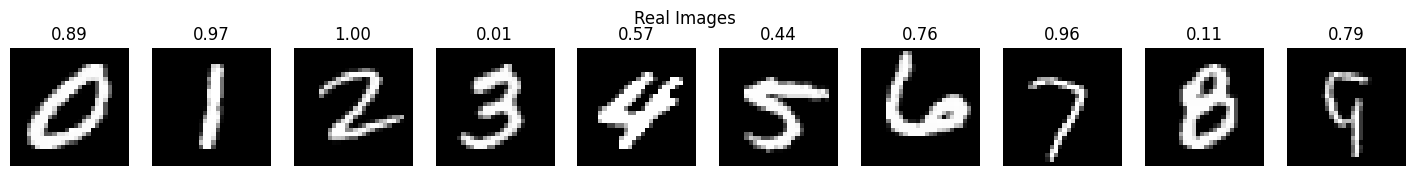

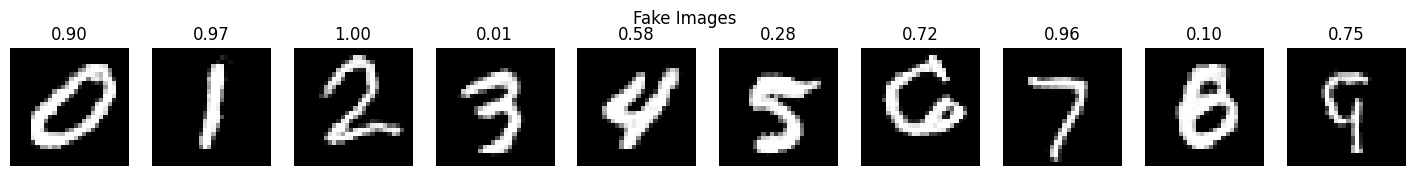

600/600 [==============================] - 116s 193ms/step - g_loss: 0.7049 - g_total_loss: 0.7133 - d_loss: 0.6886 - f_acc: 0.4960 - r_acc: 0.5038
Epoch 95/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7054 - g_total_loss: 0.7140 - d_loss: 0.6884 - f_acc: 0.4958 - r_acc: 0.5039

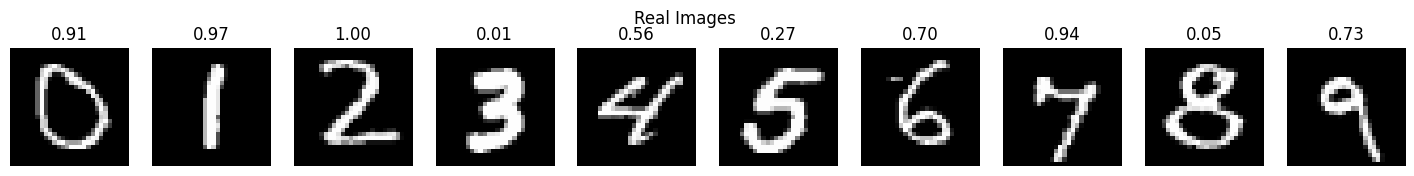

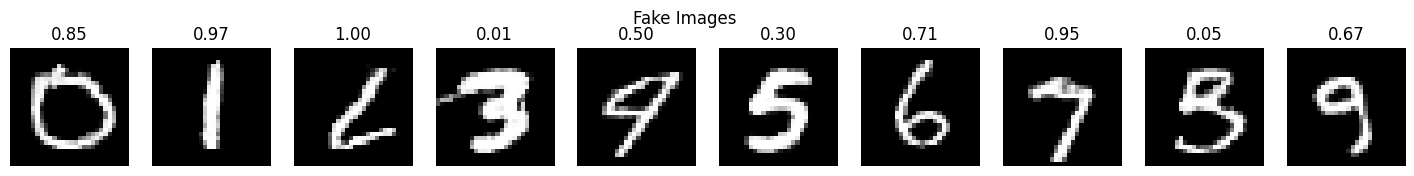

600/600 [==============================] - 116s 194ms/step - g_loss: 0.7054 - g_total_loss: 0.7140 - d_loss: 0.6884 - f_acc: 0.4958 - r_acc: 0.5039
Epoch 96/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7056 - g_total_loss: 0.7140 - d_loss: 0.6882 - f_acc: 0.4957 - r_acc: 0.5040

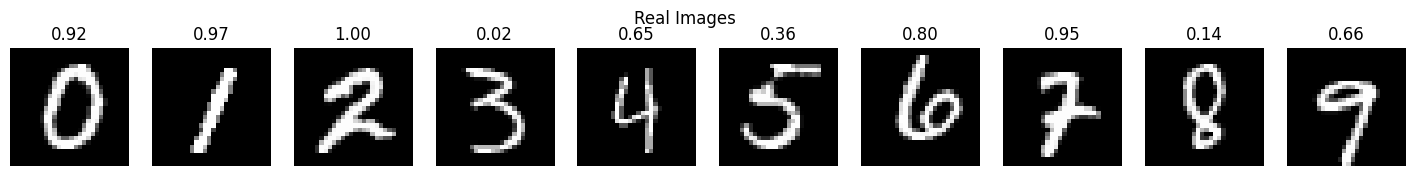

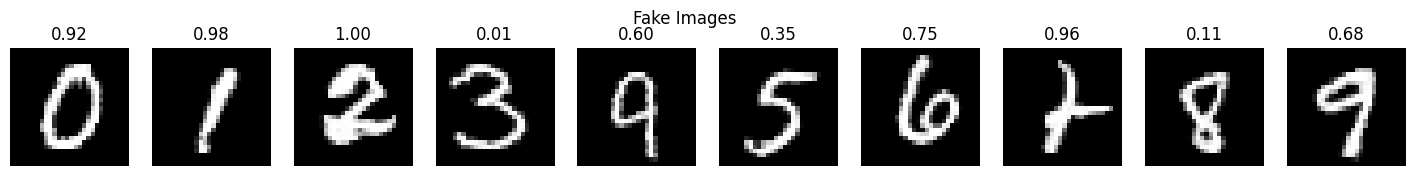

600/600 [==============================] - 115s 192ms/step - g_loss: 0.7056 - g_total_loss: 0.7140 - d_loss: 0.6882 - f_acc: 0.4957 - r_acc: 0.5040
Epoch 97/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7052 - g_total_loss: 0.7136 - d_loss: 0.6885 - f_acc: 0.4959 - r_acc: 0.5038

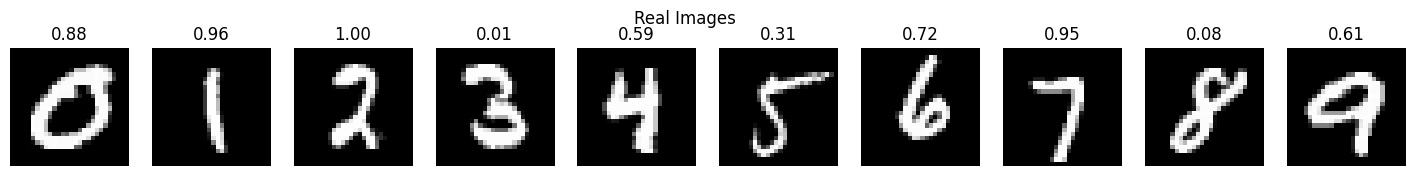

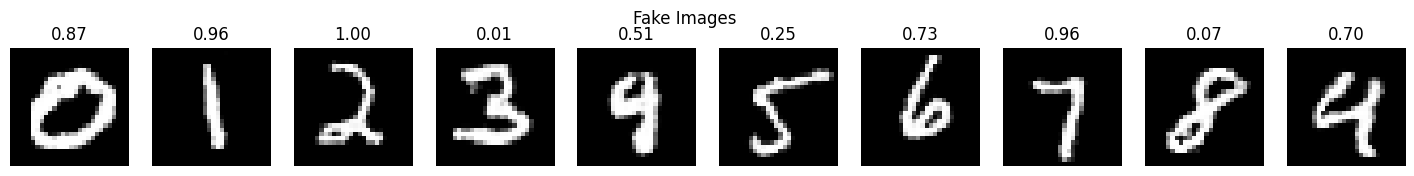

600/600 [==============================] - 116s 193ms/step - g_loss: 0.7052 - g_total_loss: 0.7136 - d_loss: 0.6885 - f_acc: 0.4959 - r_acc: 0.5038
Epoch 98/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7051 - g_total_loss: 0.7138 - d_loss: 0.6887 - f_acc: 0.4959 - r_acc: 0.5039

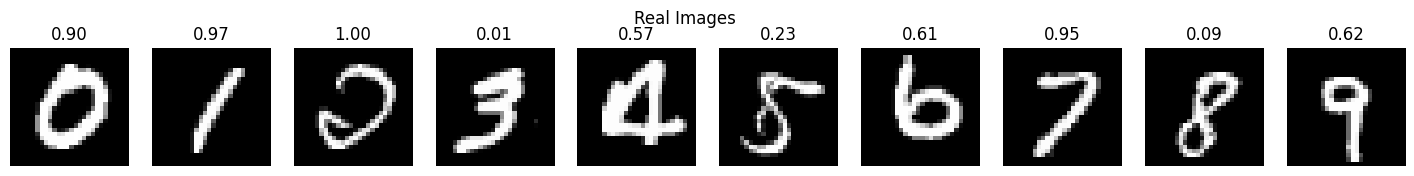

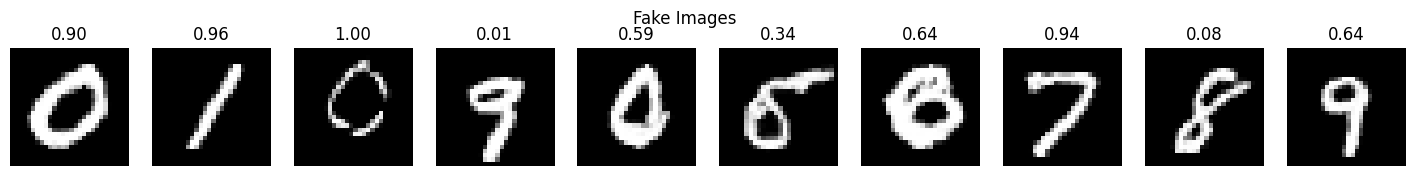

600/600 [==============================] - 116s 193ms/step - g_loss: 0.7051 - g_total_loss: 0.7138 - d_loss: 0.6887 - f_acc: 0.4959 - r_acc: 0.5039
Epoch 99/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7051 - g_total_loss: 0.7134 - d_loss: 0.6885 - f_acc: 0.4959 - r_acc: 0.5037

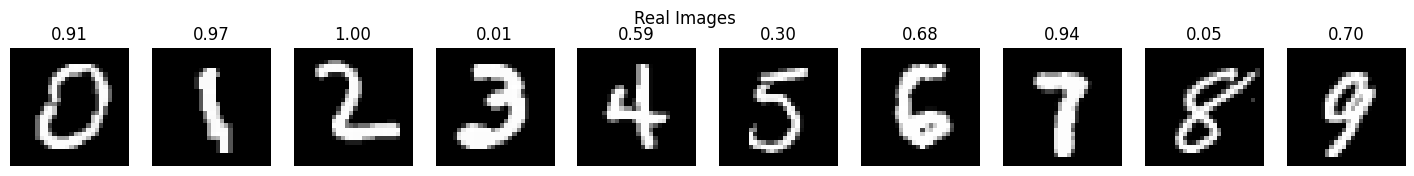

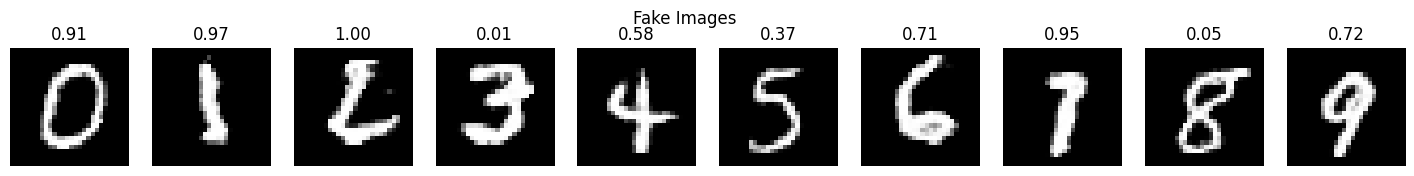

600/600 [==============================] - 116s 193ms/step - g_loss: 0.7051 - g_total_loss: 0.7134 - d_loss: 0.6885 - f_acc: 0.4959 - r_acc: 0.5037
Epoch 100/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7047 - g_total_loss: 0.7133 - d_loss: 0.6886 - f_acc: 0.4960 - r_acc: 0.5038

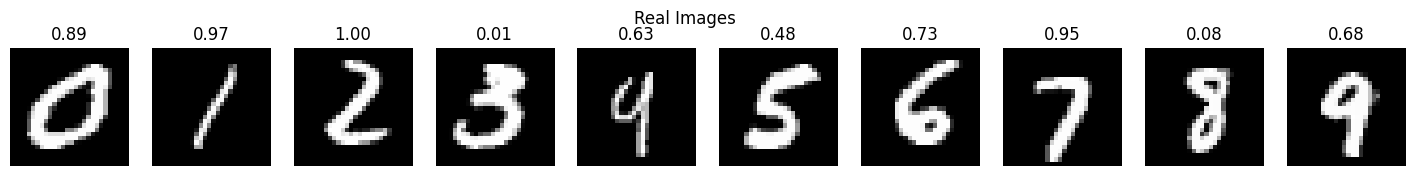

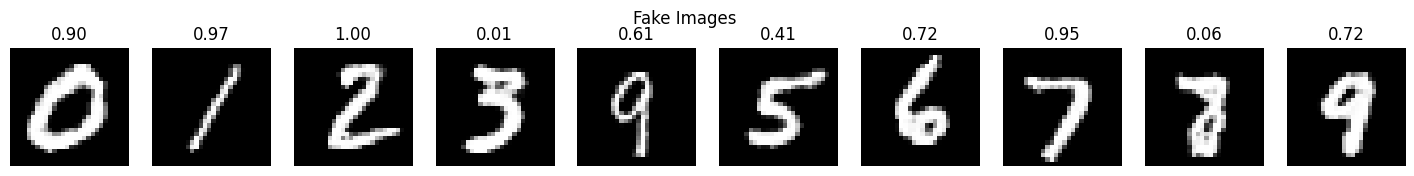

600/600 [==============================] - 117s 196ms/step - g_loss: 0.7047 - g_total_loss: 0.7133 - d_loss: 0.6886 - f_acc: 0.4960 - r_acc: 0.5038
Epoch 101/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7054 - g_total_loss: 0.7138 - d_loss: 0.6885 - f_acc: 0.4958 - r_acc: 0.5038

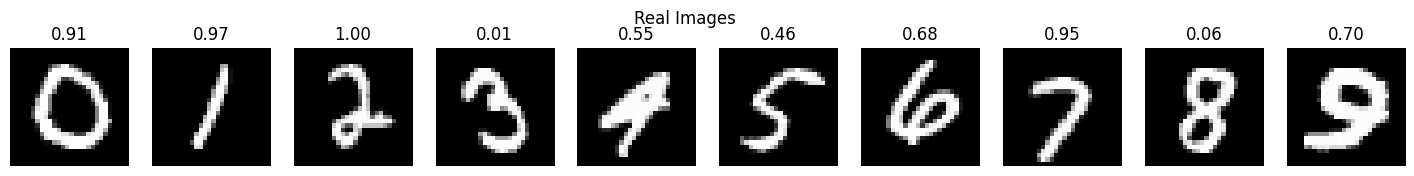

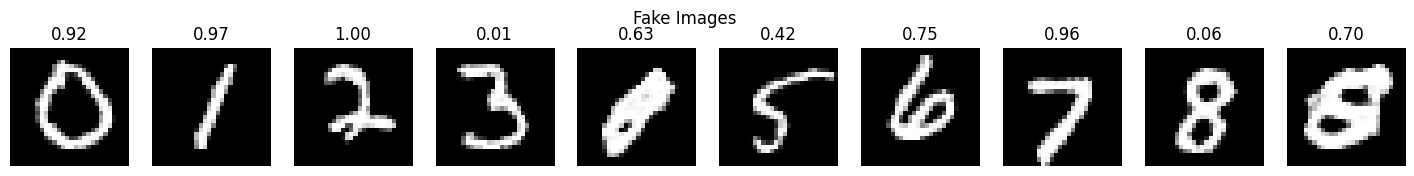

600/600 [==============================] - 116s 194ms/step - g_loss: 0.7054 - g_total_loss: 0.7138 - d_loss: 0.6885 - f_acc: 0.4958 - r_acc: 0.5038
Epoch 102/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7049 - g_total_loss: 0.7133 - d_loss: 0.6887 - f_acc: 0.4960 - r_acc: 0.5036

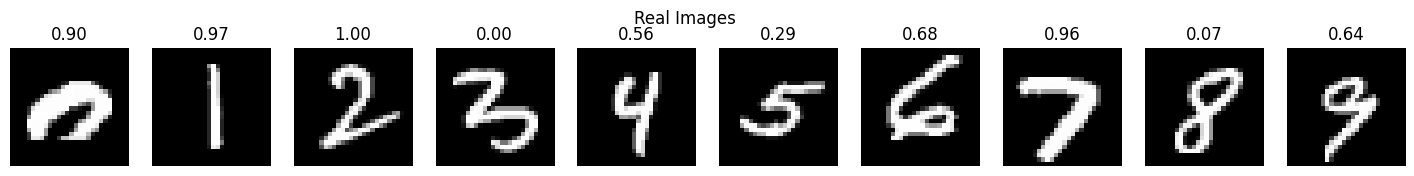

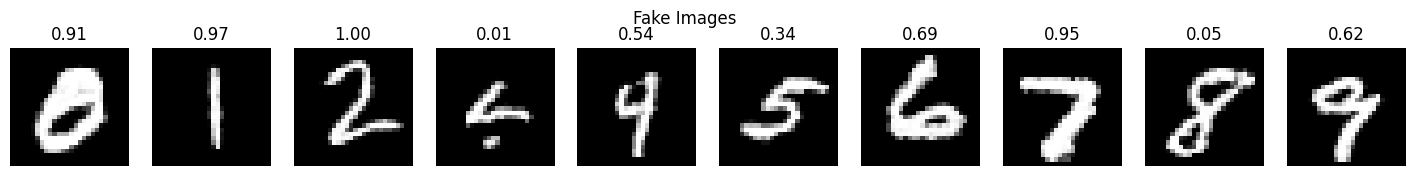

600/600 [==============================] - 116s 194ms/step - g_loss: 0.7049 - g_total_loss: 0.7133 - d_loss: 0.6887 - f_acc: 0.4960 - r_acc: 0.5036
Epoch 103/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7050 - g_total_loss: 0.7135 - d_loss: 0.6887 - f_acc: 0.4959 - r_acc: 0.5037

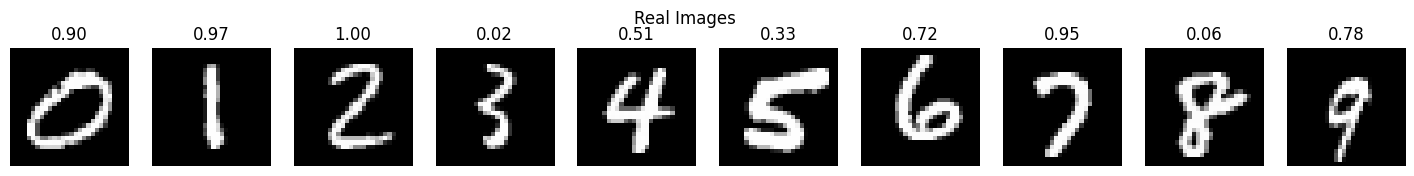

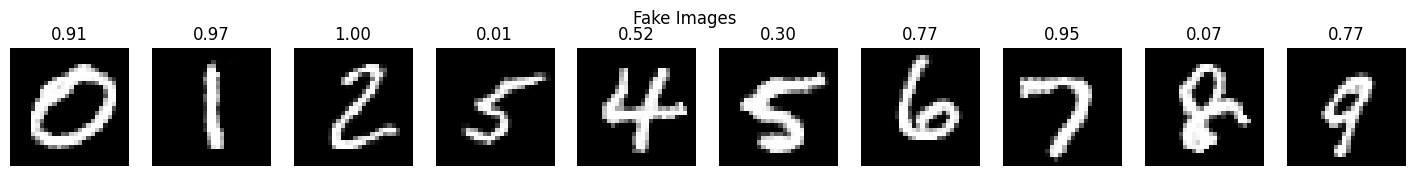

600/600 [==============================] - 119s 198ms/step - g_loss: 0.7050 - g_total_loss: 0.7135 - d_loss: 0.6887 - f_acc: 0.4959 - r_acc: 0.5037
Epoch 104/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7049 - g_total_loss: 0.7132 - d_loss: 0.6887 - f_acc: 0.4959 - r_acc: 0.5037

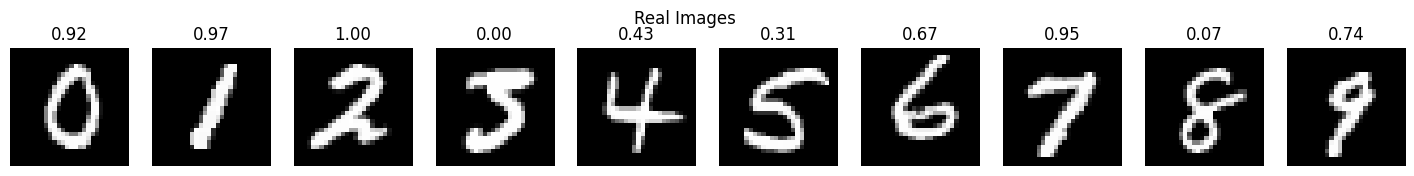

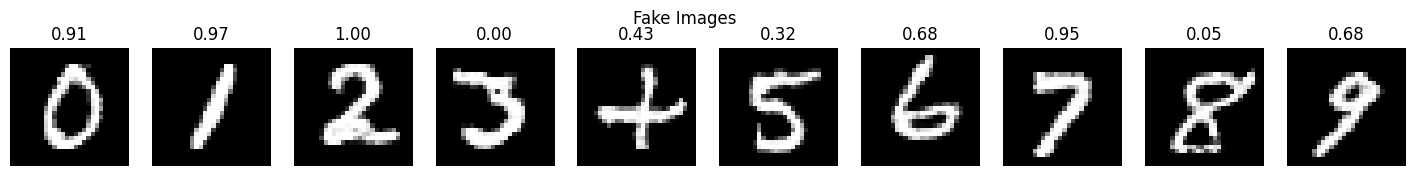

600/600 [==============================] - 118s 196ms/step - g_loss: 0.7049 - g_total_loss: 0.7132 - d_loss: 0.6887 - f_acc: 0.4959 - r_acc: 0.5037
Epoch 105/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7050 - g_total_loss: 0.7135 - d_loss: 0.6887 - f_acc: 0.4959 - r_acc: 0.5038

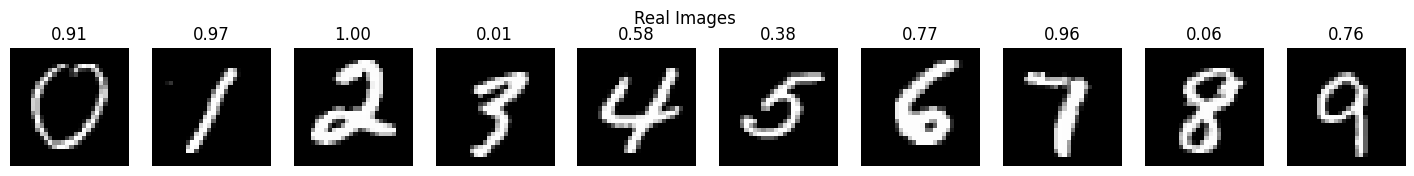

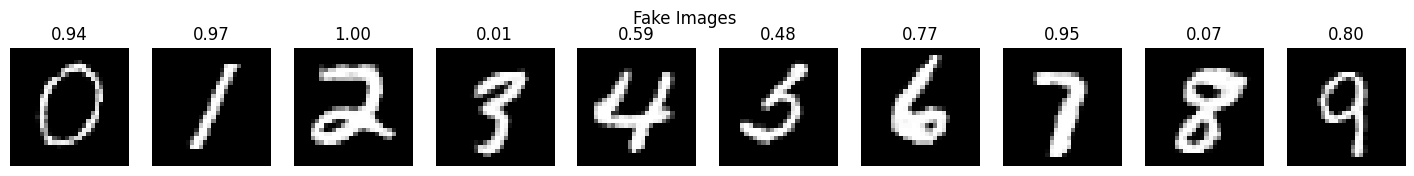

600/600 [==============================] - 116s 193ms/step - g_loss: 0.7050 - g_total_loss: 0.7135 - d_loss: 0.6887 - f_acc: 0.4959 - r_acc: 0.5038
Epoch 106/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7048 - g_total_loss: 0.7132 - d_loss: 0.6891 - f_acc: 0.4961 - r_acc: 0.5035

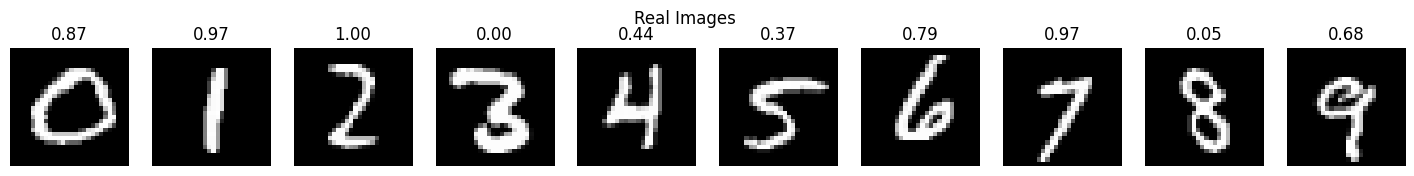

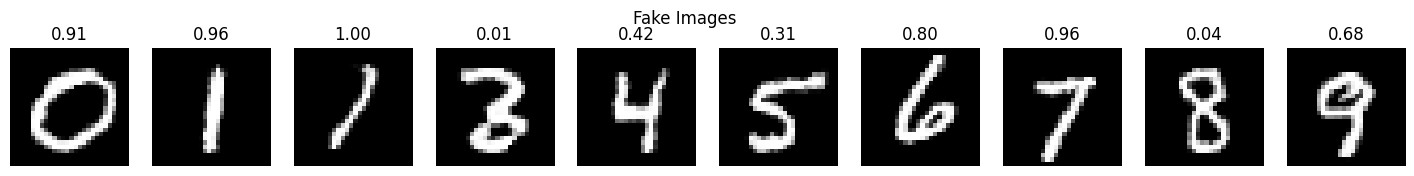

600/600 [==============================] - 118s 197ms/step - g_loss: 0.7048 - g_total_loss: 0.7132 - d_loss: 0.6891 - f_acc: 0.4961 - r_acc: 0.5035
Epoch 107/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7049 - g_total_loss: 0.7133 - d_loss: 0.6889 - f_acc: 0.4960 - r_acc: 0.5036

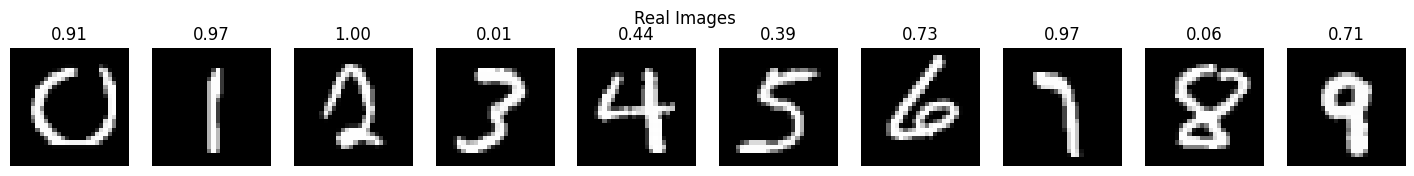

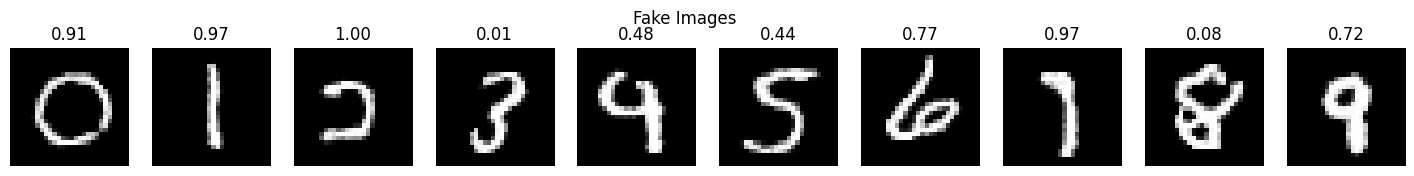

600/600 [==============================] - 122s 202ms/step - g_loss: 0.7049 - g_total_loss: 0.7133 - d_loss: 0.6889 - f_acc: 0.4960 - r_acc: 0.5036
Epoch 108/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7049 - g_total_loss: 0.7132 - d_loss: 0.6887 - f_acc: 0.4960 - r_acc: 0.5037

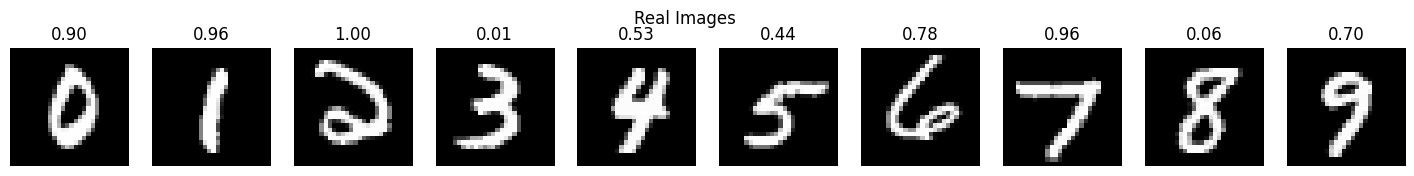

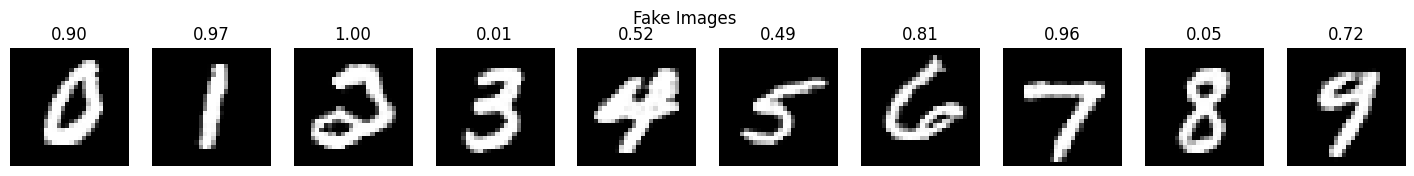

600/600 [==============================] - 120s 200ms/step - g_loss: 0.7049 - g_total_loss: 0.7132 - d_loss: 0.6887 - f_acc: 0.4960 - r_acc: 0.5037
Epoch 109/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7044 - g_total_loss: 0.7128 - d_loss: 0.6889 - f_acc: 0.4962 - r_acc: 0.5037

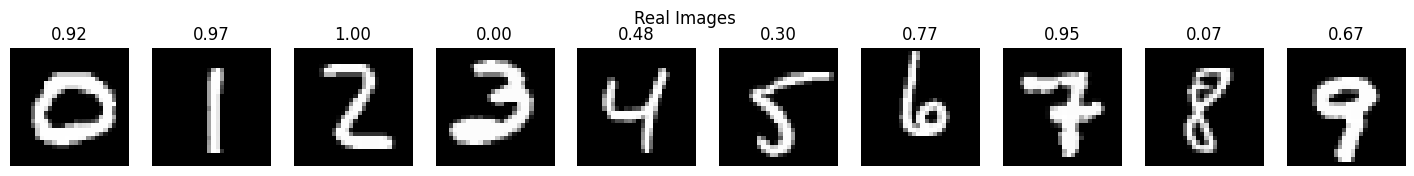

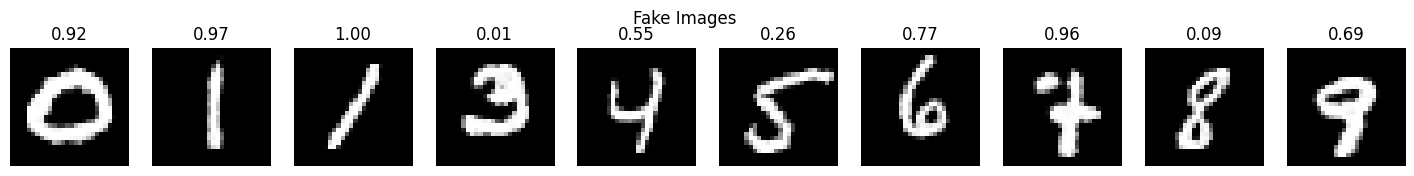

600/600 [==============================] - 120s 200ms/step - g_loss: 0.7044 - g_total_loss: 0.7128 - d_loss: 0.6889 - f_acc: 0.4962 - r_acc: 0.5037
Epoch 110/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7048 - g_total_loss: 0.7134 - d_loss: 0.6891 - f_acc: 0.4961 - r_acc: 0.5037

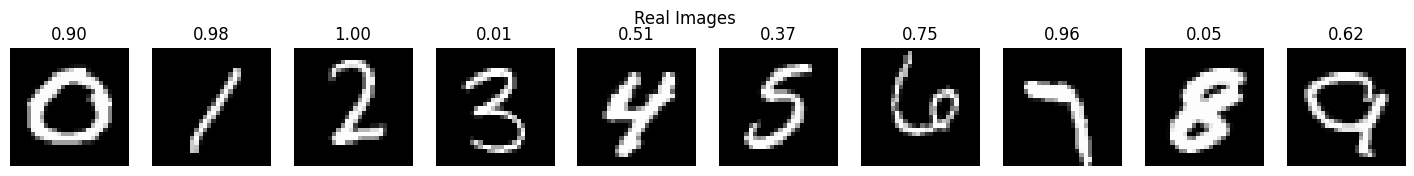

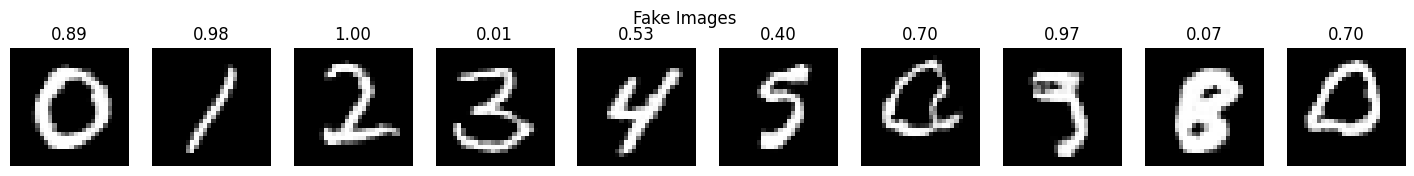

600/600 [==============================] - 118s 196ms/step - g_loss: 0.7048 - g_total_loss: 0.7134 - d_loss: 0.6891 - f_acc: 0.4961 - r_acc: 0.5037
Epoch 111/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7043 - g_total_loss: 0.7126 - d_loss: 0.6892 - f_acc: 0.4963 - r_acc: 0.5035

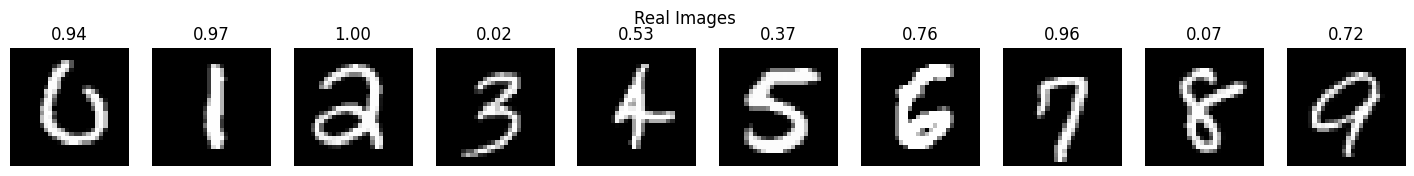

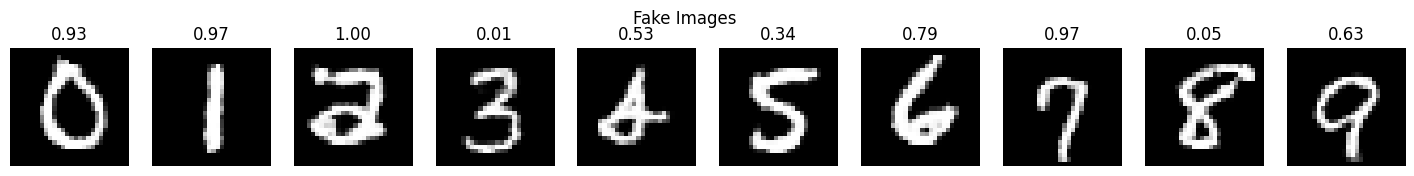

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7043 - g_total_loss: 0.7126 - d_loss: 0.6892 - f_acc: 0.4963 - r_acc: 0.5035
Epoch 112/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7042 - g_total_loss: 0.7128 - d_loss: 0.6894 - f_acc: 0.4963 - r_acc: 0.5034

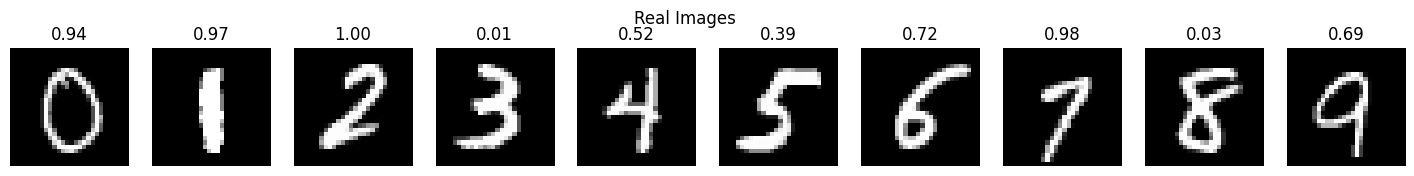

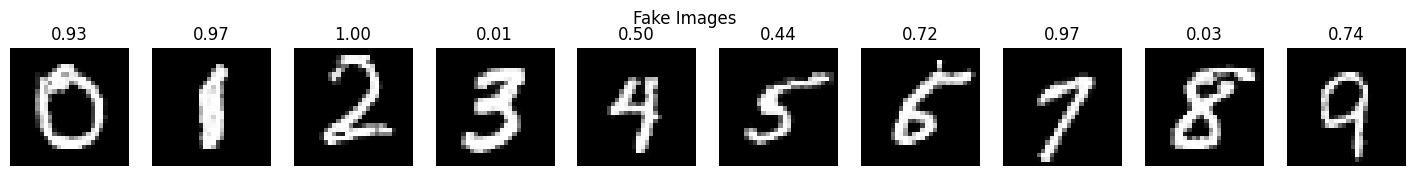

600/600 [==============================] - 113s 189ms/step - g_loss: 0.7042 - g_total_loss: 0.7128 - d_loss: 0.6894 - f_acc: 0.4963 - r_acc: 0.5034
Epoch 113/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7049 - g_total_loss: 0.7135 - d_loss: 0.6889 - f_acc: 0.4960 - r_acc: 0.5037

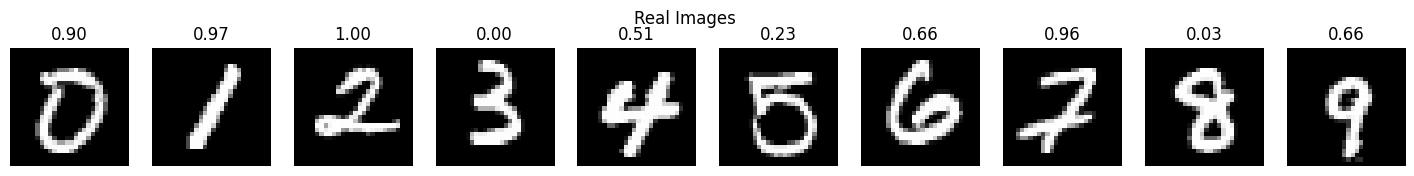

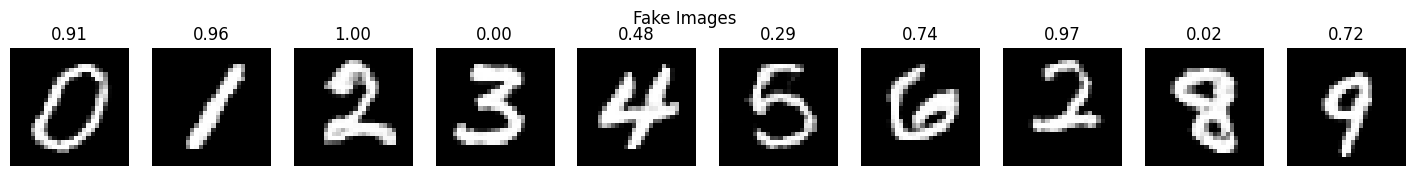

600/600 [==============================] - 112s 187ms/step - g_loss: 0.7049 - g_total_loss: 0.7135 - d_loss: 0.6889 - f_acc: 0.4960 - r_acc: 0.5037
Epoch 114/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7041 - g_total_loss: 0.7125 - d_loss: 0.6892 - f_acc: 0.4963 - r_acc: 0.5035

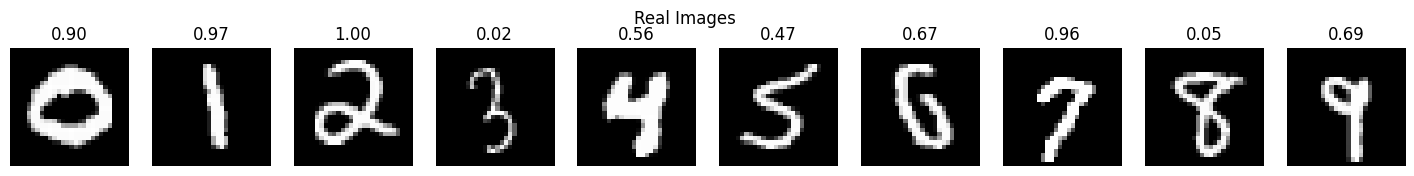

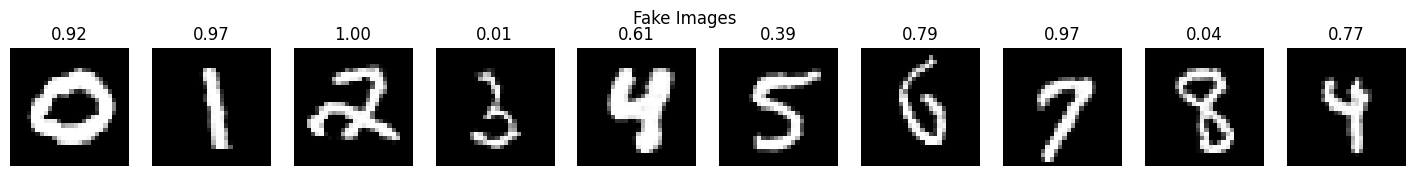

600/600 [==============================] - 112s 187ms/step - g_loss: 0.7041 - g_total_loss: 0.7125 - d_loss: 0.6892 - f_acc: 0.4963 - r_acc: 0.5035
Epoch 115/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7044 - g_total_loss: 0.7128 - d_loss: 0.6891 - f_acc: 0.4962 - r_acc: 0.5035

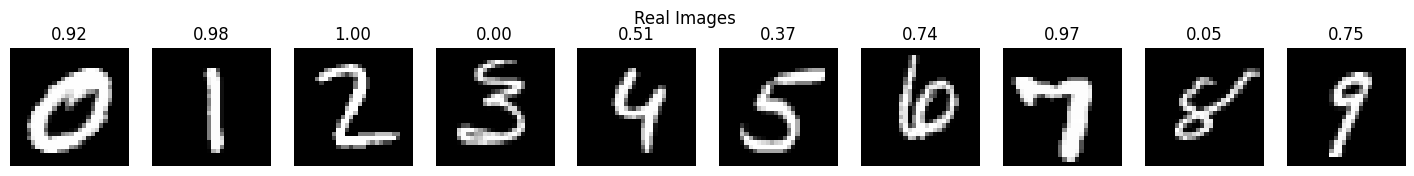

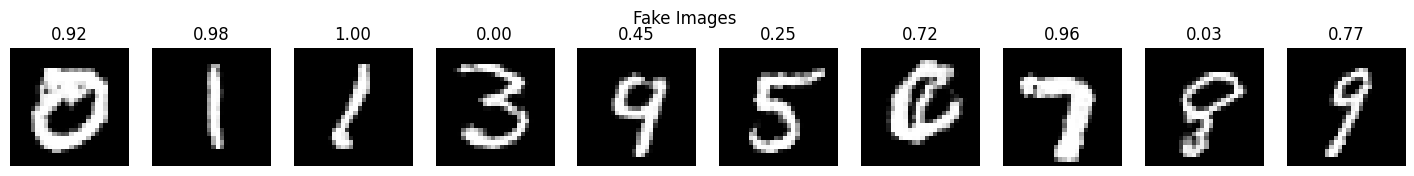

600/600 [==============================] - 111s 186ms/step - g_loss: 0.7044 - g_total_loss: 0.7128 - d_loss: 0.6891 - f_acc: 0.4962 - r_acc: 0.5035
Epoch 116/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7039 - g_total_loss: 0.7122 - d_loss: 0.6896 - f_acc: 0.4964 - r_acc: 0.5033

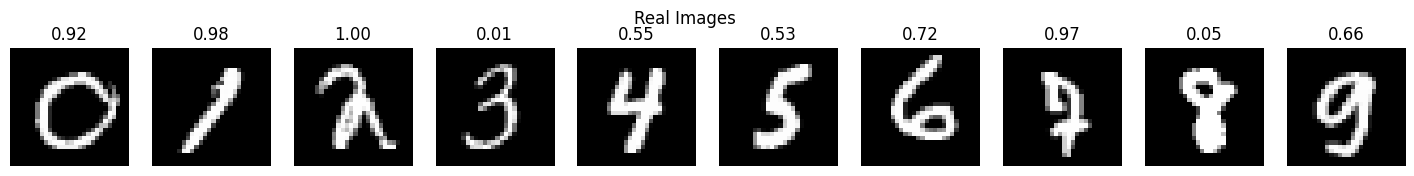

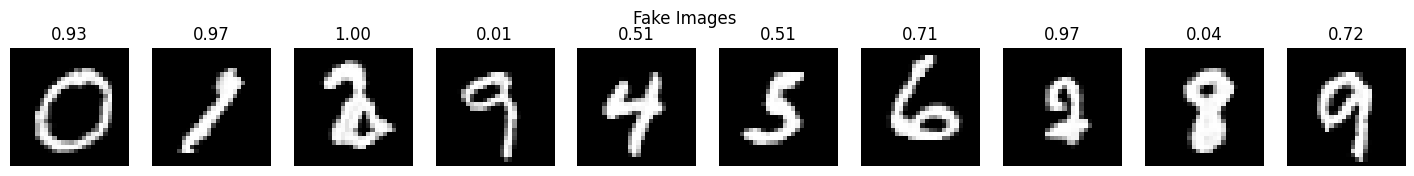

600/600 [==============================] - 112s 187ms/step - g_loss: 0.7039 - g_total_loss: 0.7122 - d_loss: 0.6896 - f_acc: 0.4964 - r_acc: 0.5033
Epoch 117/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7045 - g_total_loss: 0.7129 - d_loss: 0.6893 - f_acc: 0.4962 - r_acc: 0.5034

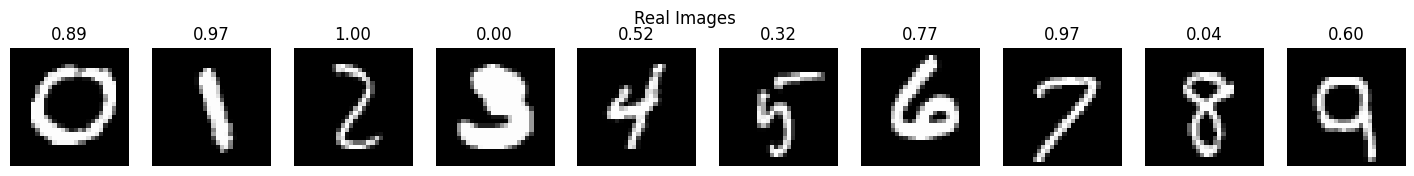

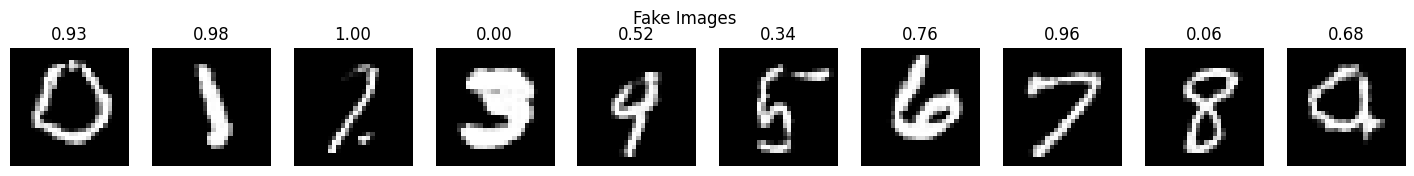

600/600 [==============================] - 113s 188ms/step - g_loss: 0.7045 - g_total_loss: 0.7129 - d_loss: 0.6893 - f_acc: 0.4962 - r_acc: 0.5034
Epoch 118/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7039 - g_total_loss: 0.7120 - d_loss: 0.6892 - f_acc: 0.4964 - r_acc: 0.5035

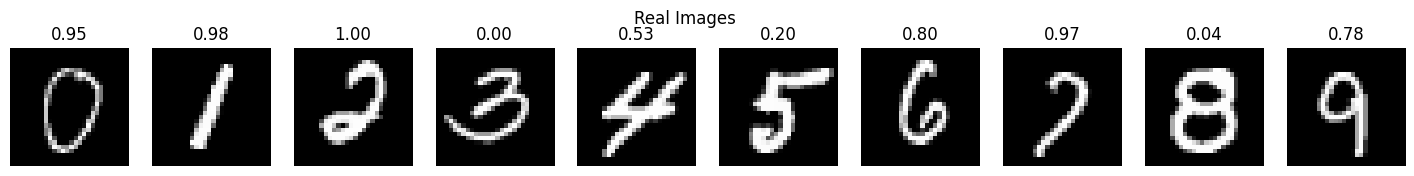

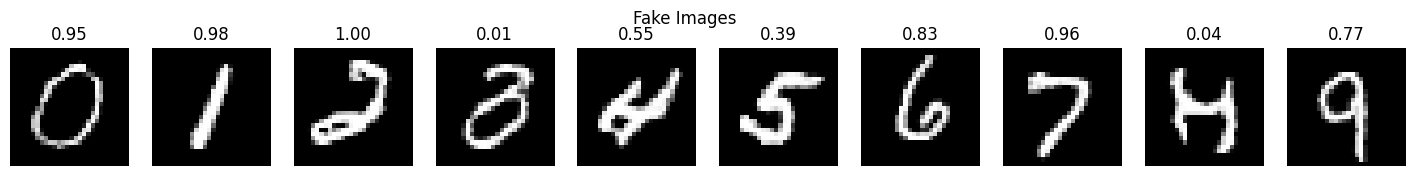

600/600 [==============================] - 114s 190ms/step - g_loss: 0.7039 - g_total_loss: 0.7120 - d_loss: 0.6892 - f_acc: 0.4964 - r_acc: 0.5035
Epoch 119/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7035 - g_total_loss: 0.7118 - d_loss: 0.6896 - f_acc: 0.4966 - r_acc: 0.5034

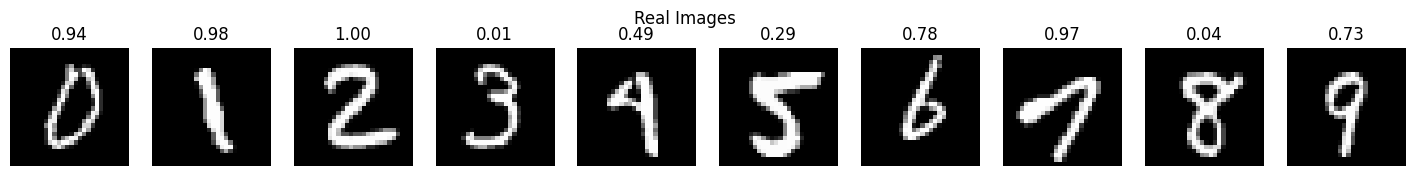

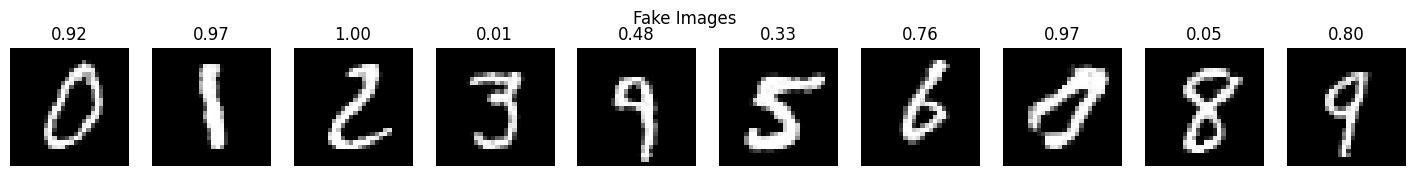

600/600 [==============================] - 114s 189ms/step - g_loss: 0.7035 - g_total_loss: 0.7118 - d_loss: 0.6896 - f_acc: 0.4966 - r_acc: 0.5034
Epoch 120/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7041 - g_total_loss: 0.7124 - d_loss: 0.6893 - f_acc: 0.4964 - r_acc: 0.5035

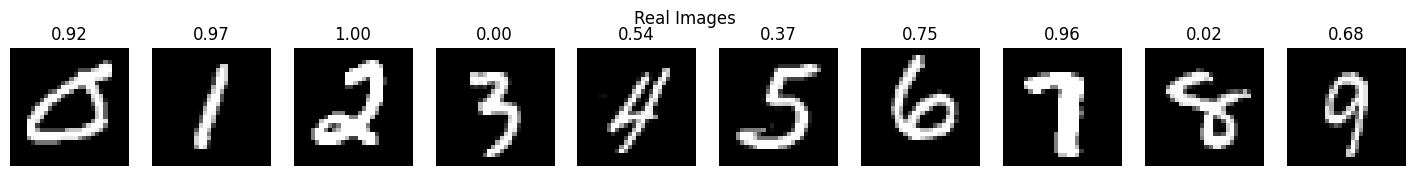

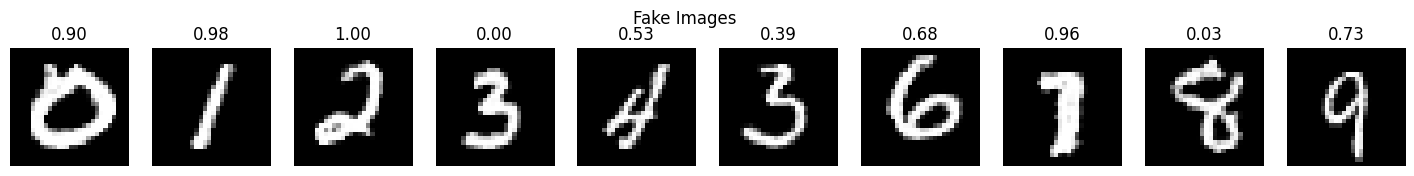

600/600 [==============================] - 112s 186ms/step - g_loss: 0.7041 - g_total_loss: 0.7124 - d_loss: 0.6893 - f_acc: 0.4964 - r_acc: 0.5035
Epoch 121/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7038 - g_total_loss: 0.7121 - d_loss: 0.6896 - f_acc: 0.4965 - r_acc: 0.5034

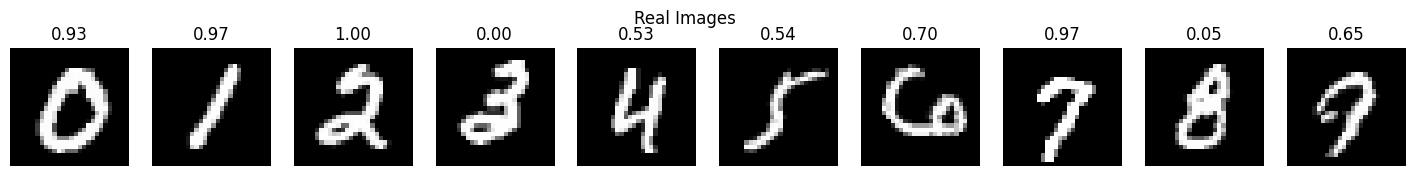

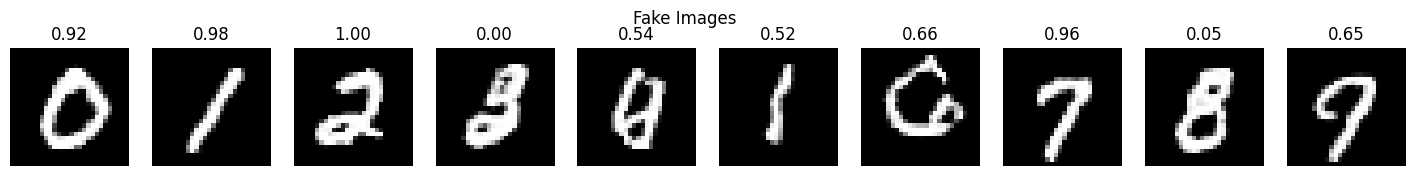

600/600 [==============================] - 114s 190ms/step - g_loss: 0.7038 - g_total_loss: 0.7121 - d_loss: 0.6896 - f_acc: 0.4965 - r_acc: 0.5034
Epoch 122/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7041 - g_total_loss: 0.7124 - d_loss: 0.6897 - f_acc: 0.4964 - r_acc: 0.5033

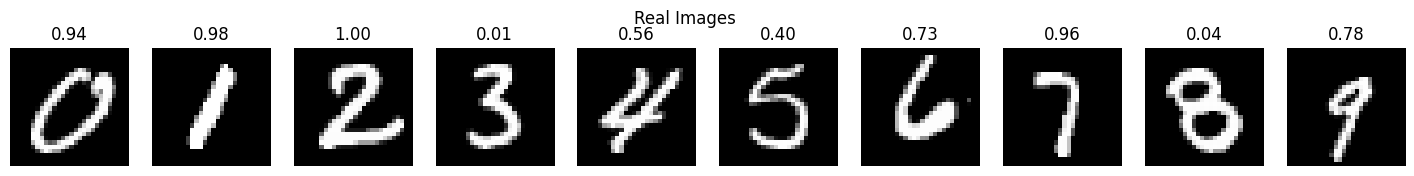

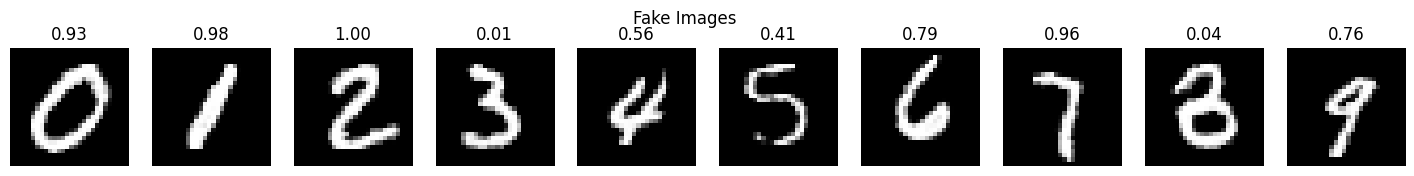

600/600 [==============================] - 113s 188ms/step - g_loss: 0.7041 - g_total_loss: 0.7124 - d_loss: 0.6897 - f_acc: 0.4964 - r_acc: 0.5033
Epoch 123/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7038 - g_total_loss: 0.7121 - d_loss: 0.6898 - f_acc: 0.4965 - r_acc: 0.5032

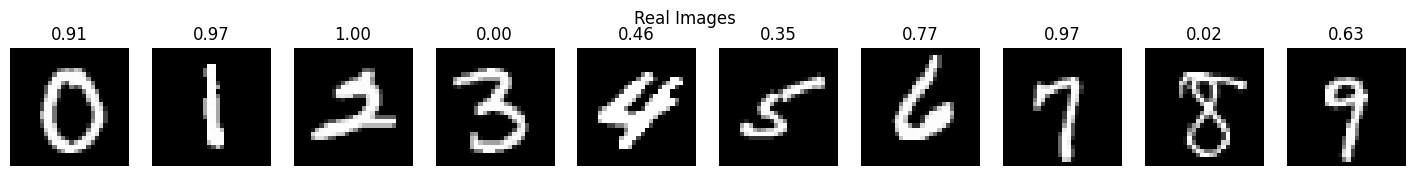

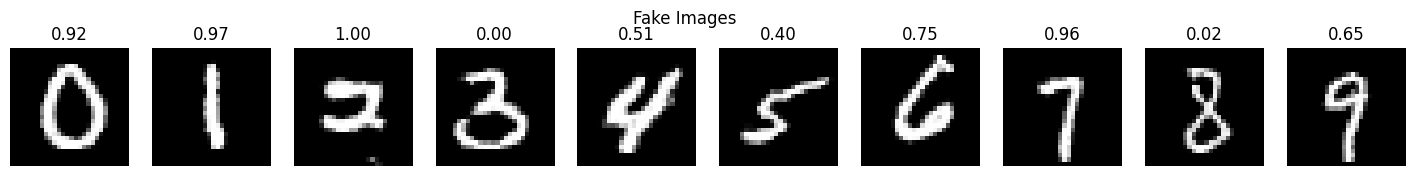

600/600 [==============================] - 113s 188ms/step - g_loss: 0.7038 - g_total_loss: 0.7121 - d_loss: 0.6898 - f_acc: 0.4965 - r_acc: 0.5032
Epoch 124/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7034 - g_total_loss: 0.7116 - d_loss: 0.6897 - f_acc: 0.4967 - r_acc: 0.5034

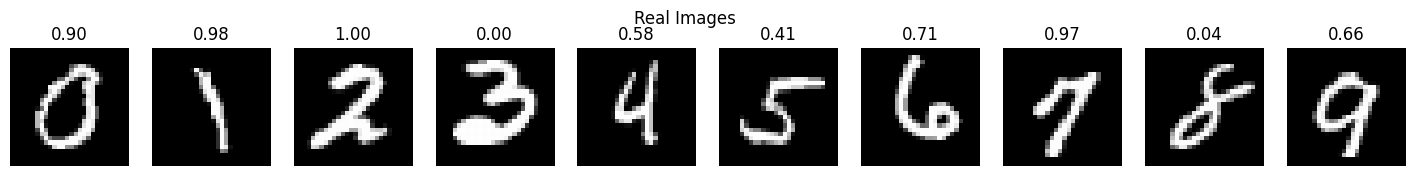

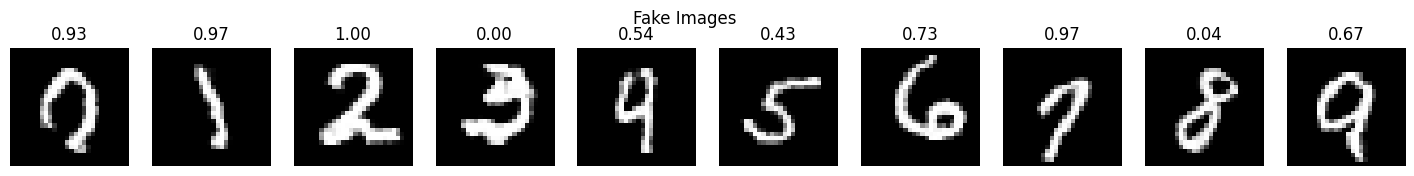

600/600 [==============================] - 113s 188ms/step - g_loss: 0.7034 - g_total_loss: 0.7116 - d_loss: 0.6897 - f_acc: 0.4967 - r_acc: 0.5034
Epoch 125/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7035 - g_total_loss: 0.7117 - d_loss: 0.6896 - f_acc: 0.4966 - r_acc: 0.5032

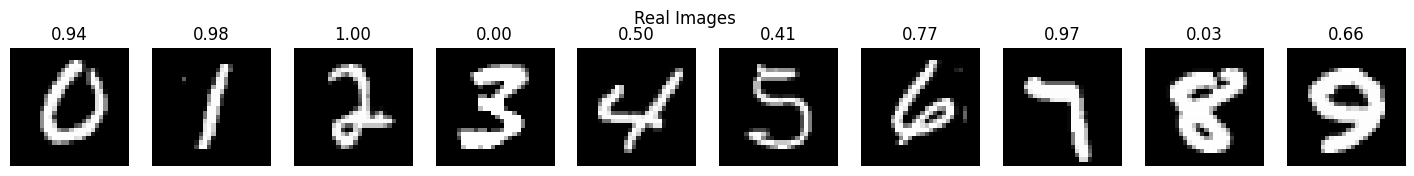

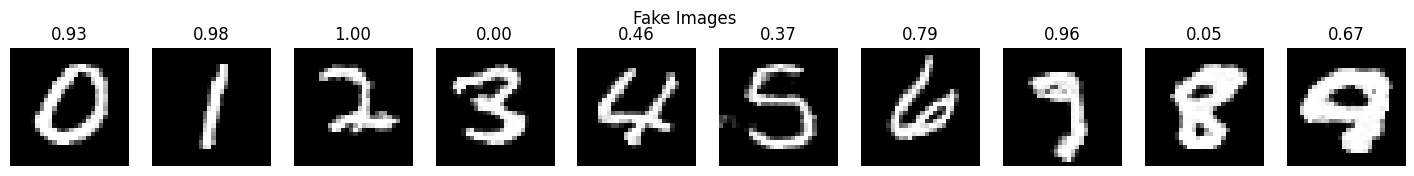

600/600 [==============================] - 114s 190ms/step - g_loss: 0.7035 - g_total_loss: 0.7117 - d_loss: 0.6896 - f_acc: 0.4966 - r_acc: 0.5032
Epoch 126/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7035 - g_total_loss: 0.7117 - d_loss: 0.6896 - f_acc: 0.4966 - r_acc: 0.5033

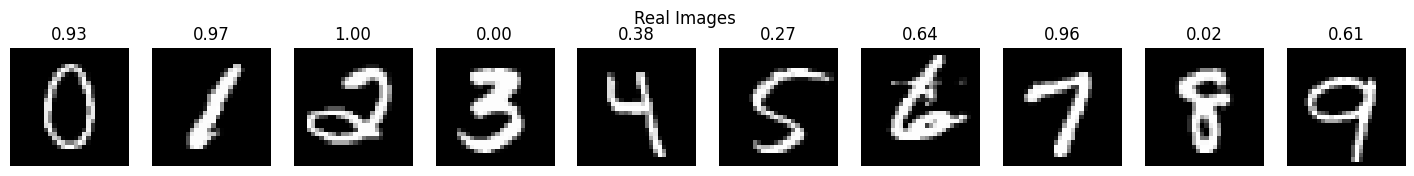

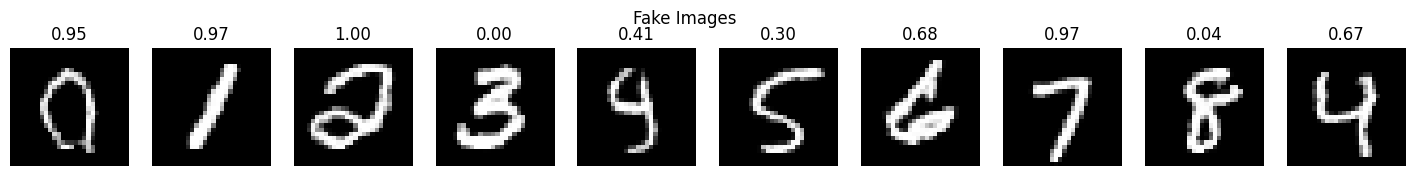

600/600 [==============================] - 114s 189ms/step - g_loss: 0.7035 - g_total_loss: 0.7117 - d_loss: 0.6896 - f_acc: 0.4966 - r_acc: 0.5033
Epoch 127/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7041 - g_total_loss: 0.7122 - d_loss: 0.6896 - f_acc: 0.4965 - r_acc: 0.5035

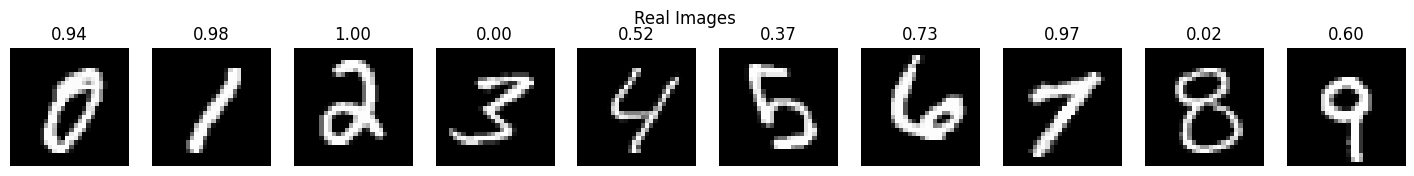

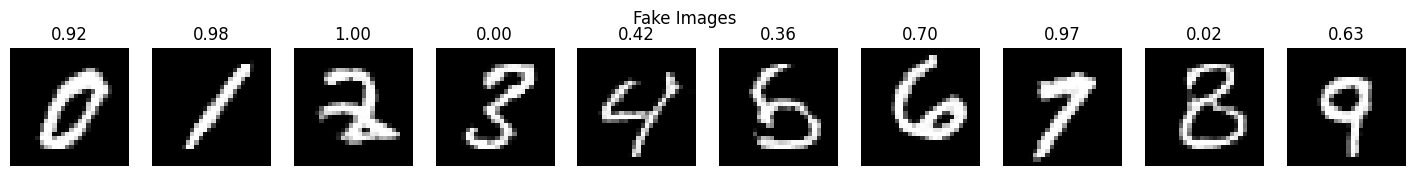

600/600 [==============================] - 113s 189ms/step - g_loss: 0.7041 - g_total_loss: 0.7122 - d_loss: 0.6896 - f_acc: 0.4965 - r_acc: 0.5035
Epoch 128/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7032 - g_total_loss: 0.7111 - d_loss: 0.6896 - f_acc: 0.4967 - r_acc: 0.5033

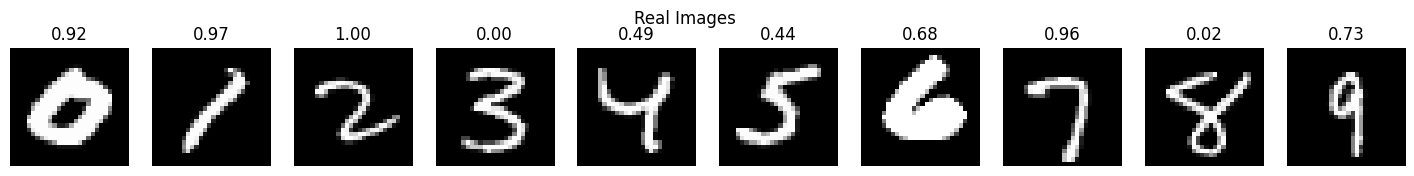

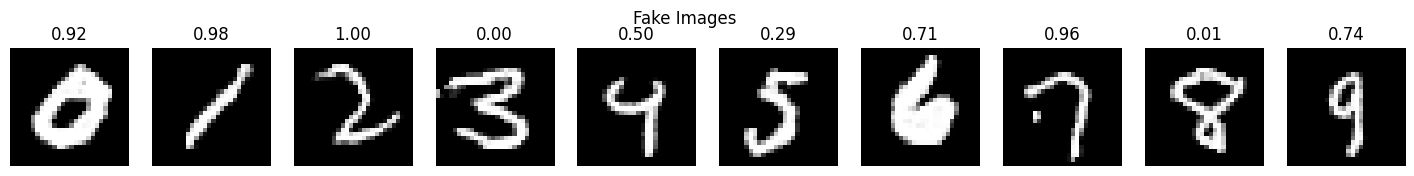

600/600 [==============================] - 112s 187ms/step - g_loss: 0.7032 - g_total_loss: 0.7111 - d_loss: 0.6896 - f_acc: 0.4967 - r_acc: 0.5033
Epoch 129/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7033 - g_total_loss: 0.7114 - d_loss: 0.6898 - f_acc: 0.4967 - r_acc: 0.5032

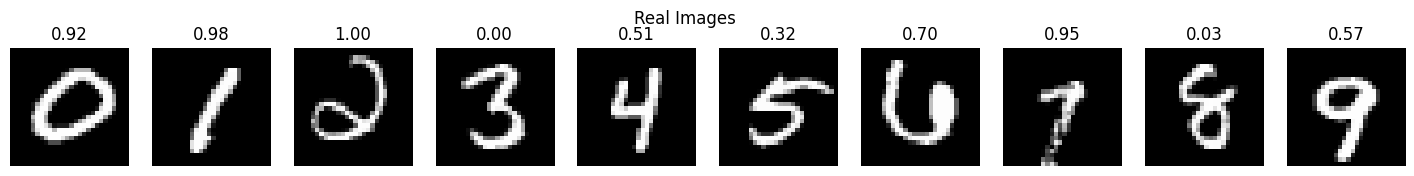

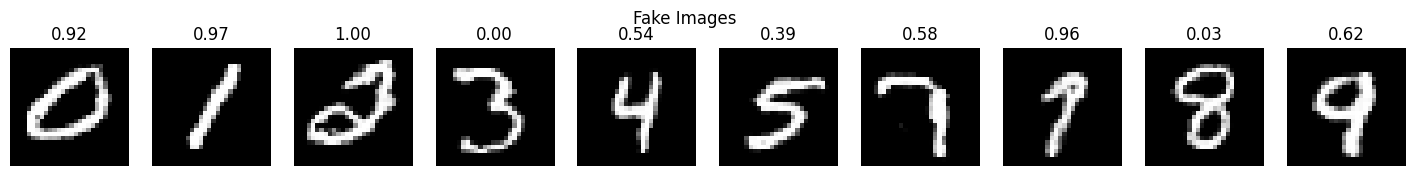

600/600 [==============================] - 113s 189ms/step - g_loss: 0.7033 - g_total_loss: 0.7114 - d_loss: 0.6898 - f_acc: 0.4967 - r_acc: 0.5032
Epoch 130/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7036 - g_total_loss: 0.7117 - d_loss: 0.6896 - f_acc: 0.4966 - r_acc: 0.5034

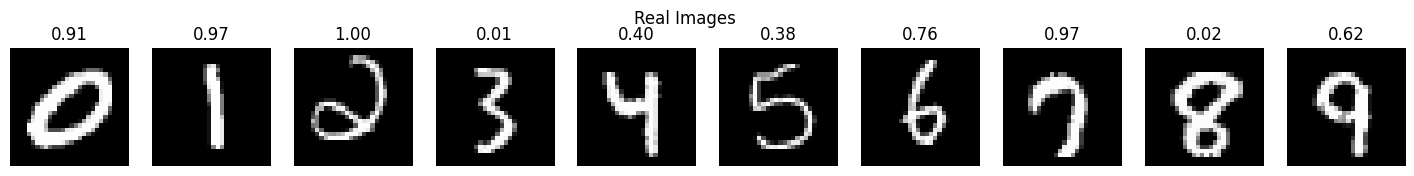

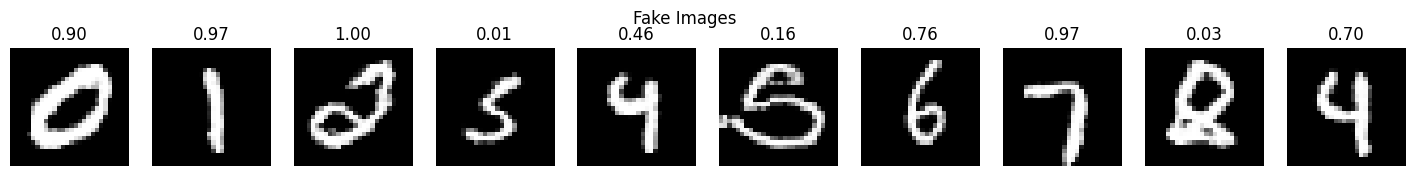

600/600 [==============================] - 112s 186ms/step - g_loss: 0.7036 - g_total_loss: 0.7117 - d_loss: 0.6896 - f_acc: 0.4966 - r_acc: 0.5034
Epoch 131/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7038 - g_total_loss: 0.7119 - d_loss: 0.6897 - f_acc: 0.4964 - r_acc: 0.5031

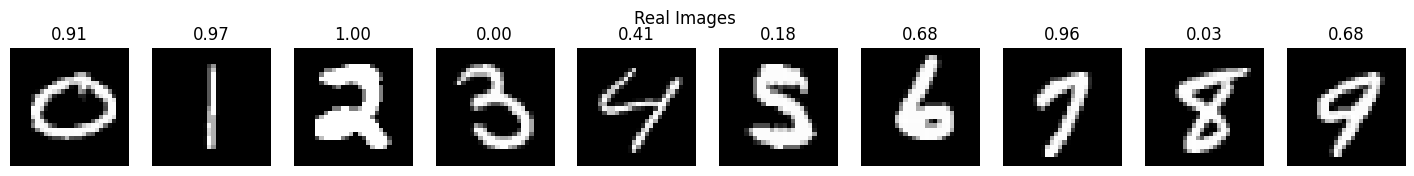

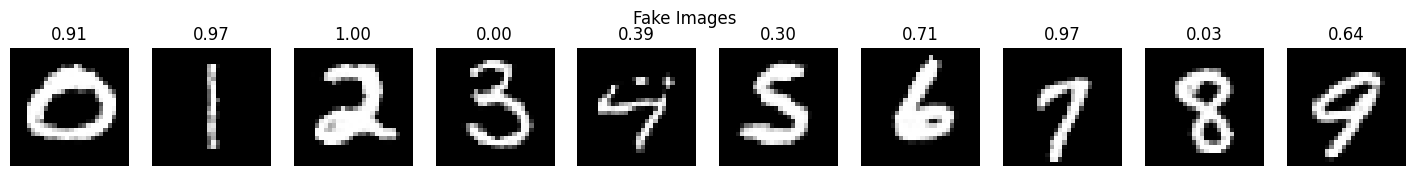

600/600 [==============================] - 111s 185ms/step - g_loss: 0.7038 - g_total_loss: 0.7119 - d_loss: 0.6897 - f_acc: 0.4964 - r_acc: 0.5031
Epoch 132/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7041 - g_total_loss: 0.7123 - d_loss: 0.6898 - f_acc: 0.4964 - r_acc: 0.5031

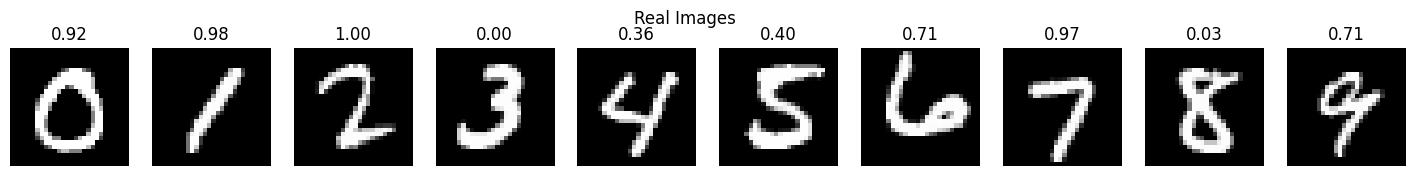

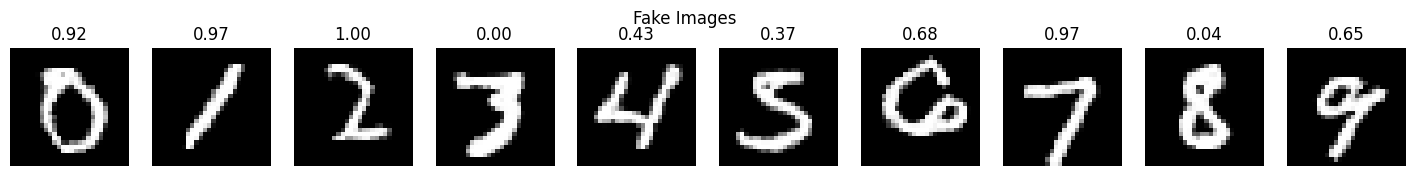

600/600 [==============================] - 112s 187ms/step - g_loss: 0.7041 - g_total_loss: 0.7123 - d_loss: 0.6898 - f_acc: 0.4964 - r_acc: 0.5031
Epoch 133/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7034 - g_total_loss: 0.7117 - d_loss: 0.6897 - f_acc: 0.4966 - r_acc: 0.5034

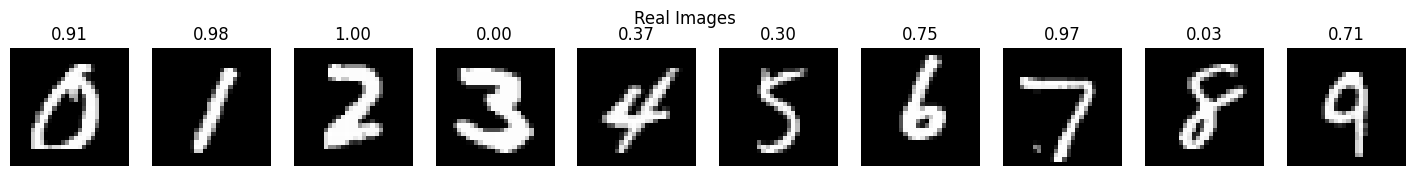

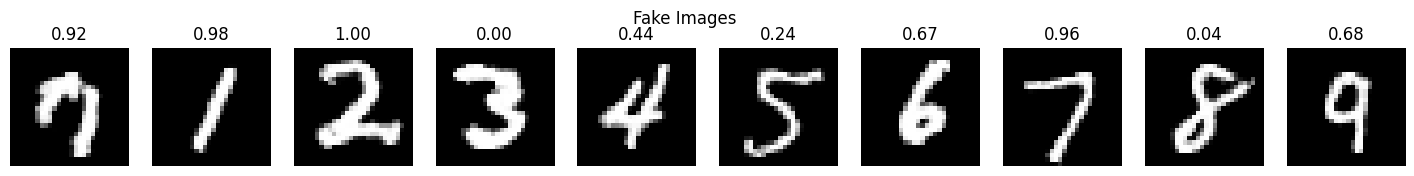

600/600 [==============================] - 116s 194ms/step - g_loss: 0.7034 - g_total_loss: 0.7117 - d_loss: 0.6897 - f_acc: 0.4966 - r_acc: 0.5034
Epoch 134/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7033 - g_total_loss: 0.7115 - d_loss: 0.6898 - f_acc: 0.4967 - r_acc: 0.5032

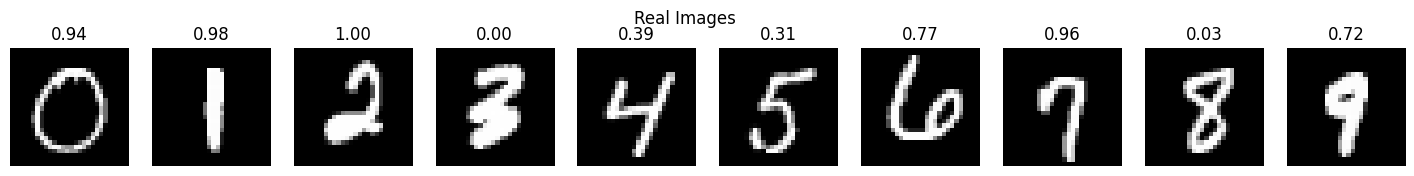

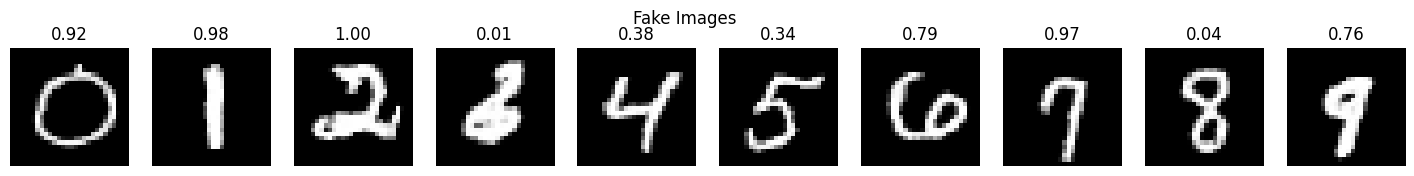

600/600 [==============================] - 122s 204ms/step - g_loss: 0.7033 - g_total_loss: 0.7115 - d_loss: 0.6898 - f_acc: 0.4967 - r_acc: 0.5032
Epoch 135/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7033 - g_total_loss: 0.7114 - d_loss: 0.6901 - f_acc: 0.4967 - r_acc: 0.5030

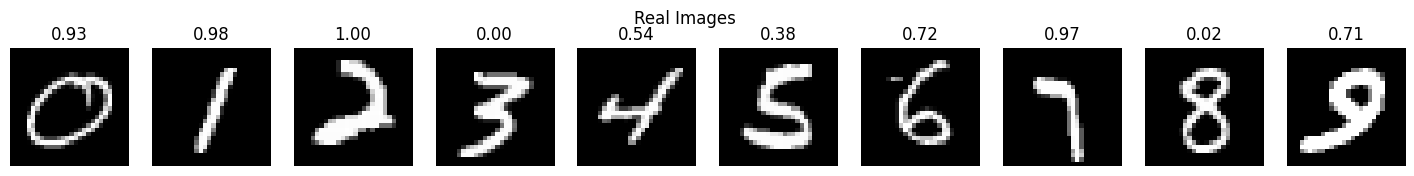

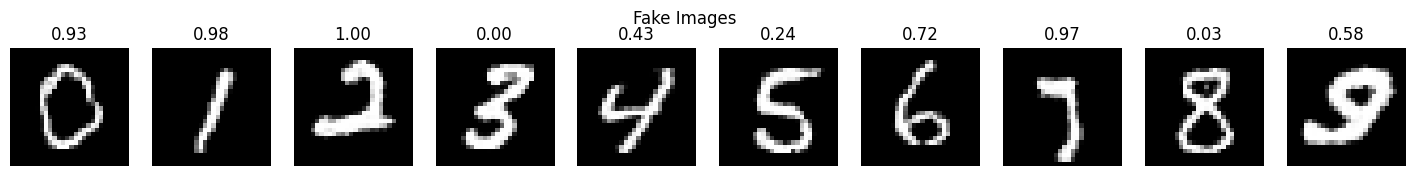

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7033 - g_total_loss: 0.7114 - d_loss: 0.6901 - f_acc: 0.4967 - r_acc: 0.5030
Epoch 136/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7030 - g_total_loss: 0.7111 - d_loss: 0.6901 - f_acc: 0.4968 - r_acc: 0.5031

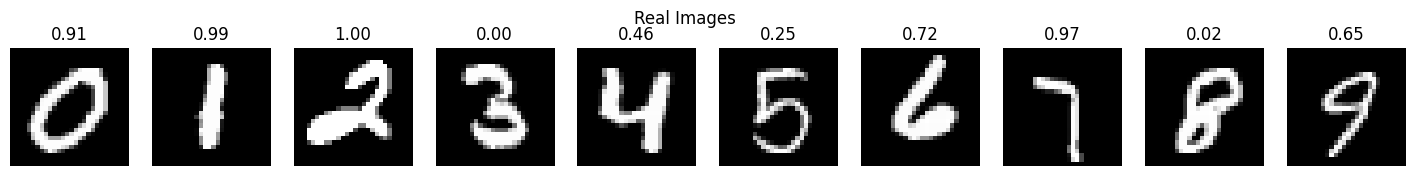

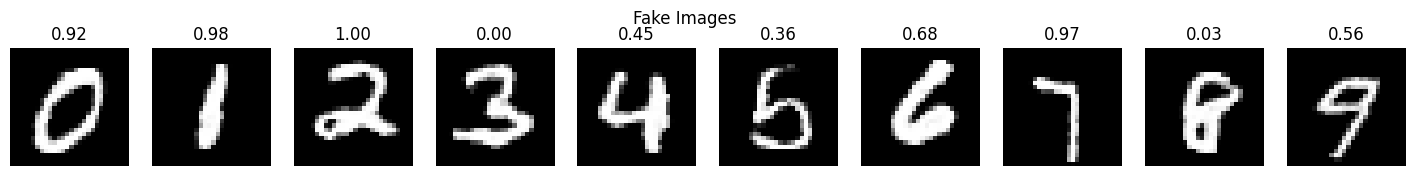

600/600 [==============================] - 114s 189ms/step - g_loss: 0.7030 - g_total_loss: 0.7111 - d_loss: 0.6901 - f_acc: 0.4968 - r_acc: 0.5031
Epoch 137/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7034 - g_total_loss: 0.7116 - d_loss: 0.6896 - f_acc: 0.4966 - r_acc: 0.5033

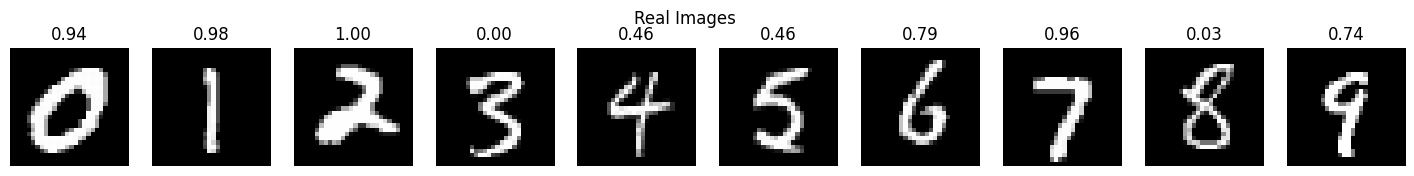

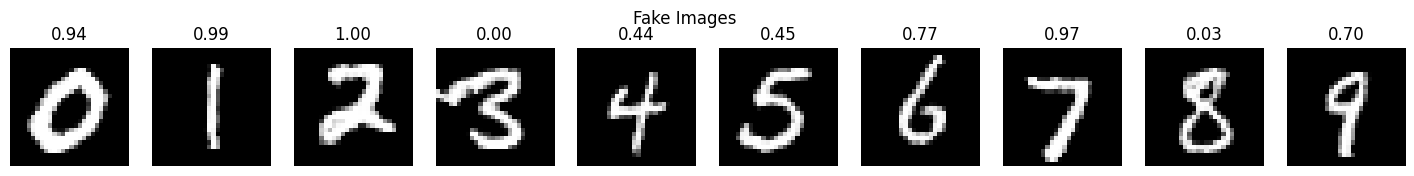

600/600 [==============================] - 114s 191ms/step - g_loss: 0.7034 - g_total_loss: 0.7116 - d_loss: 0.6896 - f_acc: 0.4966 - r_acc: 0.5033
Epoch 138/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7031 - g_total_loss: 0.7111 - d_loss: 0.6899 - f_acc: 0.4967 - r_acc: 0.5031

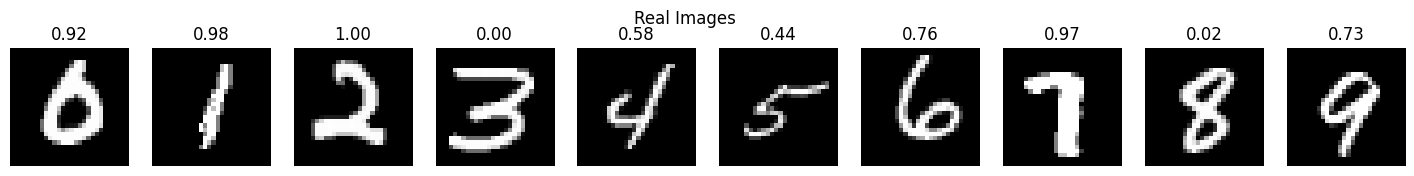

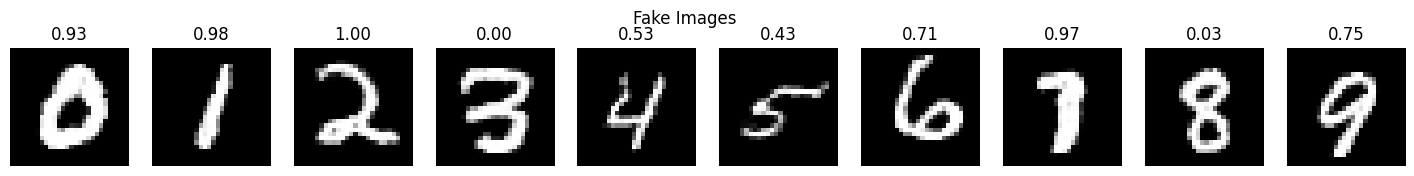

600/600 [==============================] - 117s 196ms/step - g_loss: 0.7031 - g_total_loss: 0.7111 - d_loss: 0.6899 - f_acc: 0.4967 - r_acc: 0.5031
Epoch 139/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7024 - g_total_loss: 0.7104 - d_loss: 0.6903 - f_acc: 0.4971 - r_acc: 0.5030

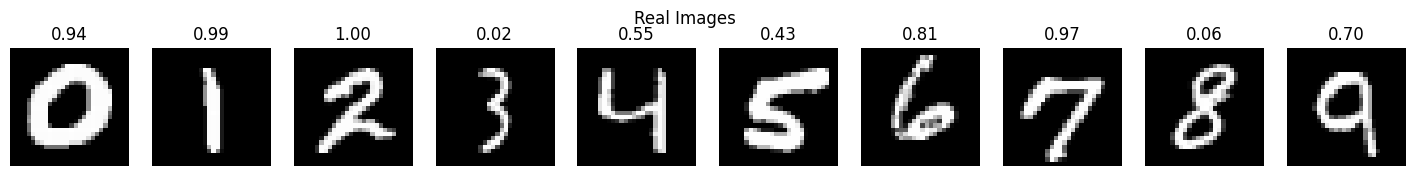

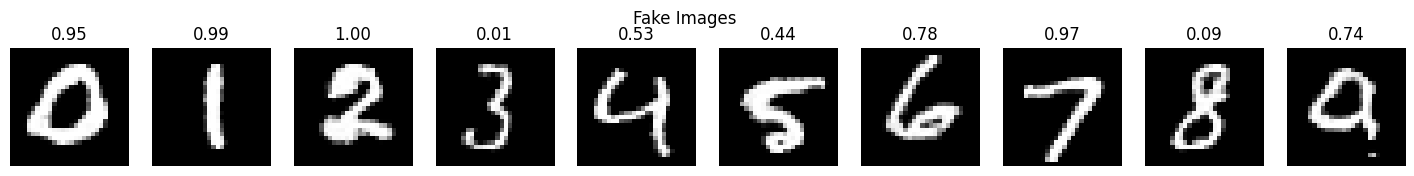

600/600 [==============================] - 118s 196ms/step - g_loss: 0.7024 - g_total_loss: 0.7104 - d_loss: 0.6903 - f_acc: 0.4971 - r_acc: 0.5030
Epoch 140/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7031 - g_total_loss: 0.7111 - d_loss: 0.6902 - f_acc: 0.4967 - r_acc: 0.5028

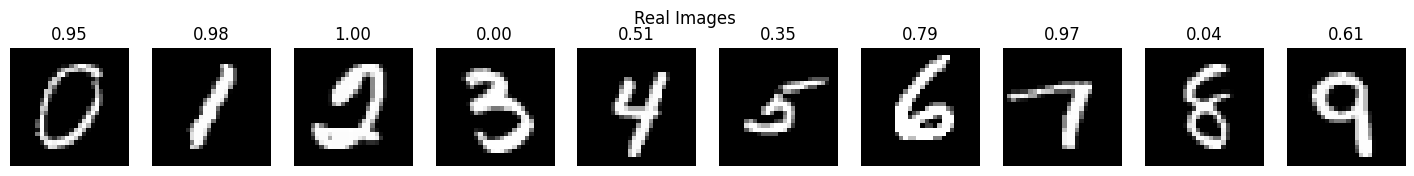

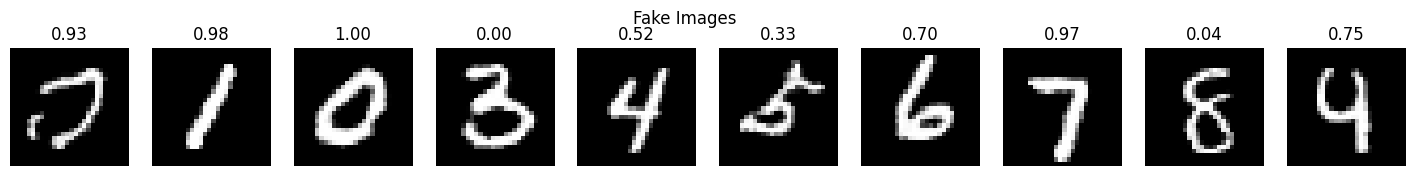

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7031 - g_total_loss: 0.7111 - d_loss: 0.6902 - f_acc: 0.4967 - r_acc: 0.5028
Epoch 141/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7032 - g_total_loss: 0.7114 - d_loss: 0.6899 - f_acc: 0.4966 - r_acc: 0.5031

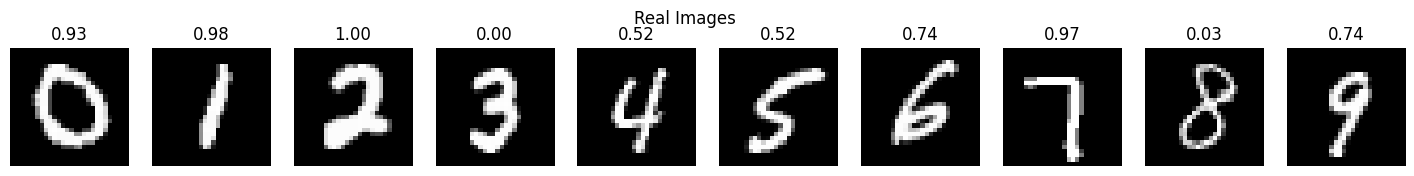

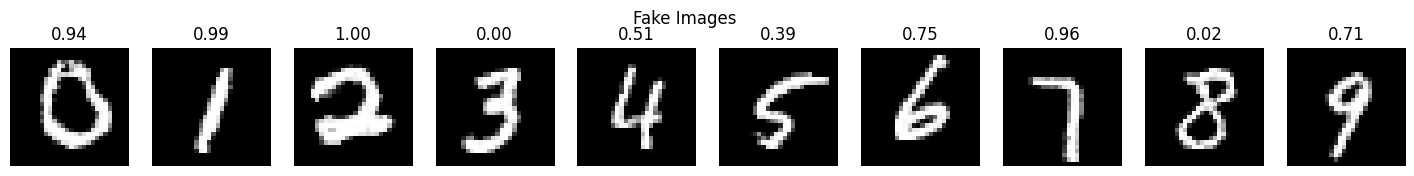

600/600 [==============================] - 115s 192ms/step - g_loss: 0.7032 - g_total_loss: 0.7114 - d_loss: 0.6899 - f_acc: 0.4966 - r_acc: 0.5031
Epoch 142/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7031 - g_total_loss: 0.7111 - d_loss: 0.6901 - f_acc: 0.4967 - r_acc: 0.5029

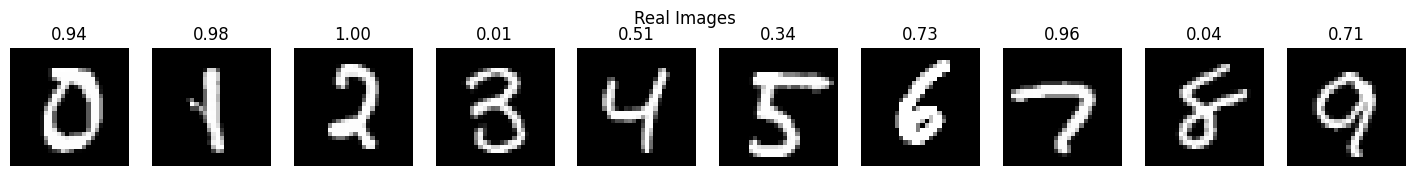

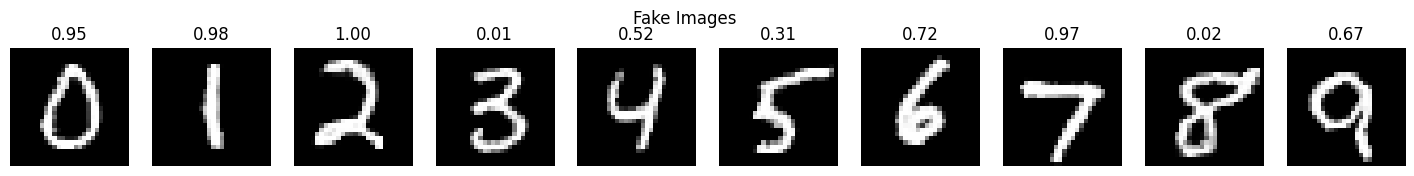

600/600 [==============================] - 116s 194ms/step - g_loss: 0.7031 - g_total_loss: 0.7111 - d_loss: 0.6901 - f_acc: 0.4967 - r_acc: 0.5029
Epoch 143/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7032 - g_total_loss: 0.7113 - d_loss: 0.6899 - f_acc: 0.4967 - r_acc: 0.5031

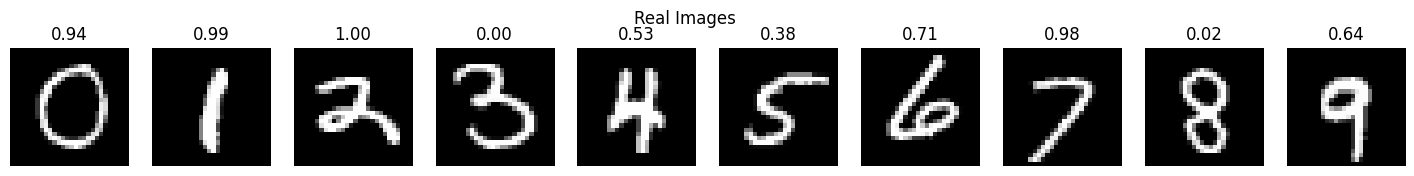

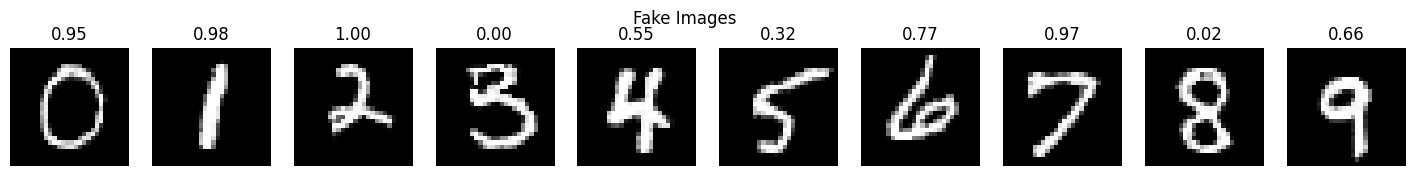

600/600 [==============================] - 118s 196ms/step - g_loss: 0.7032 - g_total_loss: 0.7113 - d_loss: 0.6899 - f_acc: 0.4967 - r_acc: 0.5031
Epoch 144/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7027 - g_total_loss: 0.7107 - d_loss: 0.6898 - f_acc: 0.4968 - r_acc: 0.5033

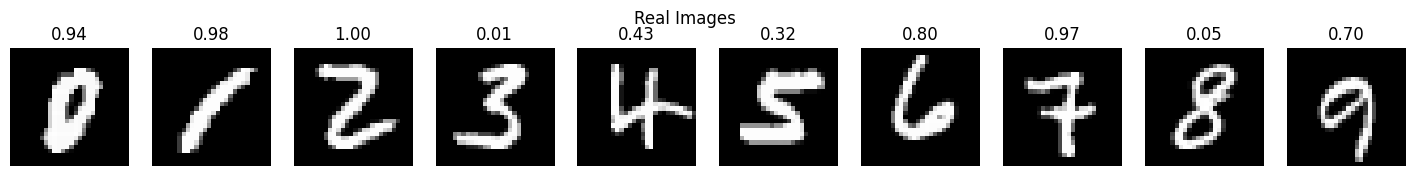

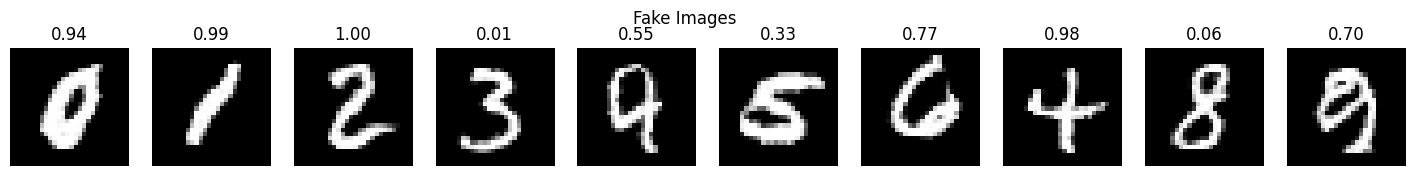

600/600 [==============================] - 116s 193ms/step - g_loss: 0.7027 - g_total_loss: 0.7107 - d_loss: 0.6898 - f_acc: 0.4968 - r_acc: 0.5033
Epoch 145/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7031 - g_total_loss: 0.7111 - d_loss: 0.6897 - f_acc: 0.4966 - r_acc: 0.5031

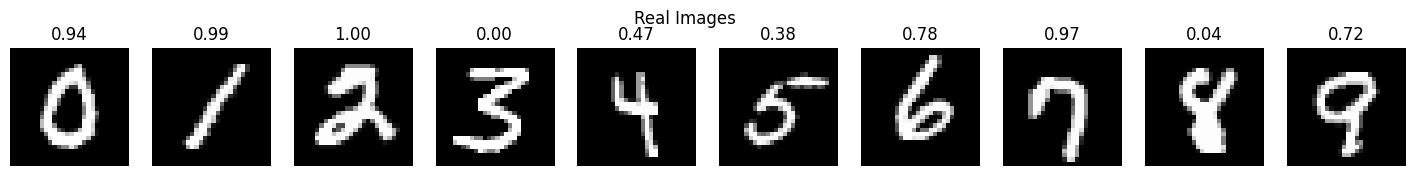

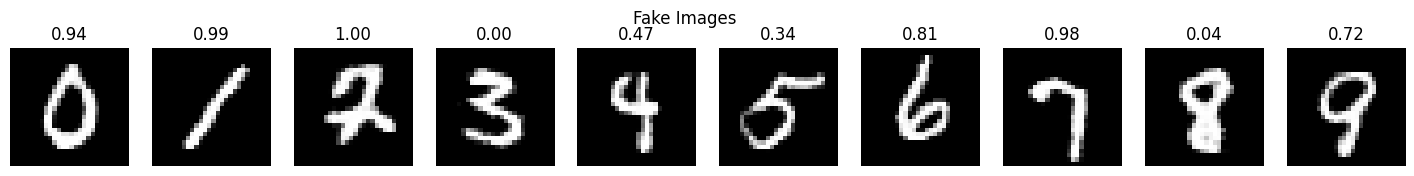

600/600 [==============================] - 118s 197ms/step - g_loss: 0.7031 - g_total_loss: 0.7111 - d_loss: 0.6897 - f_acc: 0.4966 - r_acc: 0.5031
Epoch 146/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7033 - g_total_loss: 0.7116 - d_loss: 0.6901 - f_acc: 0.4967 - r_acc: 0.5033

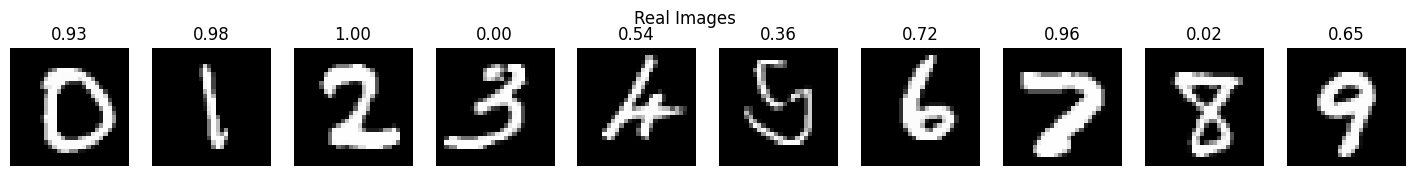

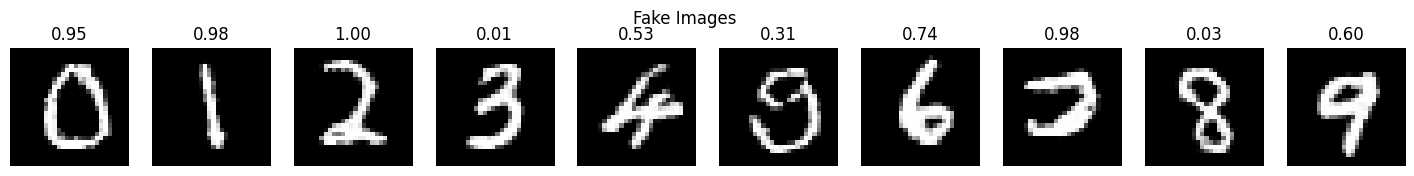

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7033 - g_total_loss: 0.7116 - d_loss: 0.6901 - f_acc: 0.4967 - r_acc: 0.5033
Epoch 147/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7030 - g_total_loss: 0.7110 - d_loss: 0.6901 - f_acc: 0.4968 - r_acc: 0.5030

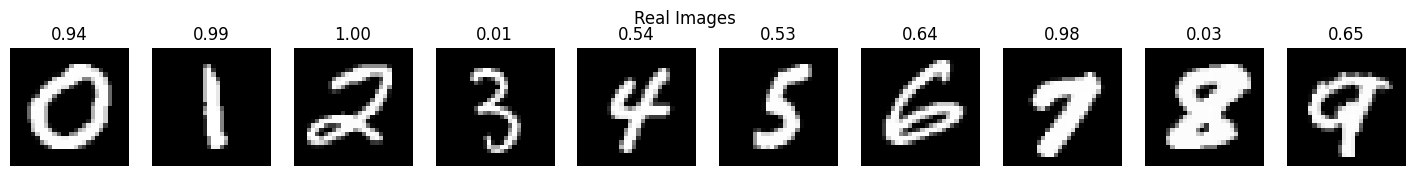

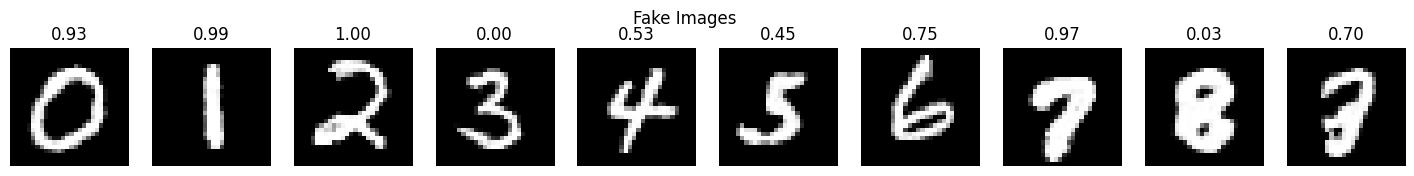

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7030 - g_total_loss: 0.7109 - d_loss: 0.6901 - f_acc: 0.4968 - r_acc: 0.5030
Epoch 148/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7025 - g_total_loss: 0.7103 - d_loss: 0.6900 - f_acc: 0.4969 - r_acc: 0.5029

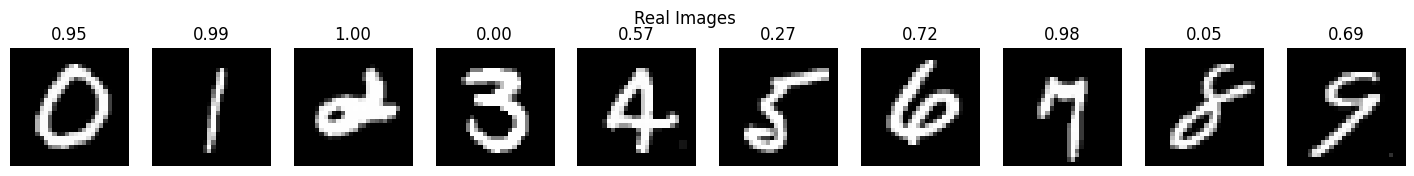

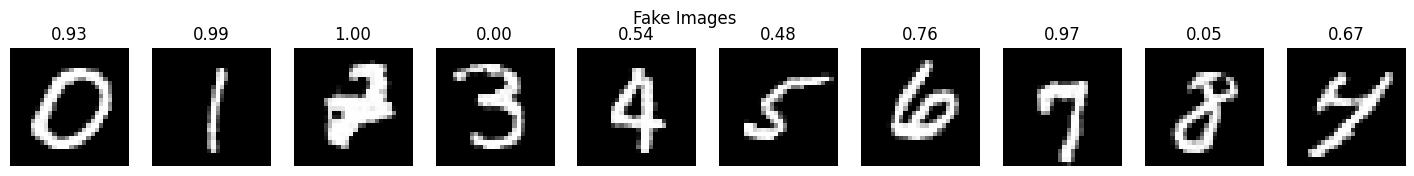

600/600 [==============================] - 117s 195ms/step - g_loss: 0.7025 - g_total_loss: 0.7103 - d_loss: 0.6900 - f_acc: 0.4969 - r_acc: 0.5029
Epoch 149/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7021 - g_total_loss: 0.7100 - d_loss: 0.6905 - f_acc: 0.4971 - r_acc: 0.5029

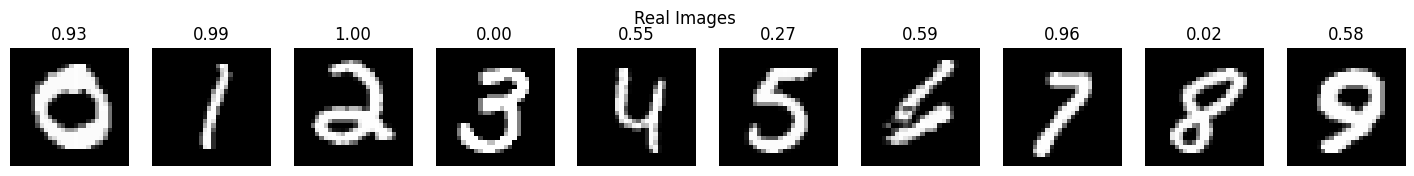

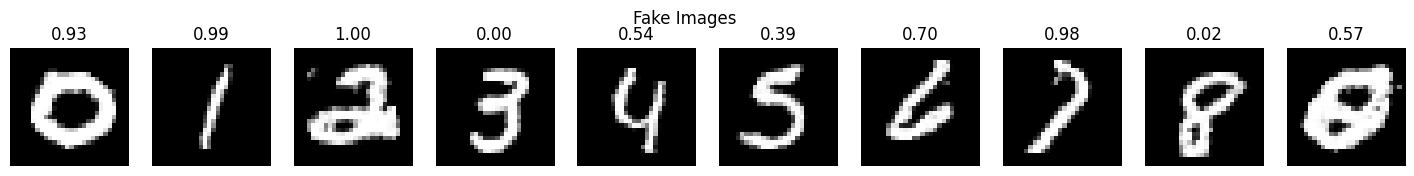

600/600 [==============================] - 120s 199ms/step - g_loss: 0.7021 - g_total_loss: 0.7100 - d_loss: 0.6905 - f_acc: 0.4971 - r_acc: 0.5029
Epoch 150/150
600/600 [==============================] - ETA: 0s - g_loss: 0.7027 - g_total_loss: 0.7107 - d_loss: 0.6902 - f_acc: 0.4968 - r_acc: 0.5030

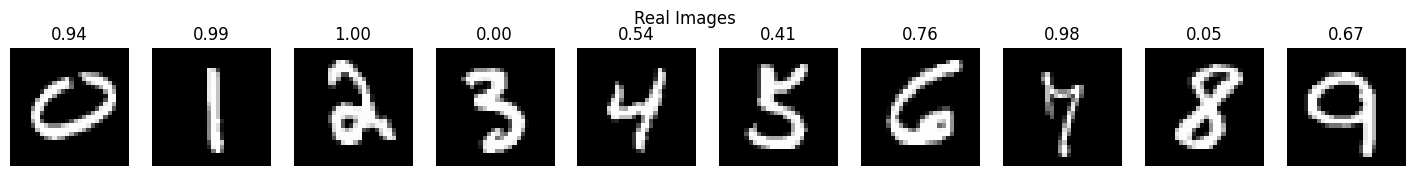

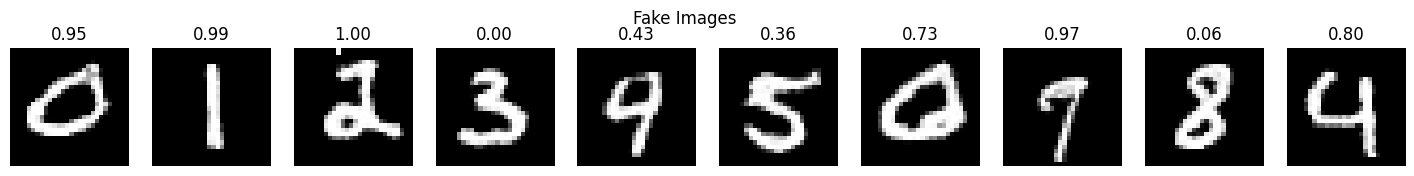

600/600 [==============================] - 128s 213ms/step - g_loss: 0.7027 - g_total_loss: 0.7107 - d_loss: 0.6902 - f_acc: 0.4968 - r_acc: 0.5030


In [18]:
# Initialize the ConditionalGAN with the specified GAN model and regularization factor.
# The regularizer influences the generator's loss to avoid overfitting or to enforce additional constraints.
cond_gan = ConditionalGAN(
    gan_model=gan_model,  # The GAN model consisting of both generator and discriminator models.
    regularizer=1  # Regularization factor applied to the generator's loss.
)

# Print summaries of the generator and discriminator to verify their architectures.
# This is useful for debugging and ensuring the models are correctly configured.
cond_gan.generator.summary()
cond_gan.discriminator.summary()

# Compile the ConditionalGAN with optimizers and loss function.
# This step prepares the model for training by setting the optimization algorithms and the loss computation method.
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Optimizer for the discriminator with a learning rate of 0.0001.
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),  # Optimizer for the generator with a learning rate of 0.0002.
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),  # Loss function to measure how well the GAN performs.
)

# Train the ConditionalGAN using the provided dataset.
# Training involves alternating between training the discriminator and the generator.
# The OptimizedVisualizer callback is used to visualize the progress of training by comparing generated images to real images.
history = cond_gan.fit(
    dataset,  # The training dataset.
    epochs=150,  # Number of epochs to train for.
    callbacks=[
        OptimizedVisualizer(
            cond_gan.generator,  # Pass the generator model for image generation.
            cond_gan.discriminator,  # Pass the discriminator model for evaluation.
            x_test,  # Real images to compare against the generated ones.
            y_test_original  # Labels of the real images for conditional generation.
        )
    ]
)


In [19]:
cond_gan.generator.save('gen_p2.h5')
cond_gan.discriminator.save('dis_p2.h5')

c:\Users\anant\.conda\envs\gpu-env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# Save the history object itself
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

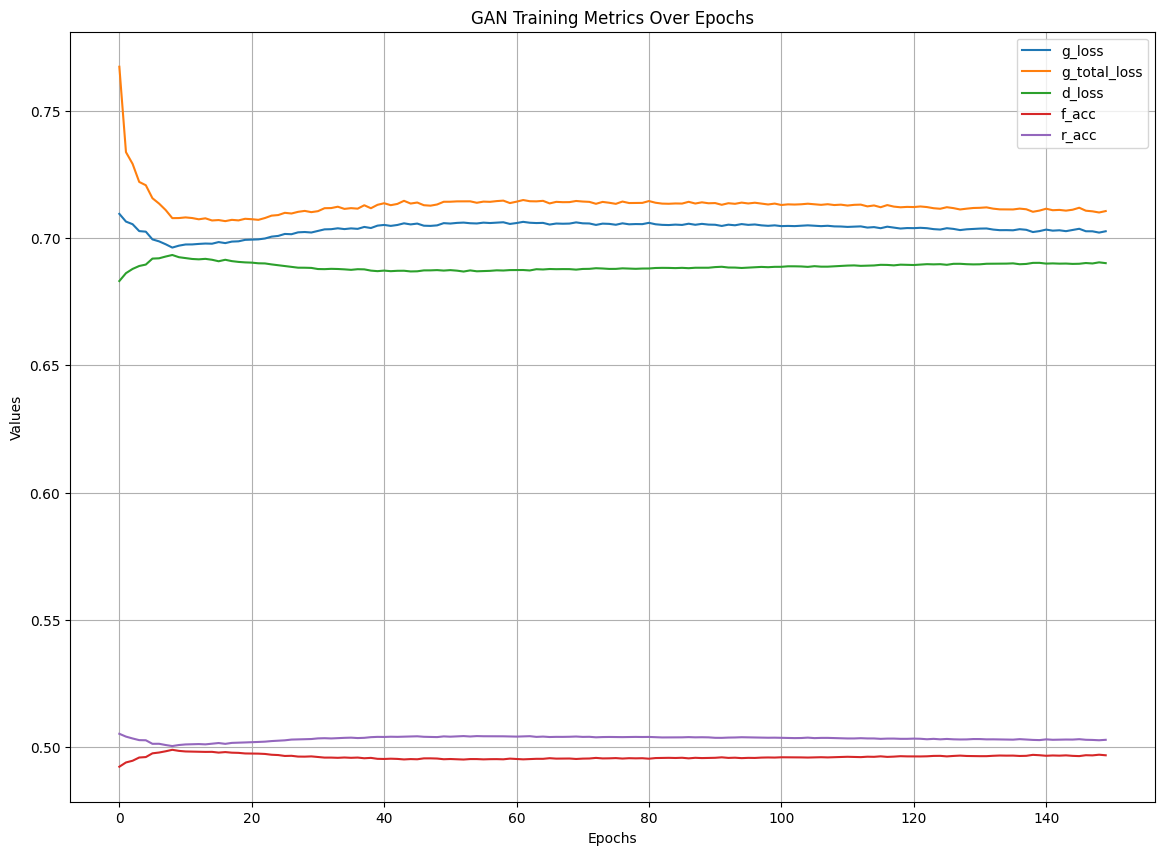

In [30]:
plt.figure(figsize=(14, 10))

plt.plot(history.history['g_loss'], label="g_loss")
plt.plot(history.history['g_total_loss'], label="g_total_loss")
plt.plot(history.history['d_loss'], label="d_loss")
plt.plot(history.history['f_acc'], label="f_acc")
plt.plot(history.history['r_acc'], label="r_acc")

plt.title("GAN Training Metrics Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Values")
plt.legend()
plt.grid(True)

plt.show()

# Testing Model Performace

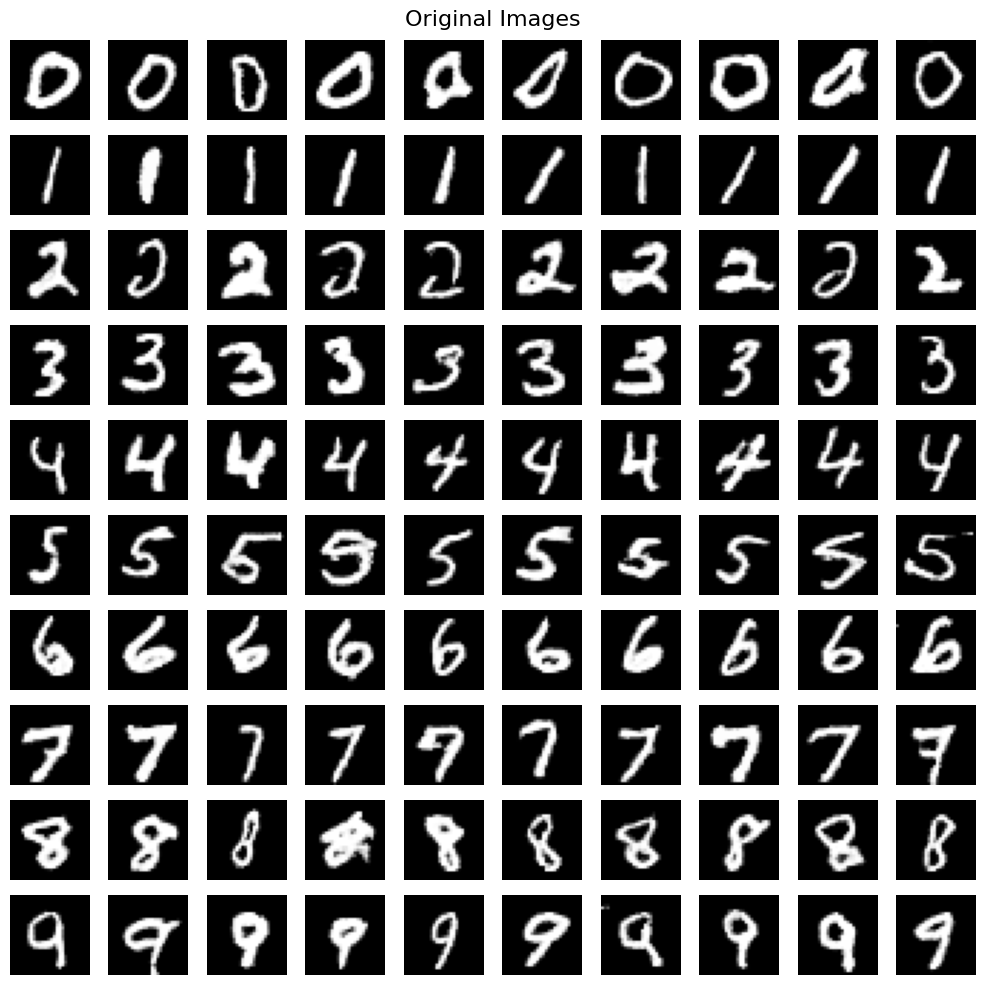

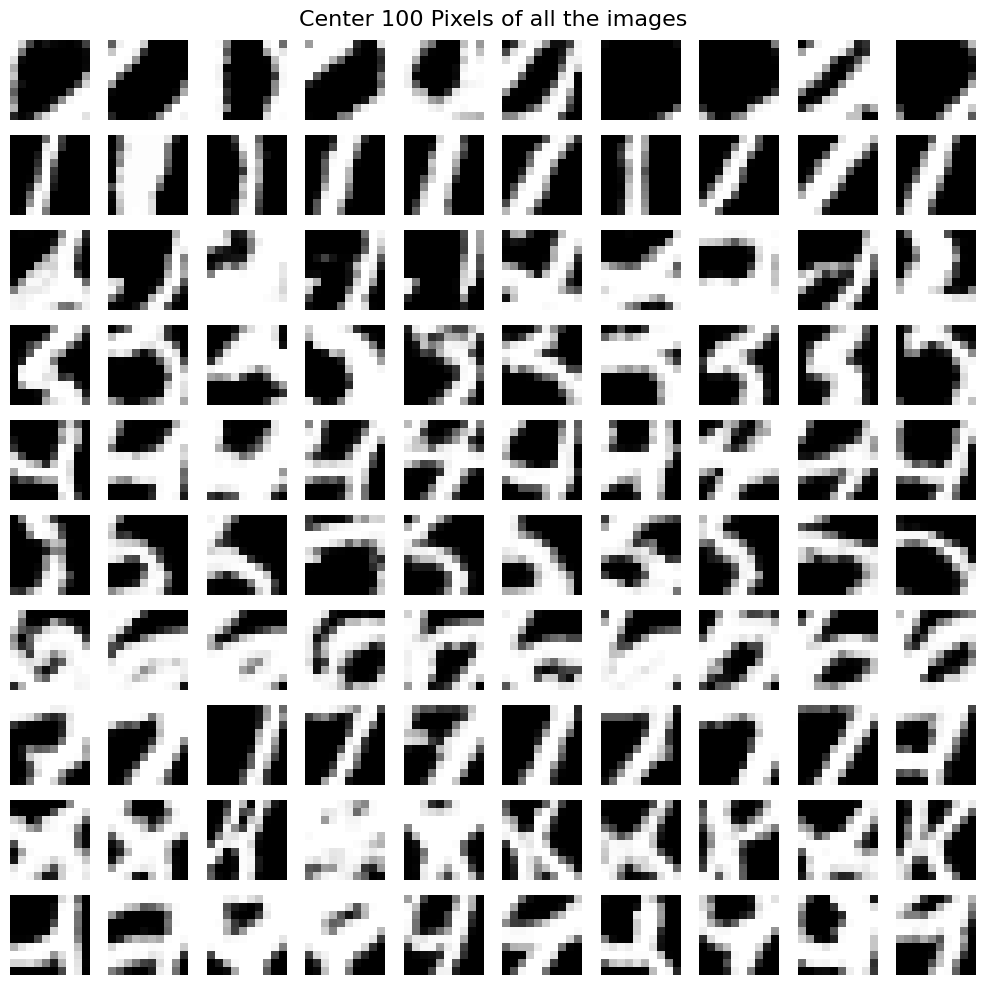

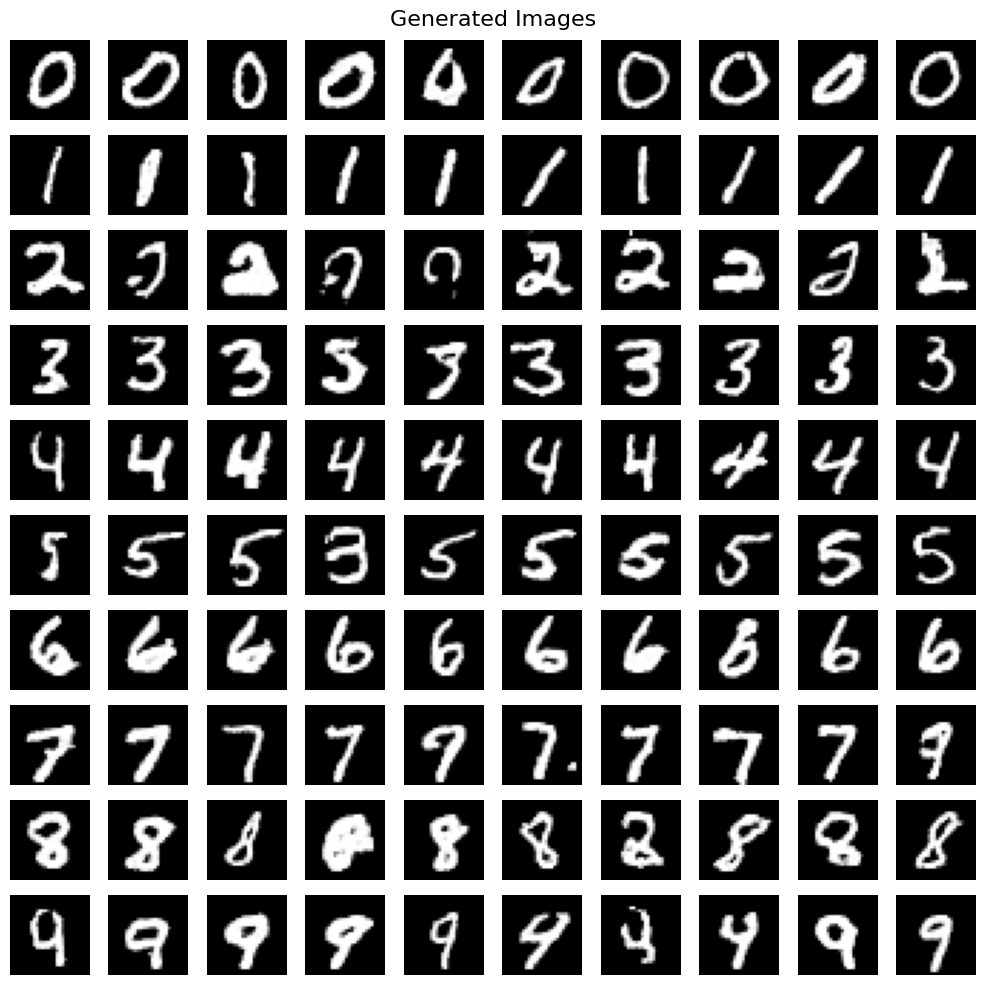

In [31]:
class TestClass:
    """
    A class used to represent an image generation context.
    
    This class is designed to manage the directory where generated images are saved.
    It allows for easy customization of the save directory for generated images produced by an image generating AI model.
    
    Attributes:
    -----------
    save_dir : str
        The directory where generated images will be saved.
        
    Methods:
    --------
    __init__(self, save_dir='generated_images')
        Initializes the TestClass with a specified directory for saving generated images.
    """
    
    def __init__(self, save_dir='generated_images'):
        """
        Initialize the TestClass with a specific save directory for generated images.
        
        Parameters:
        -----------
        save_dir : str, optional
            The directory where generated images will be saved (default is 'generated_images').
        """
        self.save_dir = save_dir  # Set the directory where generated images will be saved.

    def load_and_preprocess_image(self, image_path, color_mode='grayscale', region=None):
        """
        Load an image from a specified path and preprocess it according to the given parameters.

        This method loads an image, optionally converts it to grayscale, normalizes its pixel values
        to the range [0, 1], and crops it to a specified region if provided.

        Parameters:
        -----------
        image_path : str
            The file path or URL to the image to be loaded and preprocessed.
        color_mode : str, optional
            The color mode to load the image. 'grayscale' converts the image to grayscale,
            'rgb' to load the image in RGB mode. Default is 'grayscale'.
        region : tuple of int, optional
            A tuple specifying the cropping region as (start_row, end_row, start_col, end_col).
            If None, the entire image is used. Default is None.

        Returns:
        --------
        img_array : numpy.ndarray
            The preprocessed image as a NumPy array with pixel values normalized to [0, 1].
            If a region is specified, the returned array corresponds to the cropped area.
        """
        # Load the image with the specified color mode
        img = load_img(image_path, color_mode=color_mode) 
        # Convert the image to a NumPy array and normalize pixel values to [0, 1]
        img_array = np.array(img) / 255.0
        
        # If a region is specified, crop the image to that region
        if region is not None:
            img_array = img_array[region[0]:region[1], region[2]:region[3]]
        
        return img_array

    def visualize_images(self, images, title, nrows=10, ncols=10, cmap='gray'):
        """
        Visualize a collection of images in a grid format.

        This function plots the provided images in a grid defined by nrows and ncols,
        applies a colormap (cmap) to the images, and displays them with a specified title.
        
        Parameters:
        -----------
        images : list or numpy.ndarray
            A collection of images to be visualized. Each image should be a numpy array.
        title : str
            The title of the plot to be displayed above the image grid.
        nrows : int, optional
            The number of rows in the image grid (default is 10).
        ncols : int, optional
            The number of columns in the image grid (default is 10).
        cmap : str, optional
            The colormap to be applied to the images (default is 'gray').
            This is useful for visualizing grayscale images.
        
        Returns:
        --------
        None
            Displays a matplotlib plot of the images arranged in a grid.
        """
        # Create a figure and set of subplots with specified size and title
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
        fig.suptitle(title, fontsize=16)  # Set the title of the plot

        axes = axes.flatten()  # Flatten the axes array for easy iteration

        # Iterate over the provided images and the flattened axes array
        for i, img in enumerate(images):
            ax = axes[i]  # Get the current axis
            ax.imshow(img, cmap=cmap)  # Display the current image with the specified colormap
            ax.axis('off')  # Hide the axis

        plt.tight_layout()  # Adjust subplots to fit into the figure area
        plt.show()  # Display the plot


    def visualize_full_images(self):
        """
        Load, preprocess, and visualize a set of images stored in defined directories.

        This method assumes images are organized by class and image indices, 
        following a naming convention of '<class_index>_<image_index>.png'.
        It loads and preprocesses each image using `load_and_preprocess_image` method,
        then visualizes all loaded images using `visualize_images` method.
        
        The images are expected to be saved in the directory specified by `self.save_dir`.
        Visualization groups all the images together under the title 'Original Images'.
        
        Assumes:
        - `self.save_dir` is a valid directory path where images are stored.
        - `self.load_and_preprocess_image` is a method for loading and preprocessing images.
        - `self.visualize_images` is a method for visualizing a list of image arrays.
        
        Returns:
        --------
        None
            This method does not return a value; it visualizes the images directly.
        """
        
        images = []  # Initialize a list to hold preprocessed images

        # Iterate through class and image indices to load and preprocess each image
        for class_index in range(10):  # Assuming 10 classes
            for image_index in range(10):  # Assuming 10 images per class
                image_filename = f"{class_index}_{image_index}.png"  # Construct image filename
                image_path = os.path.join(self.save_dir, image_filename)  # Create full path to image
                img_array = self.load_and_preprocess_image(image_path)  # Load and preprocess the image
                images.append(img_array)  # Append the processed image array to the list
        
        # Visualize the collected images using the `visualize_images` method
        self.visualize_images(images, 'Original Images')


    def visualize_cropped_images(self, crop_region):
        """
        Visualizes cropped areas from a set of images, specified by the crop_region, for each class and image index.

        This function iterates through a predetermined number of classes and images per class, loads each image, 
        applies a specified cropping region, and then visualizes the cropped images in a grid format using the 
        visualize_images method.

        Parameters:
        -----------
        crop_region : tuple of int
            A tuple specifying the cropping region as (start_row, end_row, start_col, end_col). 
            This region will be applied to each image to extract the cropped area before visualization.

        Returns:
        --------
        None
            Displays a grid of cropped images with a predefined title.
        """
        images = []  # Initialize a list to store cropped images

        # Iterate over a fixed range of class indices and image indices
        for class_index in range(10):
            for image_index in range(10):
                image_filename = f"{class_index}_{image_index}.png"  # Construct the image filename
                image_path = os.path.join(self.save_dir, image_filename)  # Generate the full image path

                # Load and preprocess the image with the specified crop region
                img_array = self.load_and_preprocess_image(image_path, region=crop_region)
                images.append(img_array)  # Add the cropped image array to the list

        # Visualize the cropped images using the visualize_images method
        self.visualize_images(images, 'Center 100 Pixels of all the images')


    def visualize_gan_images(self, crop_region, generator):
        """
        Visualizes images generated by a GAN model based on cropped regions of existing images and random latent vectors.

        This function iterates through a set number of classes and images, loads and preprocesses each image with a specified
        cropping region, generates a random latent vector for each, and uses these as input to a GAN generator to produce new images.
        The generated images are then visualized in a grid.

        Parameters:
        -----------
        crop_region : tuple of int
            A tuple specifying the cropping region as (start_row, end_row, start_col, end_col).
            This region is applied to each original image to extract features that are concatenated with the latent vector.
        generator : tensorflow.keras.models.Model
            The generator model of the GAN, which takes the concatenated latent vectors and cropped image features as input
            to produce generated images.

        Returns:
        --------
        None
            Displays a grid of images generated by the GAN.
        """
        images = []  # Initialize a list to store generated images

        # Iterate over a fixed range of class indices and image indices
        for class_index in range(10):
            for image_index in range(10):
                # Construct the filename and path for each image
                image_filename = f"{class_index}_{image_index}.png"
                image_path = os.path.join(self.save_dir, image_filename)

                # Load and preprocess the image with the specified crop region
                img_array = self.load_and_preprocess_image(image_path, region=crop_region)

                # Generate a random latent vector
                random_latent_vectors = tf.random.normal(shape=(1, 100))

                # Concatenate the latent vector with flattened cropped image features
                random_vector_labels = tf.concat([random_latent_vectors, img_array.reshape(1, -1)], axis=-1)

                # Use the generator to create a new image based on the concatenated input
                generated_image = generator(random_vector_labels)[0, :, :, 0]

                images.append(generated_image)  # Add the generated image to the list

        # Visualize the generated images using the visualize_images method
        self.visualize_images(images, 'Generated Images')


visualizer = TestClass()
visualizer.visualize_full_images() 
visualizer.visualize_cropped_images((10, 20, 10, 20)) 
visualizer.visualize_gan_images((10, 20, 10, 20), cond_gan.generator)
